# TRUST MODEL

In [452]:
# Importing libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import seaborn as sns #visualization
import matplotlib.pyplot as plt #visualization
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import (plot_confusion_matrix, confusion_matrix, 
                             accuracy_score, mean_squared_error, r2_score, 
                             roc_auc_score, roc_curve, classification_report, 
                             precision_recall_curve, auc, f1_score, 
                             average_precision_score, precision_score, recall_score)
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, MinMaxScaler


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);  # to display all columns and rows
pd.set_option('display.float_format', lambda x: '%.2f' % x) # The number of numbers that will be shown after the comma.


Reading the dataset

In [453]:
churn = pd.read_csv("../input/churn-for-bank-customers/churn.csv", index_col = 0)
churn.head() # first five row of the dataset

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data overview

In [454]:
# checking dataset

print ("Rows     : " ,churn.shape[0])
print ("Columns  : " ,churn.shape[1])
print ("\nFeatures : \n" ,churn.columns.tolist())
print ("\nMissing values :  ", churn.isnull().sum().values.sum())
print ("\nUnique values :  \n",churn.nunique())

Rows     :  10000
Columns  :  13

Features : 
 ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Missing values :   0

Unique values :  
 CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64


In [455]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.00,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.00,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48
Exited,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00


In [456]:
churn["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [457]:
#Separating churn and non churn customers
exited     = churn[churn["Exited"] == 1]
not_exited = churn[churn["Exited"] == 0]

### Dropping Irrelevant Feature
CustomerId and Surname are irrelivant, so we drop those features.

In [458]:
df = churn.drop(['CustomerId', 'Surname'], axis = 1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Checking Correlation


In [464]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


In [465]:
# NumOfProducts variable is converted to string values.
NumOfProd = []
for i in df['NumOfProducts']:
    if i == 1:
        NumOfProd.append('A')
    elif i == 2:
        NumOfProd.append('B')
    elif i == 3:
        NumOfProd.append('C')
    else:
        NumOfProd.append('D')
        
df['NumOfProducts'] = NumOfProd
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,A,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,A,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,C,1,0,113931.57,1
4,699,France,Female,39,1,0.00,B,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,A,1,1,79084.10,0


In [466]:
dummies = pd.get_dummies(df[['Geography', 'Gender', 'NumOfProducts']], drop_first = True) 
X_ = df.drop(['Geography', 'Gender', 'NumOfProducts'], axis = 1)
df_1 = pd.concat([X_, dummies], axis = 1)
df_1.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_B,NumOfProducts_C,NumOfProducts_D
RowNumber,,,,,,,,,,,,,,
1,619,42,2,0.00,1,1,101348.88,1,0,0,0,0,0,0
2,608,41,1,83807.86,0,1,112542.58,0,0,1,0,0,0,0
3,502,42,8,159660.80,1,0,113931.57,1,0,0,0,0,1,0
4,699,39,1,0.00,0,0,93826.63,0,0,0,0,1,0,0
5,850,43,2,125510.82,1,1,79084.10,0,0,1,0,0,0,0


In [467]:
df_1.Balance = df_1.Balance + 1 # To get rid of the problem of dividing by 0
df_1['SalBal'] = df_1.EstimatedSalary / df_1.Balance #The ratio of variables EstimatedSalary and Balance is assigned as a new variable
df_1.head()


,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_B,NumOfProducts_C,NumOfProducts_D,SalBal
RowNumber,,,,,,,,,,,,,,,
1,619,42,2,1.00,1,1,101348.88,1,0,0,0,0,0,0,101348.88
2,608,41,1,83808.86,0,1,112542.58,0,0,1,0,0,0,0,1.34
3,502,42,8,159661.80,1,0,113931.57,1,0,0,0,0,1,0,0.71
4,699,39,1,1.00,0,0,93826.63,0,0,0,0,1,0,0,93826.63
5,850,43,2,125511.82,1,1,79084.10,0,0,1,0,0,0,0,0.63


### Standardization

In [468]:
df_1.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_B,NumOfProducts_C,NumOfProducts_D,SalBal
RowNumber,,,,,,,,,,,,,,,
1,619,42,2,1.00,1,1,101348.88,1,0,0,0,0,0,0,101348.88
2,608,41,1,83808.86,0,1,112542.58,0,0,1,0,0,0,0,1.34
3,502,42,8,159661.80,1,0,113931.57,1,0,0,0,0,1,0,0.71
4,699,39,1,1.00,0,0,93826.63,0,0,0,0,1,0,0,93826.63
5,850,43,2,125511.82,1,1,79084.10,0,0,1,0,0,0,0,0.63


In [469]:
# Standardization on four features
X_s = pd.DataFrame(df_1[['CreditScore', 'Balance', 'EstimatedSalary', 'SalBal']], 
                   columns = ['CreditScore', 'Balance', 'EstimatedSalary', 'SalBal'])

MinMax = MinMaxScaler(feature_range = (0, 1)).fit(X_s)
X_s = MinMax.transform(X_s)
X_st = pd.DataFrame(X_s, columns = ['CreditScore', 'Balance', 'EstimatedSalary', 'SalBal'])
X_st.index = X_st.index + 1
X_st.head()

,CreditScore,Balance,EstimatedSalary,SalBal
1,0.54,0.00,0.51,0.51
2,0.52,0.33,0.56,0.00
3,0.30,0.64,0.57,0.00
4,0.70,0.00,0.47,0.47
5,1.00,0.50,0.40,0.00


In [470]:
# We define the dataset with standardized variables as df_2.
df_2 = df_1.drop(['CreditScore', 'Balance', 'EstimatedSalary', 'SalBal'], axis = 1)
df_2 = pd.concat([df_2, X_st], axis = 1, ignore_index = False)
df_2.head()

,Age,Tenure,HasCrCard,IsActiveMember,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_B,NumOfProducts_C,NumOfProducts_D,CreditScore,Balance,EstimatedSalary,SalBal
1,42,2,1,1,1,0,0,0,0,0,0,0.54,0.00,0.51,0.51
2,41,1,0,1,0,0,1,0,0,0,0,0.52,0.33,0.56,0.00
3,42,8,1,0,1,0,0,0,0,1,0,0.30,0.64,0.57,0.00
4,39,1,0,0,0,0,0,0,1,0,0,0.70,0.00,0.47,0.47
5,43,2,1,1,0,0,1,0,0,0,0,1.00,0.50,0.40,0.00


In [471]:
# credit scores are divided into 6 classes.
CreditScoreClass = []
for cs in churn.CreditScore:
    if 400 <= cs < 500:
        CreditScoreClass.append(1)
    elif 500 <= cs < 700:
        CreditScoreClass.append(2)
    elif  700 <= cs < 800:
        CreditScoreClass.append(3)
    elif  800 <=  cs < 850:
        CreditScoreClass.append(4)
    elif  850 <= cs: 
        CreditScoreClass.append(5)
    elif 400 > cs :
        CreditScoreClass.append(0)

df_2['CreditScoreClass'] = CreditScoreClass
df_2.drop('CreditScore', axis = 1, inplace = True)
df_2.head()

,Age,Tenure,HasCrCard,IsActiveMember,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_B,NumOfProducts_C,NumOfProducts_D,Balance,EstimatedSalary,SalBal,CreditScoreClass
1,42,2,1,1,1,0,0,0,0,0,0,0.00,0.51,0.51,2
2,41,1,0,1,0,0,1,0,0,0,0,0.33,0.56,0.00,2
3,42,8,1,0,1,0,0,0,0,1,0,0.64,0.57,0.00,2
4,39,1,0,0,0,0,0,0,1,0,0,0.00,0.47,0.47,2
5,43,2,1,1,0,0,1,0,0,0,0,0.50,0.40,0.00,5


In [472]:
y = df_2['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier()]

result = []
results = pd.DataFrame(columns = ["Models","Accuracy"])

for model in models:
    names = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores = cross_val_score(model, X_test, y_test, cv = 10, scoring = 'accuracy')
    result = pd.DataFrame([[names, acc * 100, 
                            np.mean(scores) * 100]], 
                          columns = ["Models", "Accuracy", "Avg_Accuracy"])
    results = results.append(result)
results

,Models,Accuracy,Avg_Accuracy
0,LogisticRegression,82.80,82.55
0,KNeighborsClassifier,82.05,80.80
0,SVC,78.65,78.65
0,DecisionTreeClassifier,77.70,79.60
0,RandomForestClassifier,85.60,84.90
0,GradientBoostingClassifier,85.85,85.95
0,LGBMClassifier,85.65,84.70
0,XGBClassifier,85.40,84.00


### Defining variables to store the outputs.

In [473]:
avg_accuracies={}
accuracies={}
roc_auc={}
pr_auc={}

### Defining function to calculate the Cross-Validation score.


In [474]:
def cv_score(name, model, folds):
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    avg_result = []
    for sc in scores:
        scores = cross_val_score(model, X_test, y_test, cv = folds, scoring = sc)
        avg_result.append(np.average(scores))
    df_avg_score = pd.DataFrame(avg_result)
    df_avg_score = df_avg_score.rename(index={0: 'Accuracy',
                                             1:'Precision',
                                             2:'Recall',
                                             3:'F1 score',
                                             4:'Roc auc'}, columns = {0: 'Average'})
    avg_accuracies[name] = np.round(df_avg_score.loc['Accuracy'] * 100, 2)
    values = [np.round(df_avg_score.loc['Accuracy'] * 100, 2),
            np.round(df_avg_score.loc['Precision'] * 100, 2),
            np.round(df_avg_score.loc['Recall'] * 100, 2),
            np.round(df_avg_score.loc['F1 score'] * 100, 2),
            np.round(df_avg_score.loc['Roc auc'] * 100, 2)]
    plt.figure(figsize = (15, 8))
    sns.set_palette('mako')
    ax = sns.barplot(x = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'Roc auc'], y = values)
    plt.yticks(np.arange(0, 100, 10))
    plt.ylabel('Percentage %', labelpad = 10)
    plt.xlabel('Scoring Parameters', labelpad = 10)
    plt.title('Cross Validation ' + str(folds) + '-Folds Average Scores', pad = 20)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()), xytext = (p.get_x() + 0.3, p.get_height() + 1.02))
    plt.show()

### Defining function to create Confusion Matrix.

In [475]:
def conf_matrix(ytest, pred):
    plt.figure(figsize = (15, 8))
    global cm1
    cm1 = confusion_matrix(ytest, pred)
    ax = sns.heatmap(cm1, annot = True, cmap = 'Blues')
    plt.title('Confusion Matrix', pad = 30)

### Defining function to calculate the Metrics Scores.

In [476]:
def metrics_score(cm):
    total = sum(sum(cm))
    accuracy = (cm[0, 0] + cm[1, 1]) / total
    precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    specificity = cm[0,0] / (cm[0, 1] + cm[0, 0])
    values = [np.round(accuracy * 100, 2),
            np.round(precision * 100, 2),
            np.round(sensitivity * 100, 2),
            np.round(f1 * 100, 2),
            np.round(specificity * 100, 2)]
    plt.figure(figsize = (15, 8))
    sns.set_palette('magma')
    ax = sns.barplot(x = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'Specificity'], y = values)
    plt.yticks(np.arange(0, 100, 10))
    plt.ylabel('Percentage %', labelpad = 10)
    plt.xlabel('Scoring Parameter', labelpad = 10)
    plt.title('Metrics Scores', pad = 20)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()), xytext = (p.get_x() + 0.3, p.get_height() + 1.02))
    plt.show()

### Defining function to plot ROC Curve.

In [477]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'Orange', label = 'ROC')
    plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
    plt.ylabel('True Positive Rate', labelpad = 10)
    plt.xlabel('False Positive Rate', labelpad = 10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', pad = 20)
    plt.legend()
    plt.show()

### Defining function to plot Precision-Recall Curve.

In [478]:
def plot_precision_recall_curve(recall, precision):
    plt.figure(figsize = (8,6))
    plt.plot(recall, precision, color = 'orange', label = 'PRC')
    plt.ylabel('Precision', labelpad = 10)
    plt.xlabel('Recall', labelpad = 10)
    plt.title('Precision Recall Curve', pad = 20)
    plt.legend()
    plt.show()

##  Logistic Regression Classifier

In [479]:
y = df_2['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
prediction1 = log_model.predict(X_test)
accuracy1 = log_model.score(X_test, y_test) 
print ('Model Accuracy:',accuracy1 * 100)

Model Accuracy: 82.8


Storing model accuracy to plot for comparison with other Machine Learning models.

In [480]:
accuracies['Linear Regression'] = np.round(accuracy1 * 100, 2)

1. Plotting Confusion Matrix to describe the performance of Linear Regression Classifier on a set of test data.

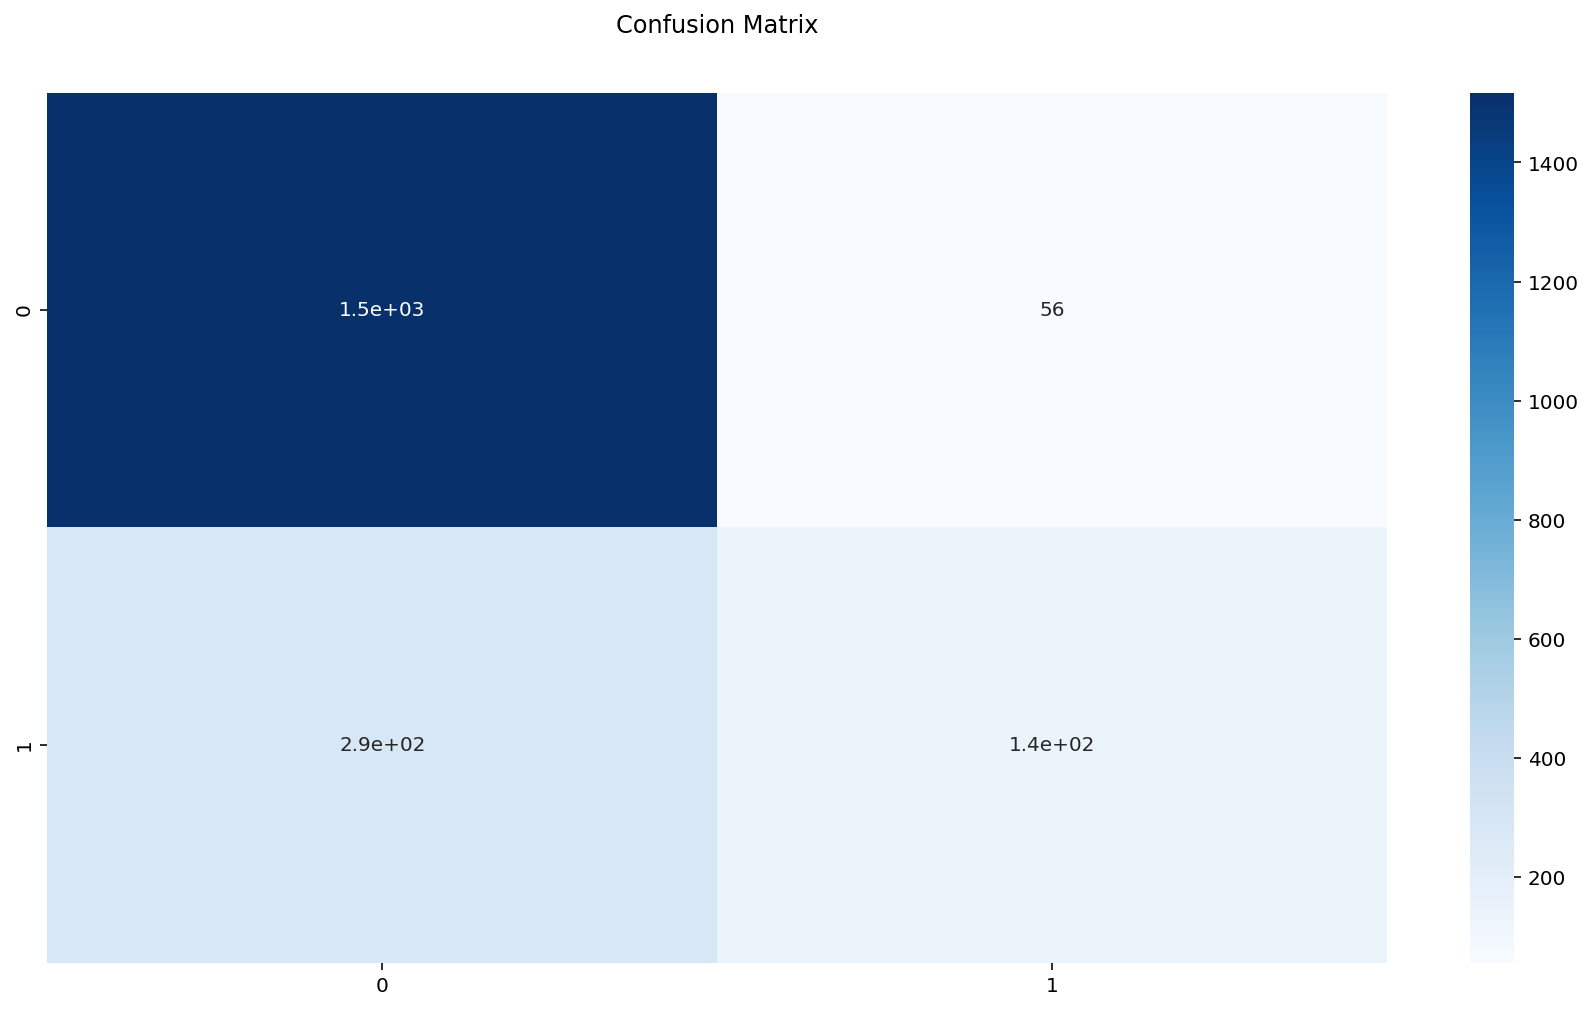

In [481]:
conf_matrix(y_test, prediction1)

Plotting different metrics scores for the Linear Regression Classifier for evaluation.

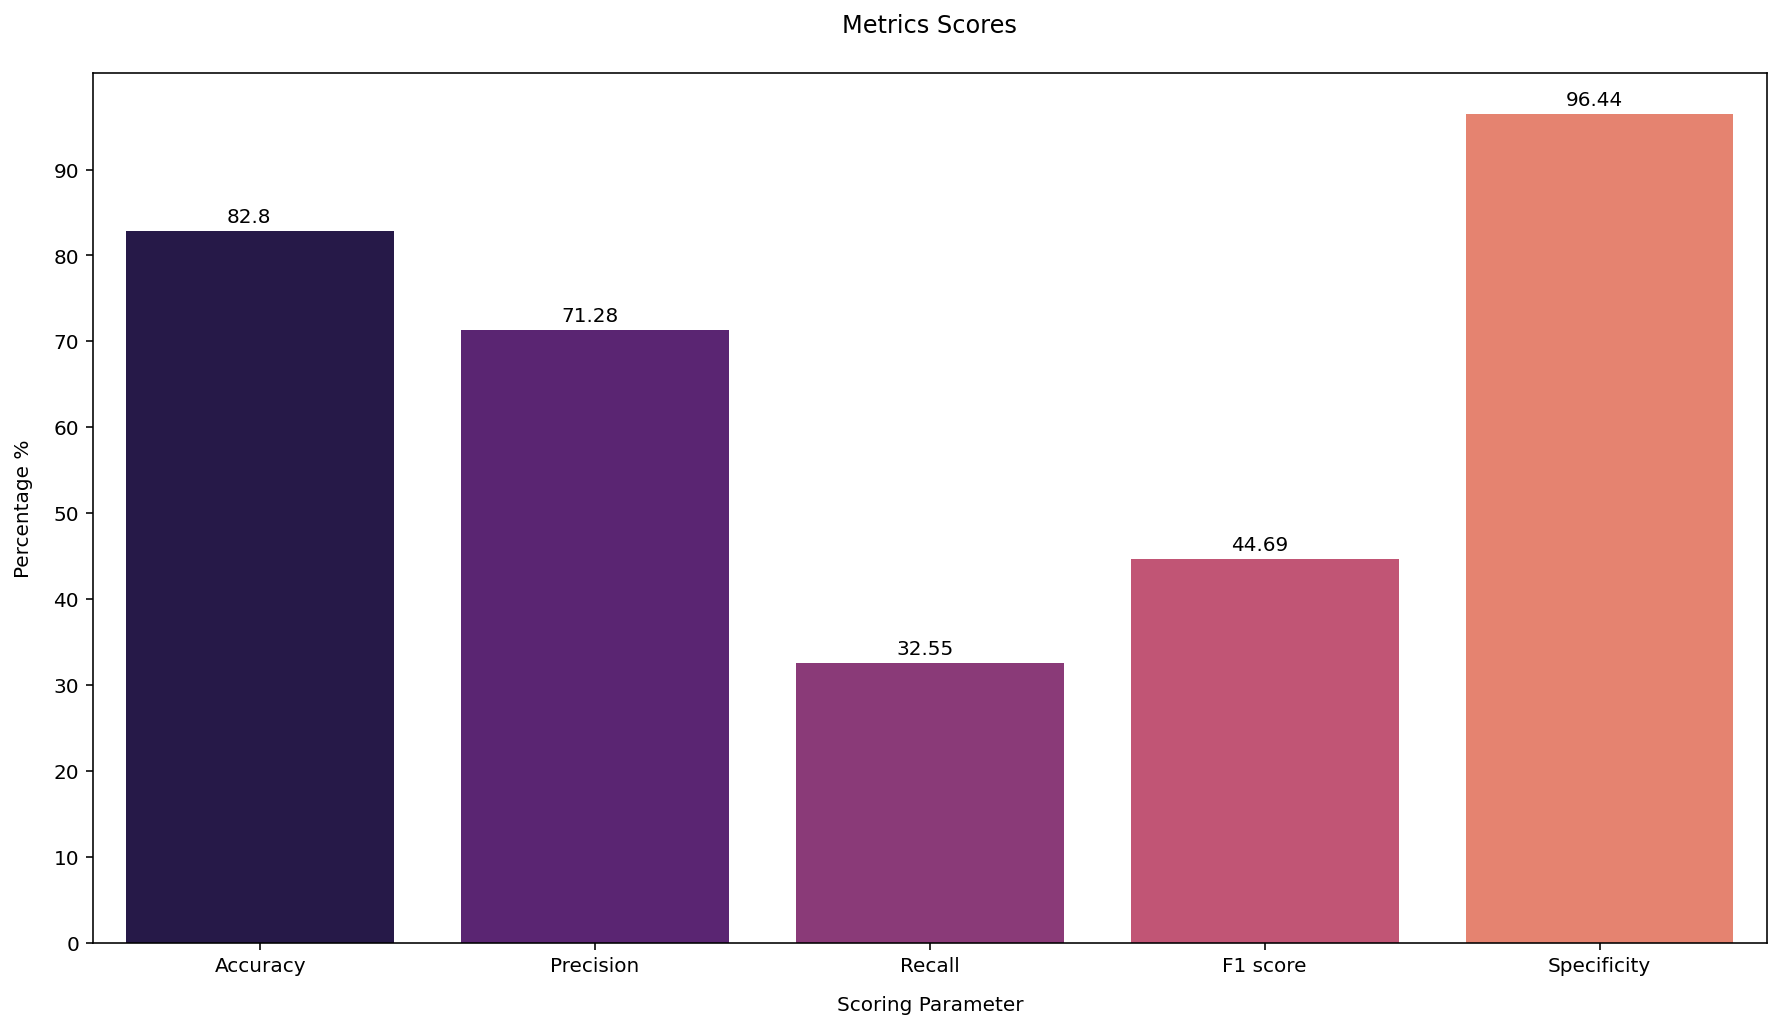

In [482]:
metrics_score(cm1)

* Plotting the average of different metrics scores for further evaluation.

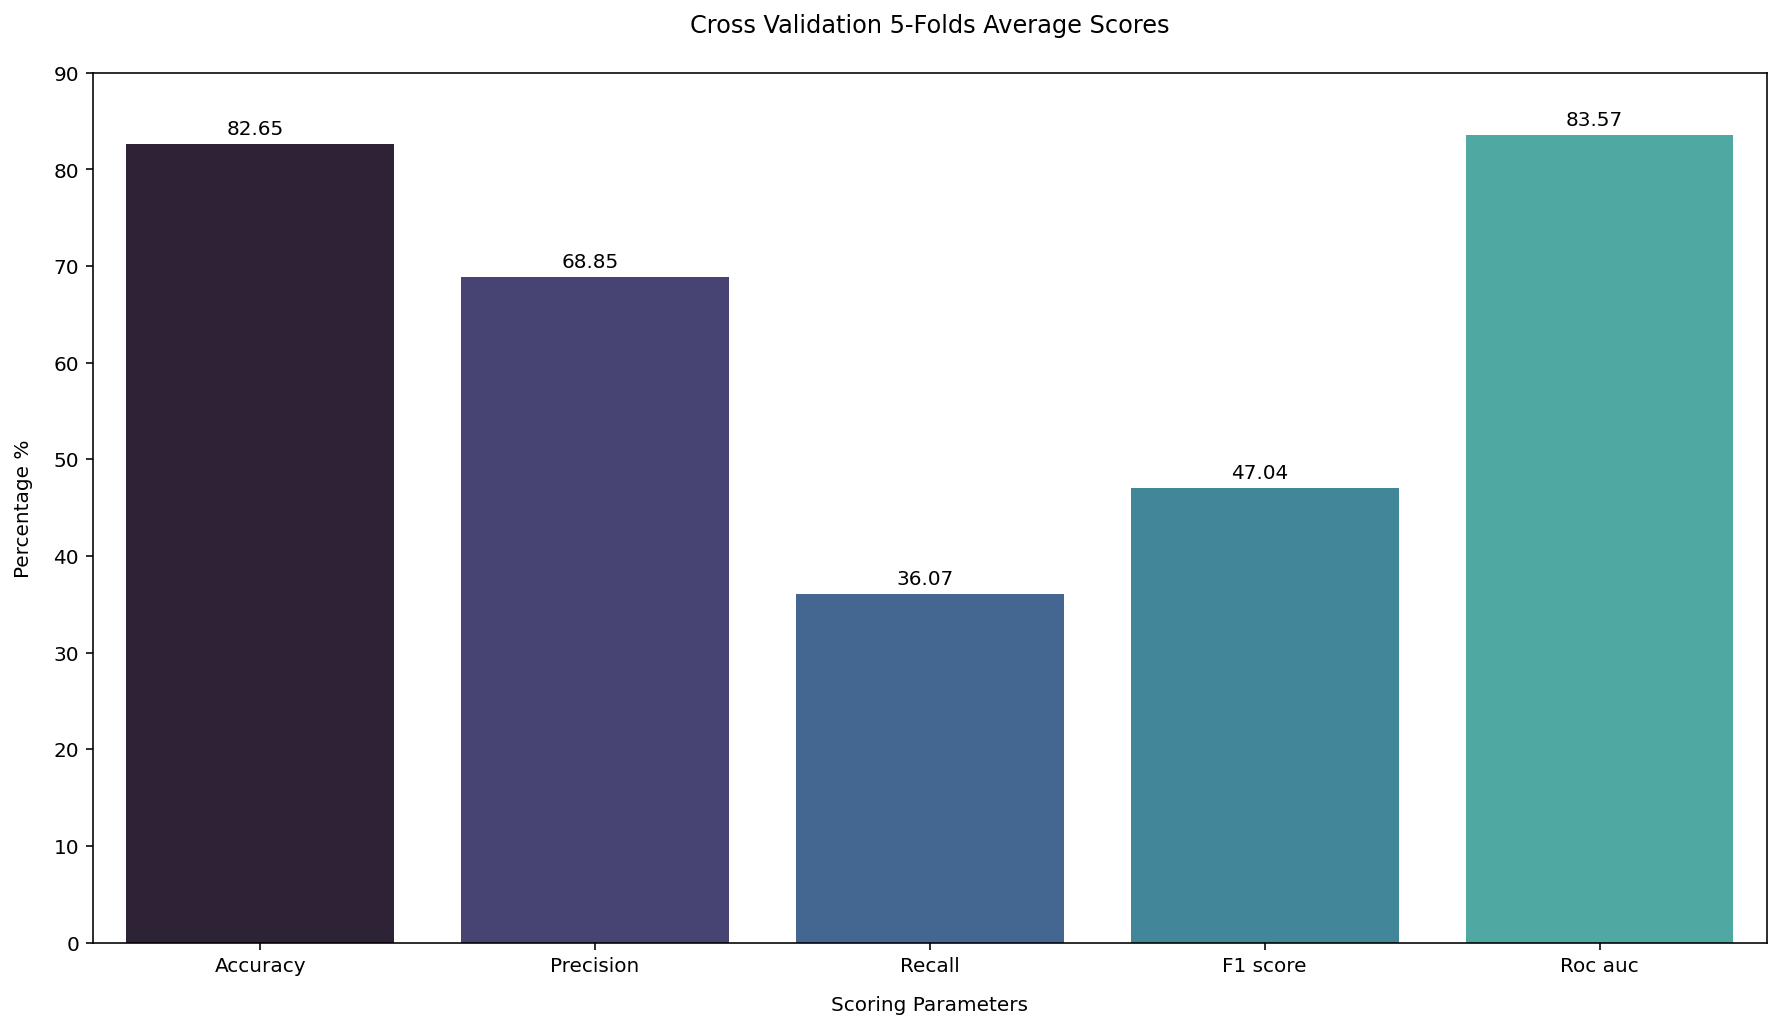

In [483]:
cv_score('Linear Regression', log_model, 5)

Plotting Receiver Operating Characteristic (ROC) Curve, to illustrate the diagnostic ability of Linear Regression Classifier as its discrimination threshold is varied and showing the Area under the ROC Curve (AUC) value which will tell us how much our model is capable of distinguishing between churn und nonchurn customers.

Area under the ROC Curve (AUC): 0.84


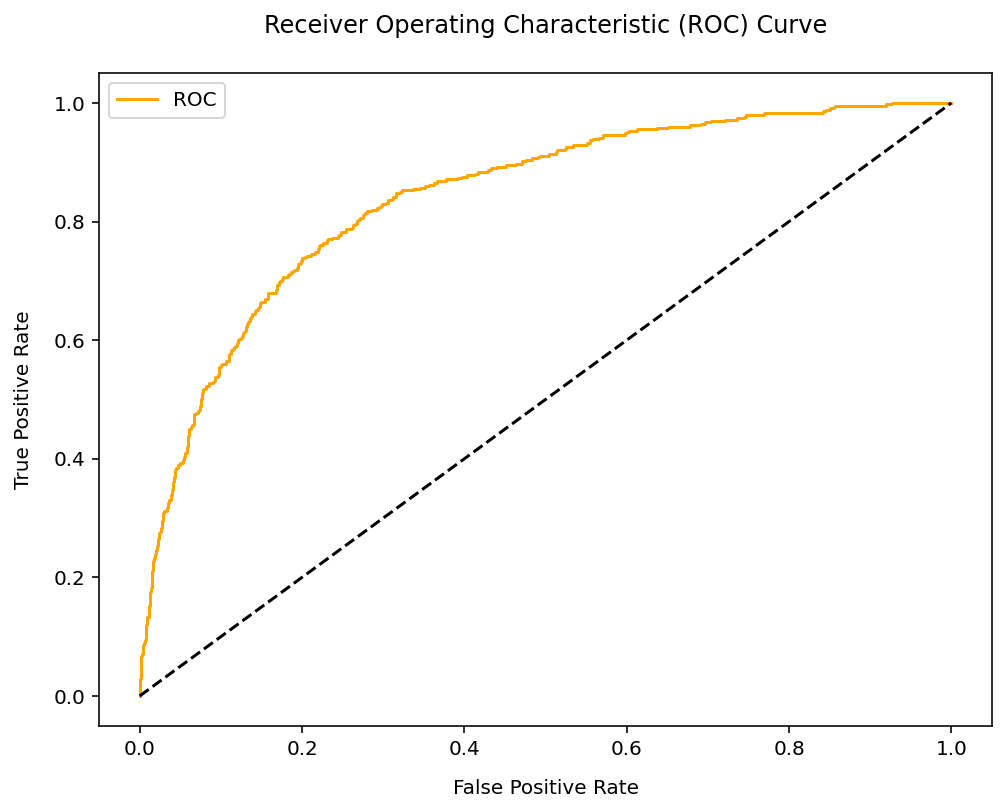

In [484]:
probs = log_model.predict_proba(X_test)
probs = probs[:, 1]
auc1 = roc_auc_score(y_test, probs)
roc_auc['Linear Regression'] = np.round(auc1, 2)
print('Area under the ROC Curve (AUC): %.2f' % auc1)
fpr1, tpr1, _ = roc_curve(y_test, probs)
plot_roc_curve(fpr1, tpr1)

Plotting Precision-Recall Curve for different thresholds of precision and recall much like the ROC Curve and showing the Area under the Precision-Recall Curve (AUCPR), it gives the number summary of the information in the Precision-Recall Curve.

Area under the PR Curve (AUCPR): 0.61


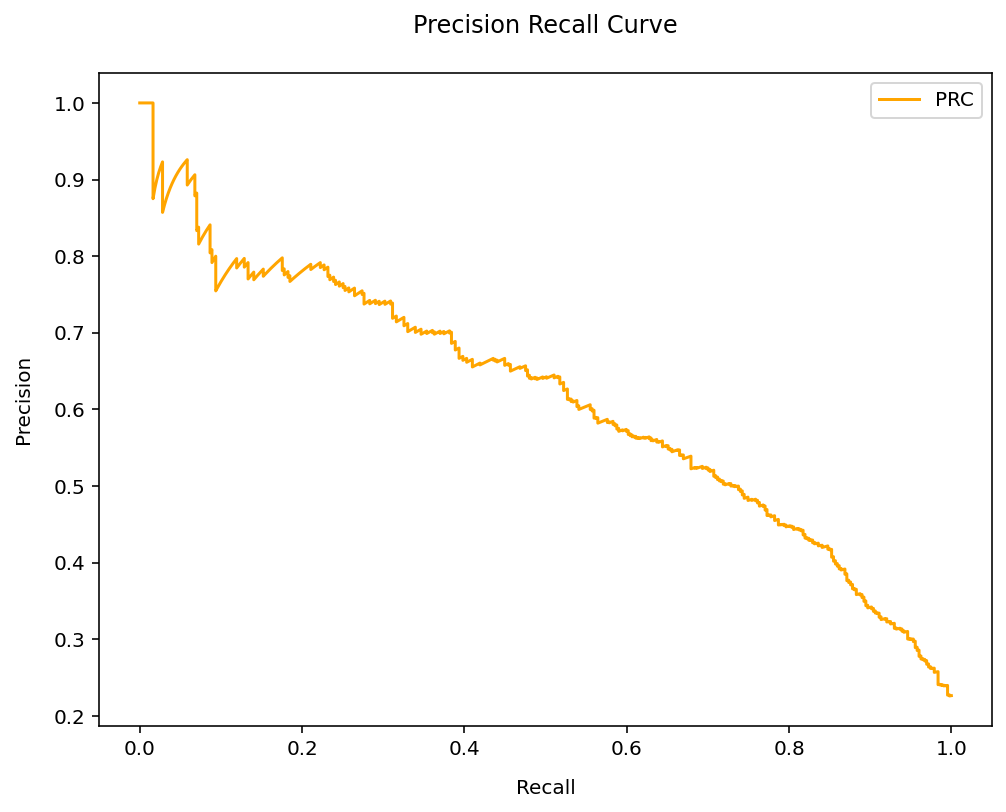

In [485]:
precision1, recall1, _ = precision_recall_curve(y_test, probs)
auc_score1 = auc(recall1, precision1)
pr_auc['Linear Regression'] = np.round(auc_score1, 2)
print('Area under the PR Curve (AUCPR): %.2f' % auc_score1)
plot_precision_recall_curve(recall1, precision1)

##  KNNeighbors Classifier

KNN is a non-parametric, lazy learning algorithm. Its purpose is to use a database in which the data points are separated into several classes to predict the classification of a new sample point.

In [486]:
y = df_1['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)
prediction2 = KNN_model.predict(X_test)
accuracy2 = KNN_model.score(X_test, y_test) 
print ('Model Accuracy:',accuracy2 * 100)

Model Accuracy: 82.05


Storing model accuracy to plot for comparison with other Machine Learning models.

In [487]:
accuracies['KNeighbors Classifier'] = np.round(accuracy2 * 100, 2)

1. Plotting Confusion Matrix to describe the performance of KNN Classifier on a set of test data.

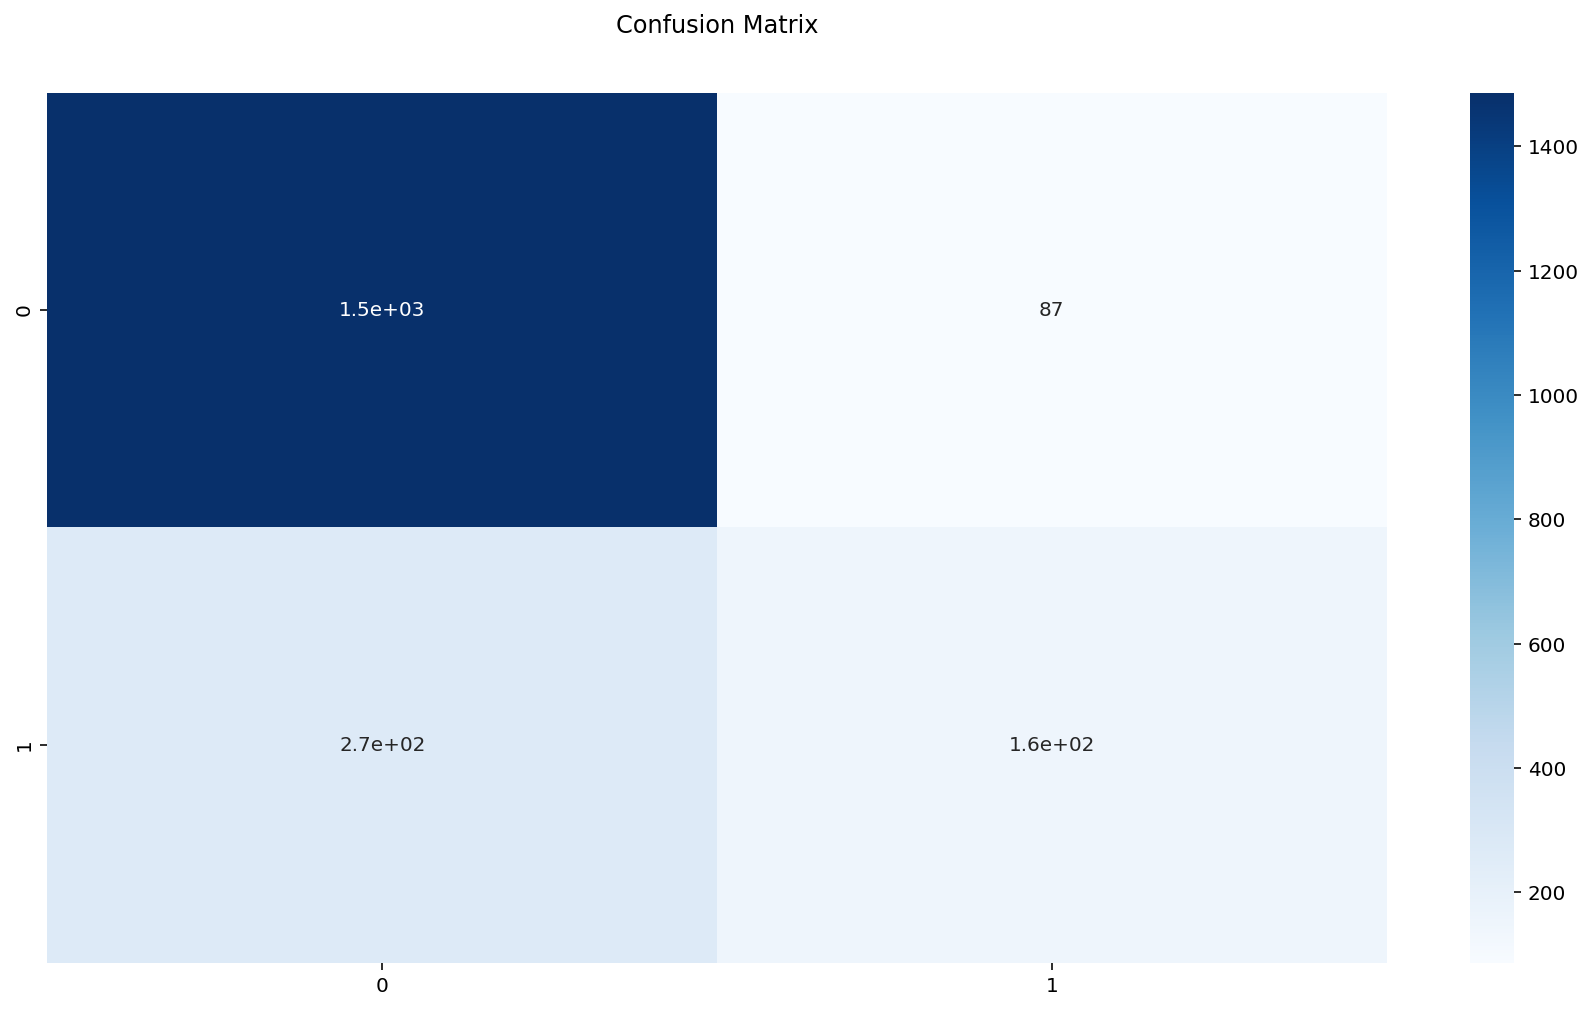

In [488]:
conf_matrix(y_test, prediction2)

Plotting different metrics scores for the KNN Classifier for evaluation.

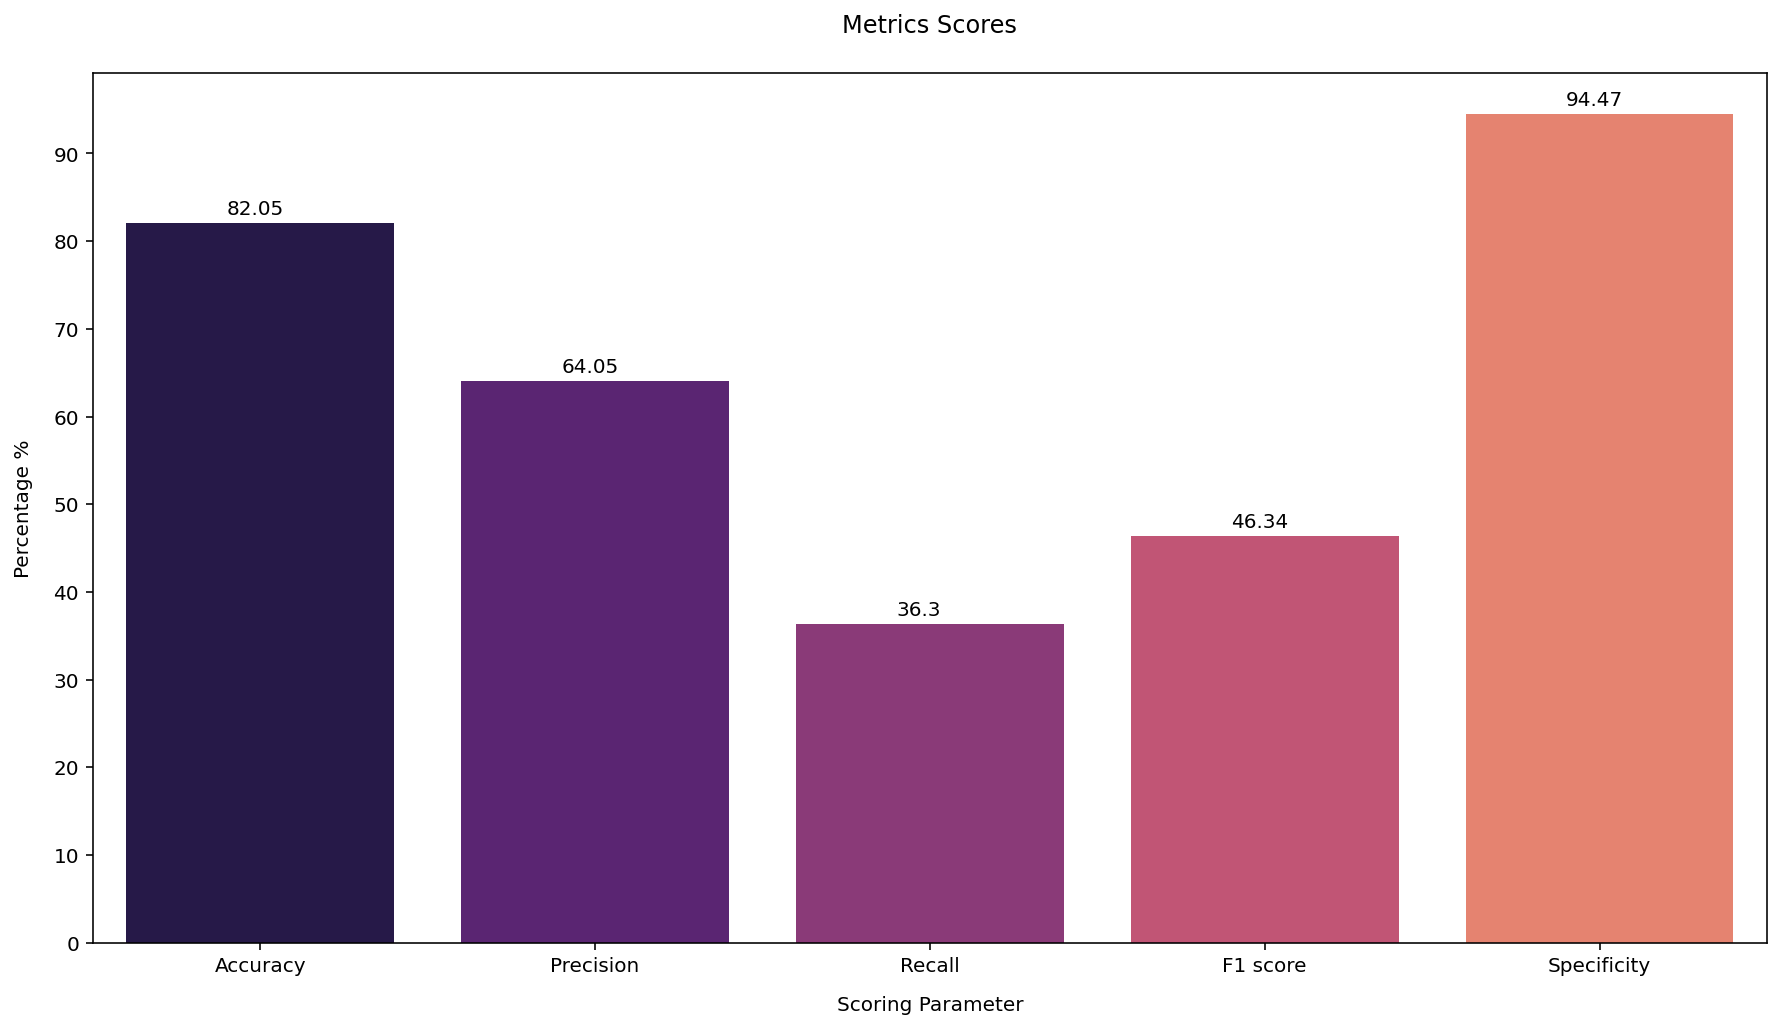

In [489]:
metrics_score(cm1)

* Plotting the average of different metrics scores for further evaluation.

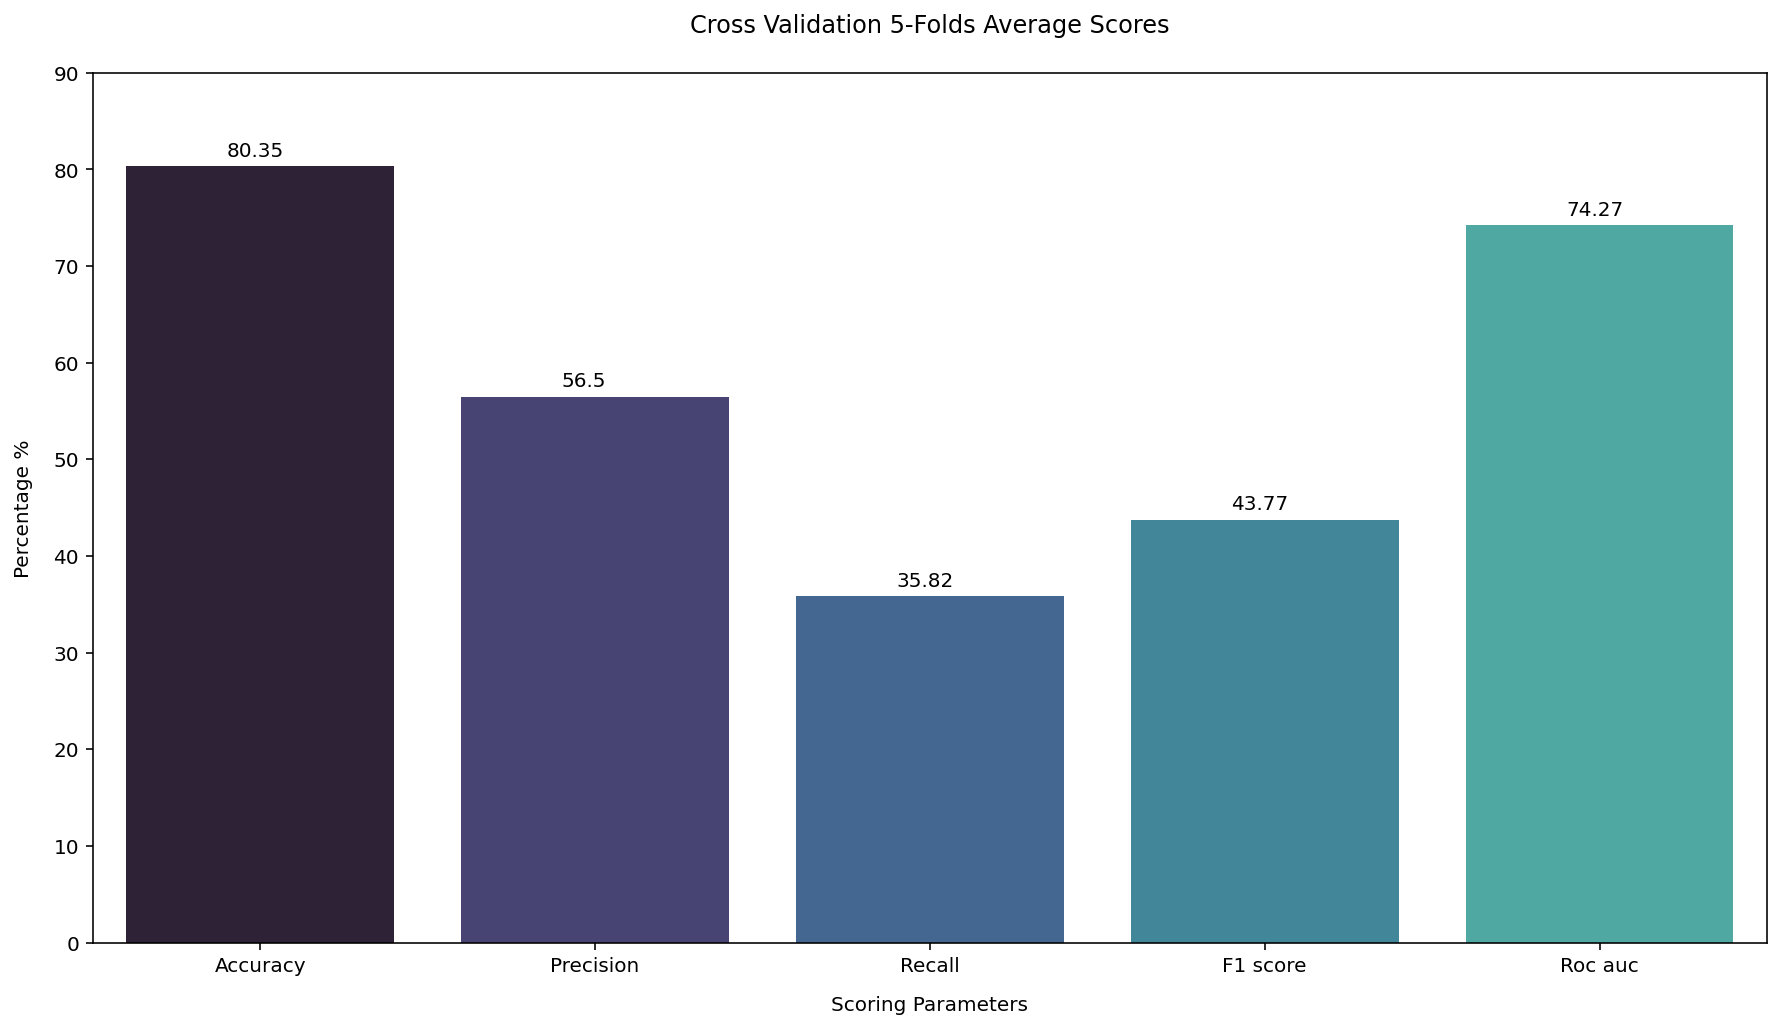

In [490]:
cv_score('KNeighbors Classifier', KNN_model, 5)

Plotting Receiver Operating Characteristic (ROC) Curve, to illustrate the diagnostic ability of KNN Classifier as its discrimination threshold is varied and showing the Area under the ROC Curve (AUC) value which will tell us how much our model is capable of distinguishing between churn und nonchurn customers.

Area under the ROC Curve (AUC): 0.77


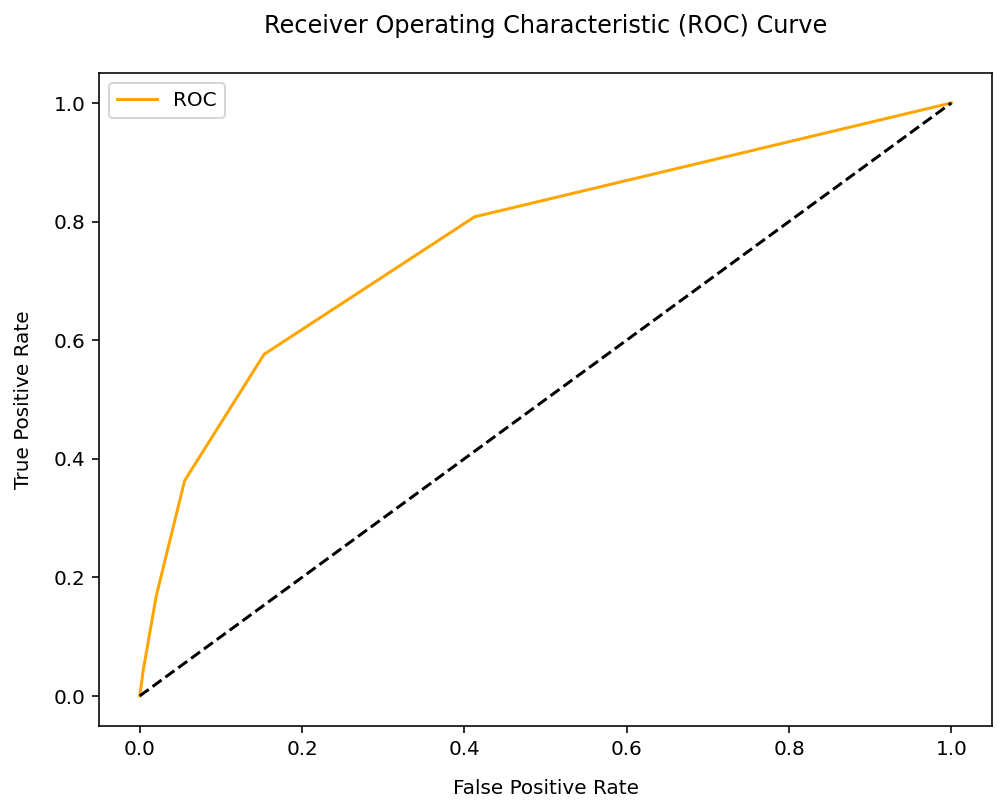

In [491]:
probs = KNN_model.predict_proba(X_test)
probs = probs[:, 1]
auc2 = roc_auc_score(y_test, probs)
roc_auc['KNeighbors Classifier'] = np.round(auc2, 2)
print('Area under the ROC Curve (AUC): %.2f' % auc2)
fpr2, tpr2, _ = roc_curve(y_test, probs)
plot_roc_curve(fpr2, tpr2)

Plotting Precision-Recall Curve for different thresholds of precision and recall much like the ROC Curve and showing the Area under the Precision-Recall Curve (AUCPR), it gives the number summary of the information in the Precision-Recall Curve.

Area under the PR Curve (AUCPR): 0.53


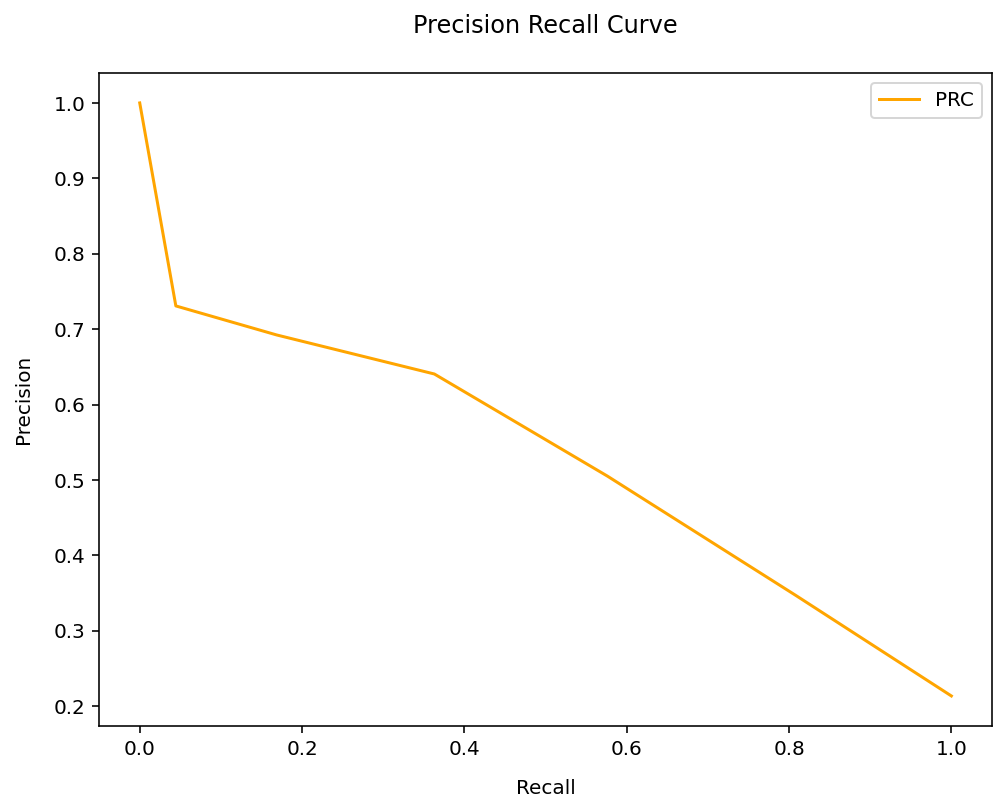

In [492]:
precision2, recall2, _ = precision_recall_curve(y_test, probs)
auc_score2 = auc(recall2, precision2)
pr_auc['KNeighbors Classifier'] = np.round(auc_score2, 2)
print('Area under the PR Curve (AUCPR): %.2f' % auc_score2)
plot_precision_recall_curve(recall2, precision2)

## Support Vector Machine Classifier


In [493]:
y = df_1['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
SVC_model = SVC(probability = True)
SVC_model.fit(X_train, y_train)
prediction3 = SVC_model.predict(X_test)
accuracy3 = SVC_model.score(X_test, y_test) 
print ('Model Accuracy:',accuracy3 * 100)

Model Accuracy: 78.64999999999999


Storing model accuracy to plot for comparison with other Machine Learning models.

In [494]:
accuracies['Support Vector Machine Classifier'] = np.round(accuracy3 * 100, 2)

1. Plotting Confusion Matrix to describe the performance of SVM Classifier on a set of test data.

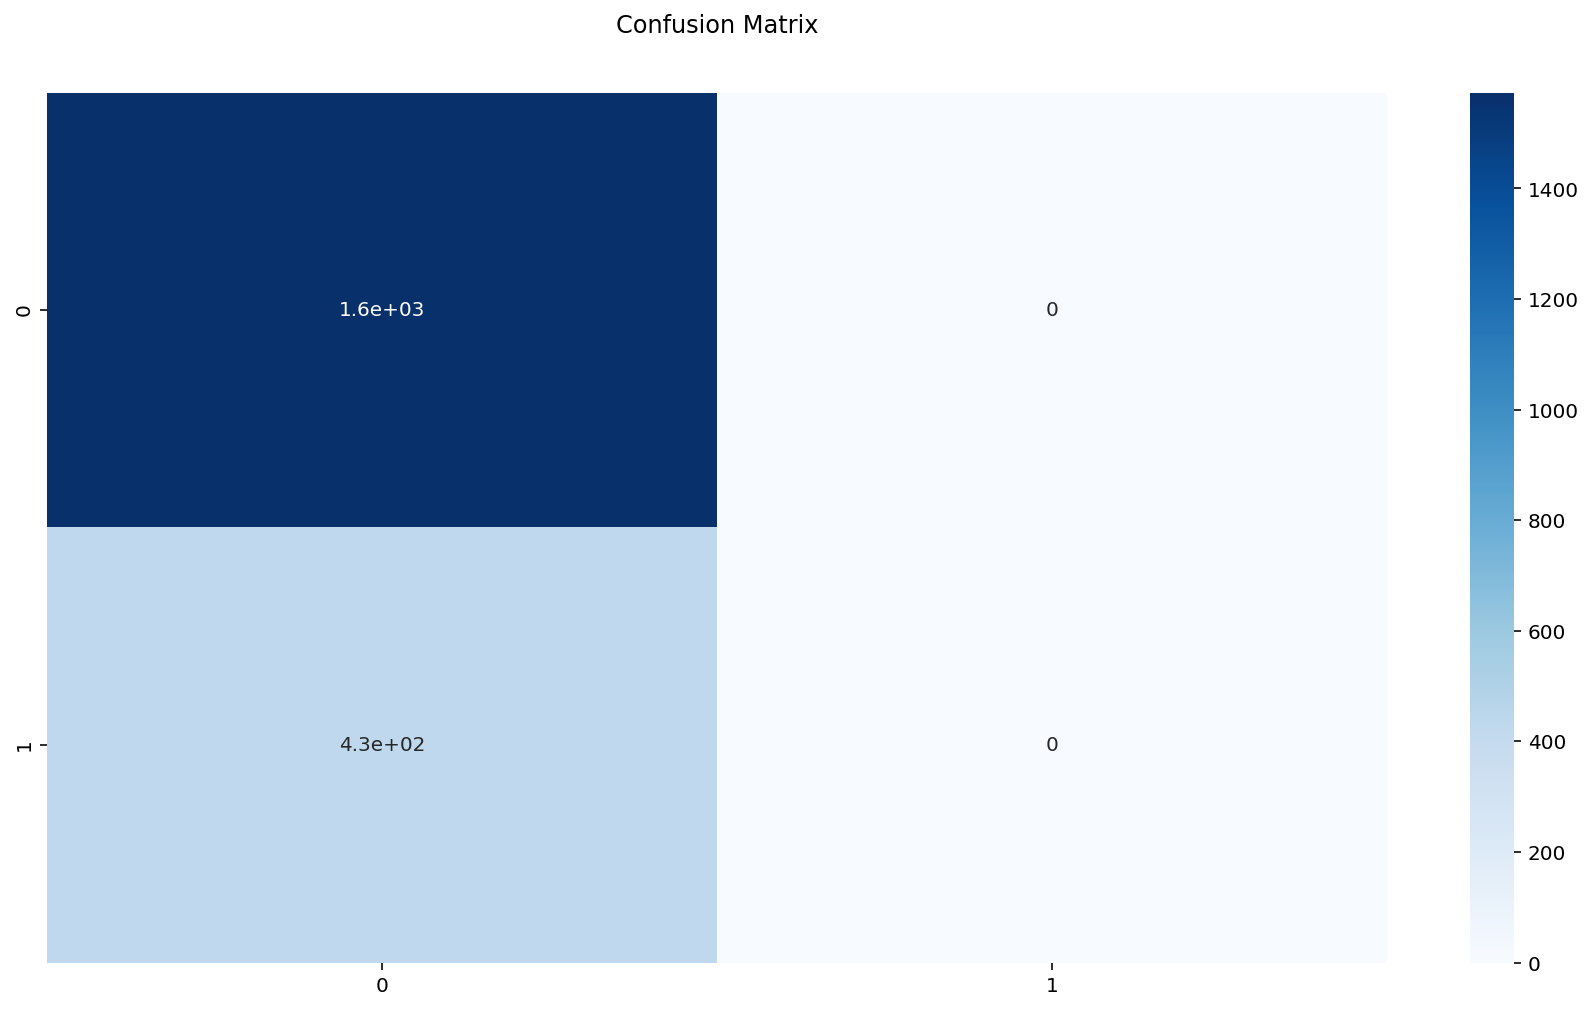

In [495]:
conf_matrix(y_test, prediction3)

Plotting different metrics scores for the SVM Classifier for evaluation.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


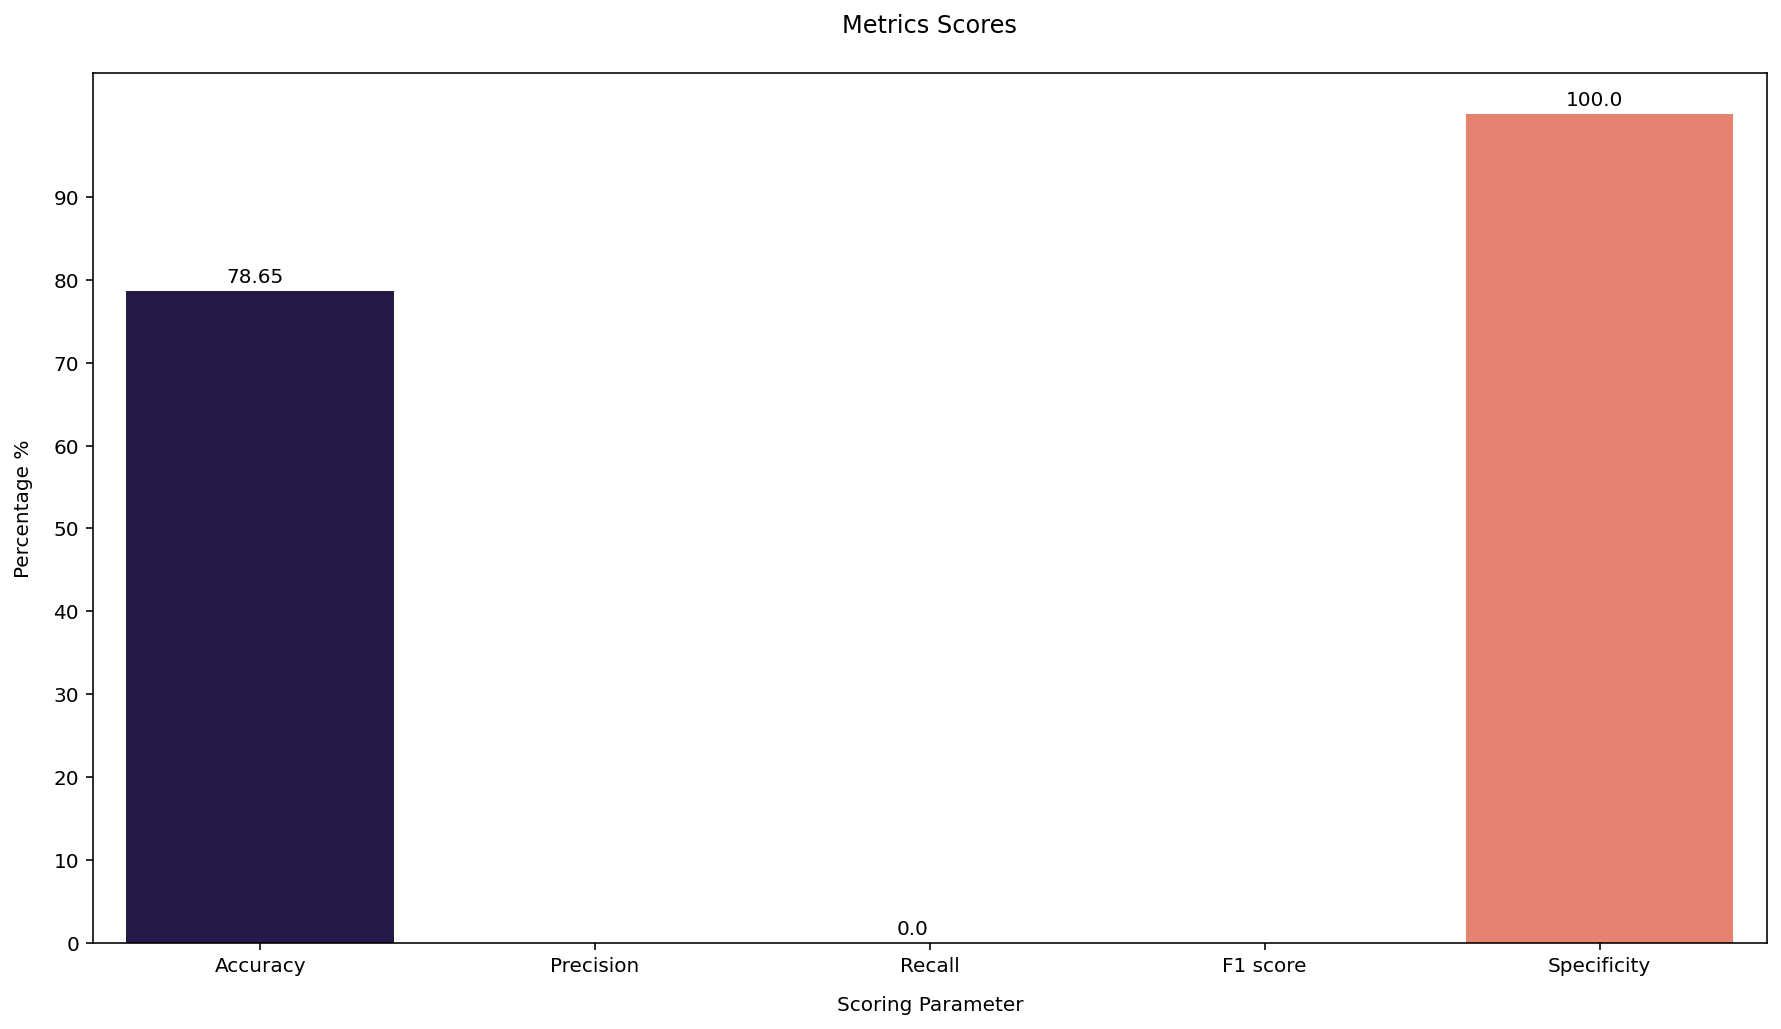

In [496]:
metrics_score(cm1);

* Plotting the average of different metrics scores for further evaluation.

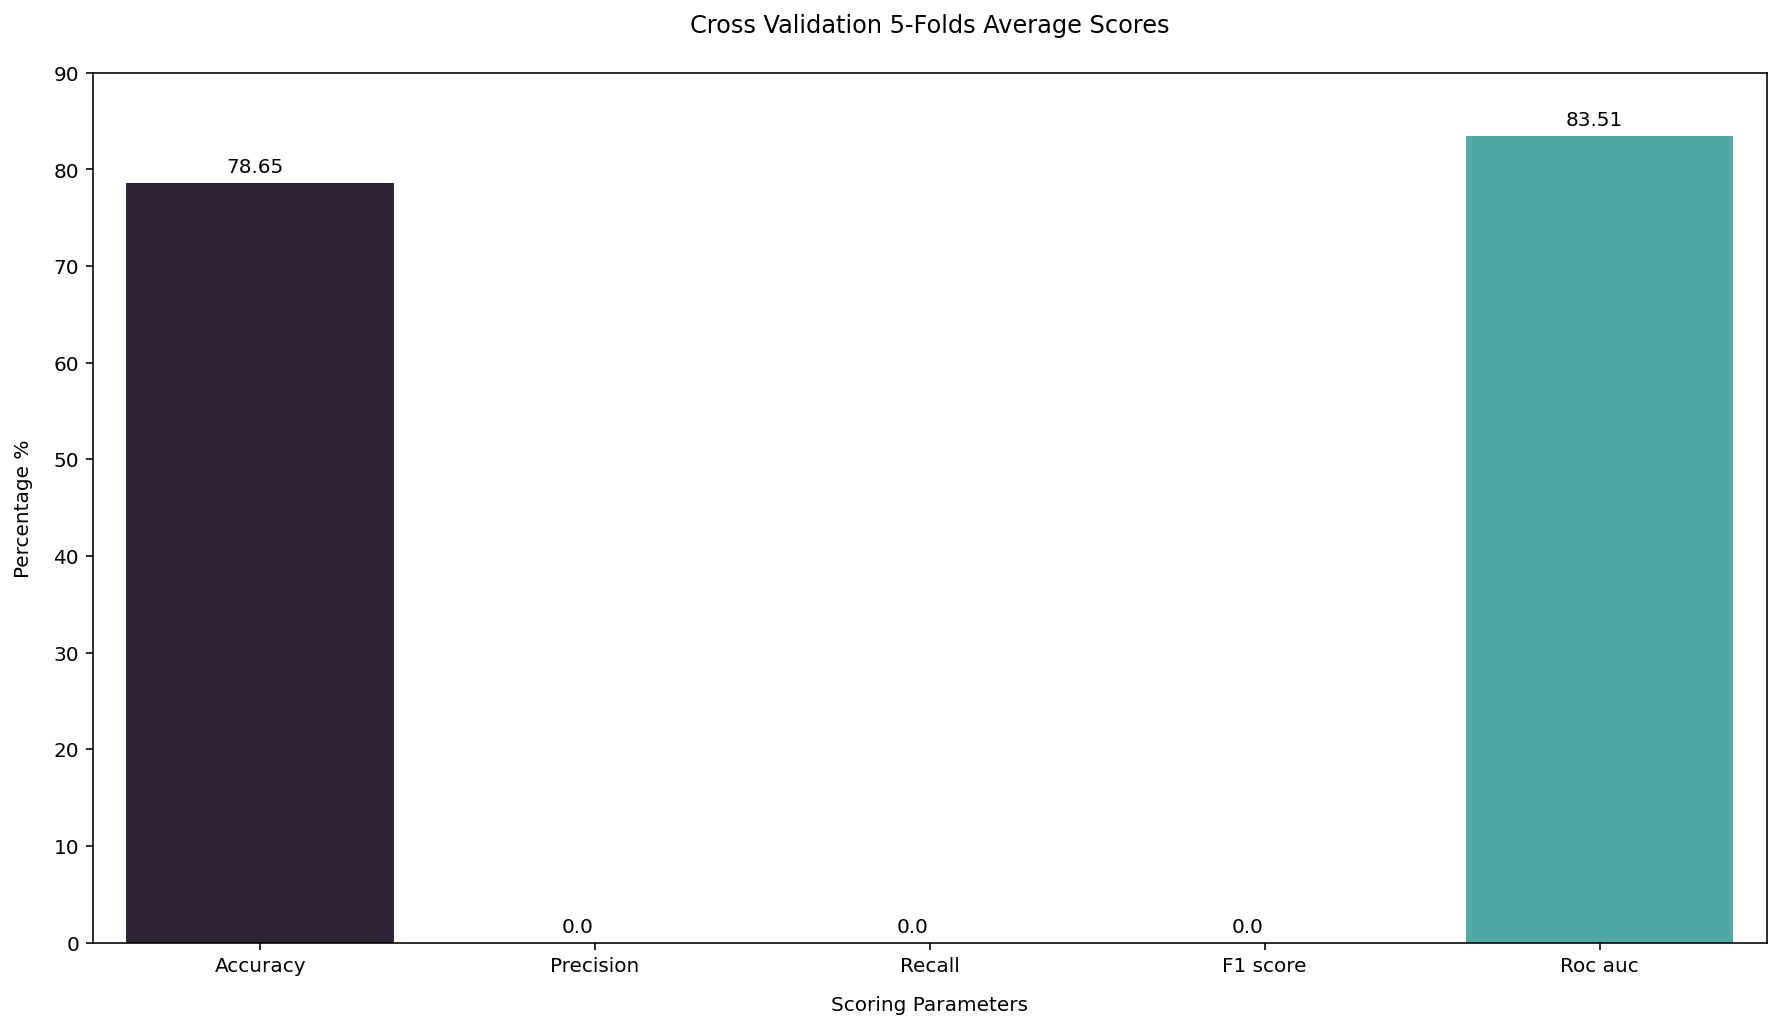

In [497]:
cv_score('Support Vector Machine Classifier', SVC_model, 5)

Plotting Receiver Operating Characteristic (ROC) Curve, to illustrate the diagnostic ability of SVM Classifier as its discrimination threshold is varied and showing the Area under the ROC Curve (AUC) value which will tell us how much our model is capable of distinguishing between churn und nonchurn customers.

Area under the ROC Curve (AUC): 0.86


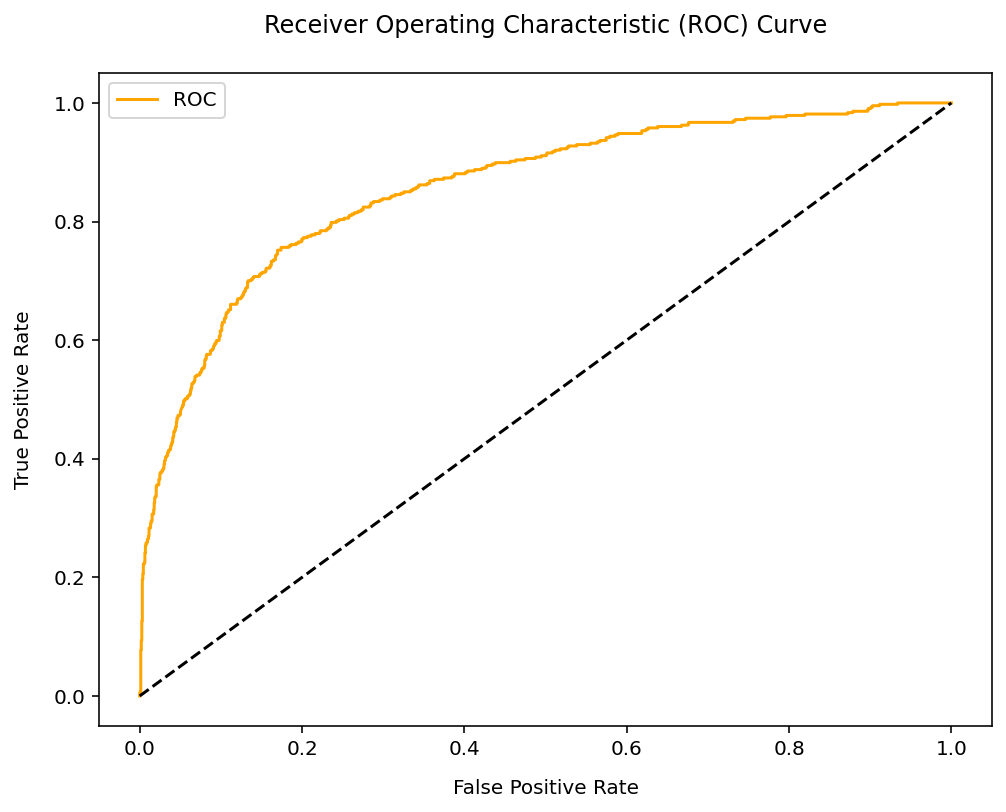

In [498]:
probs = SVC_model.predict_proba(X_test)
probs = probs[:, 1]
auc3 = roc_auc_score(y_test, probs)
roc_auc['Support Vector Machine Classifier'] = np.round(auc3, 2)
print('Area under the ROC Curve (AUC): %.2f' % auc3)
fpr3, tpr3, _ = roc_curve(y_test, probs)
plot_roc_curve(fpr3, tpr3)

Plotting Precision-Recall Curve for different thresholds of precision and recall much like the ROC Curve and showing the Area under the Precision-Recall Curve (AUCPR), it gives the number summary of the information in the Precision-Recall Curve.

Area under the PR Curve (AUCPR): 0.68


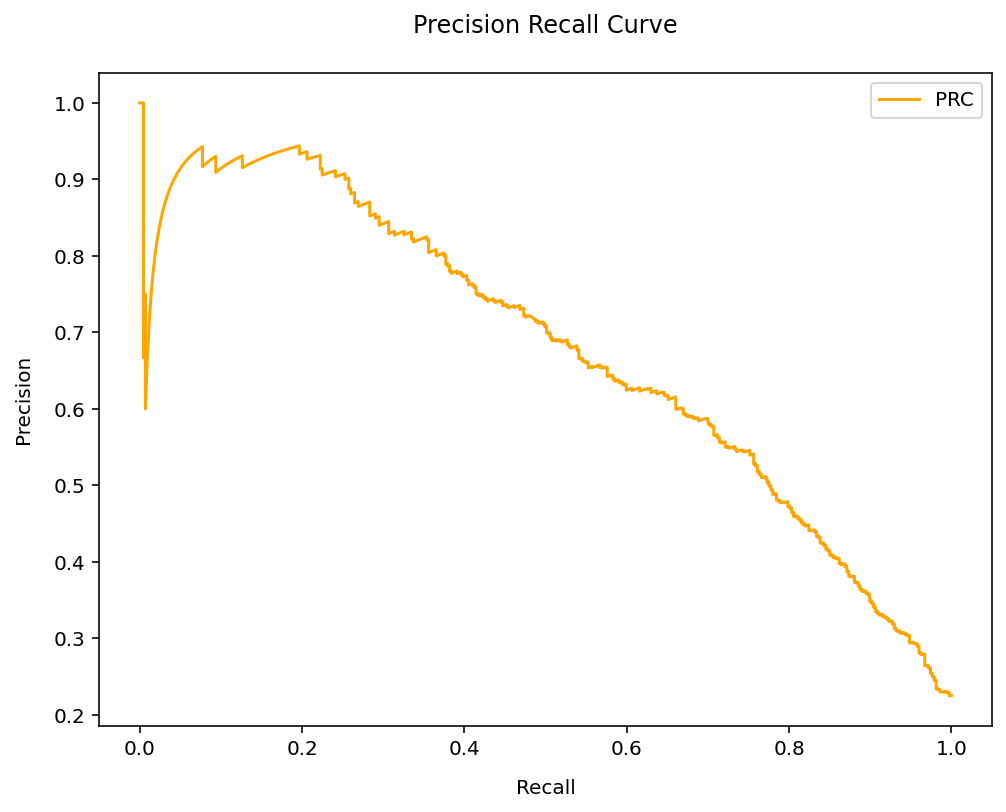

In [499]:
precision3, recall3, _ = precision_recall_curve(y_test, probs)
auc_score3 = auc(recall3, precision3)
pr_auc['Support Vector Machine Classifier'] = np.round(auc_score3, 2)
print('Area under the PR Curve (AUCPR): %.2f' % auc_score3)
plot_precision_recall_curve(recall3, precision3)

## Classification and Regression Tree


Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [500]:
y = df_1['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
CART_model = DecisionTreeClassifier(max_depth = 10, min_samples_split = 50)
CART_model.fit(X_train, y_train)
prediction4 = CART_model.predict(X_test)
accuracy4 = CART_model.score(X_test, y_test) 
print ('Model Accuracy:',accuracy4 * 100)

Model Accuracy: 83.65


Storing model accuracy to plot for comparison with other Machine Learning models.

In [501]:
accuracies['Classification and Regression Tree'] = np.round(accuracy4 * 100, 2)

1. Plotting Confusion Matrix to describe the performance of CART Classifier on a set of test data.

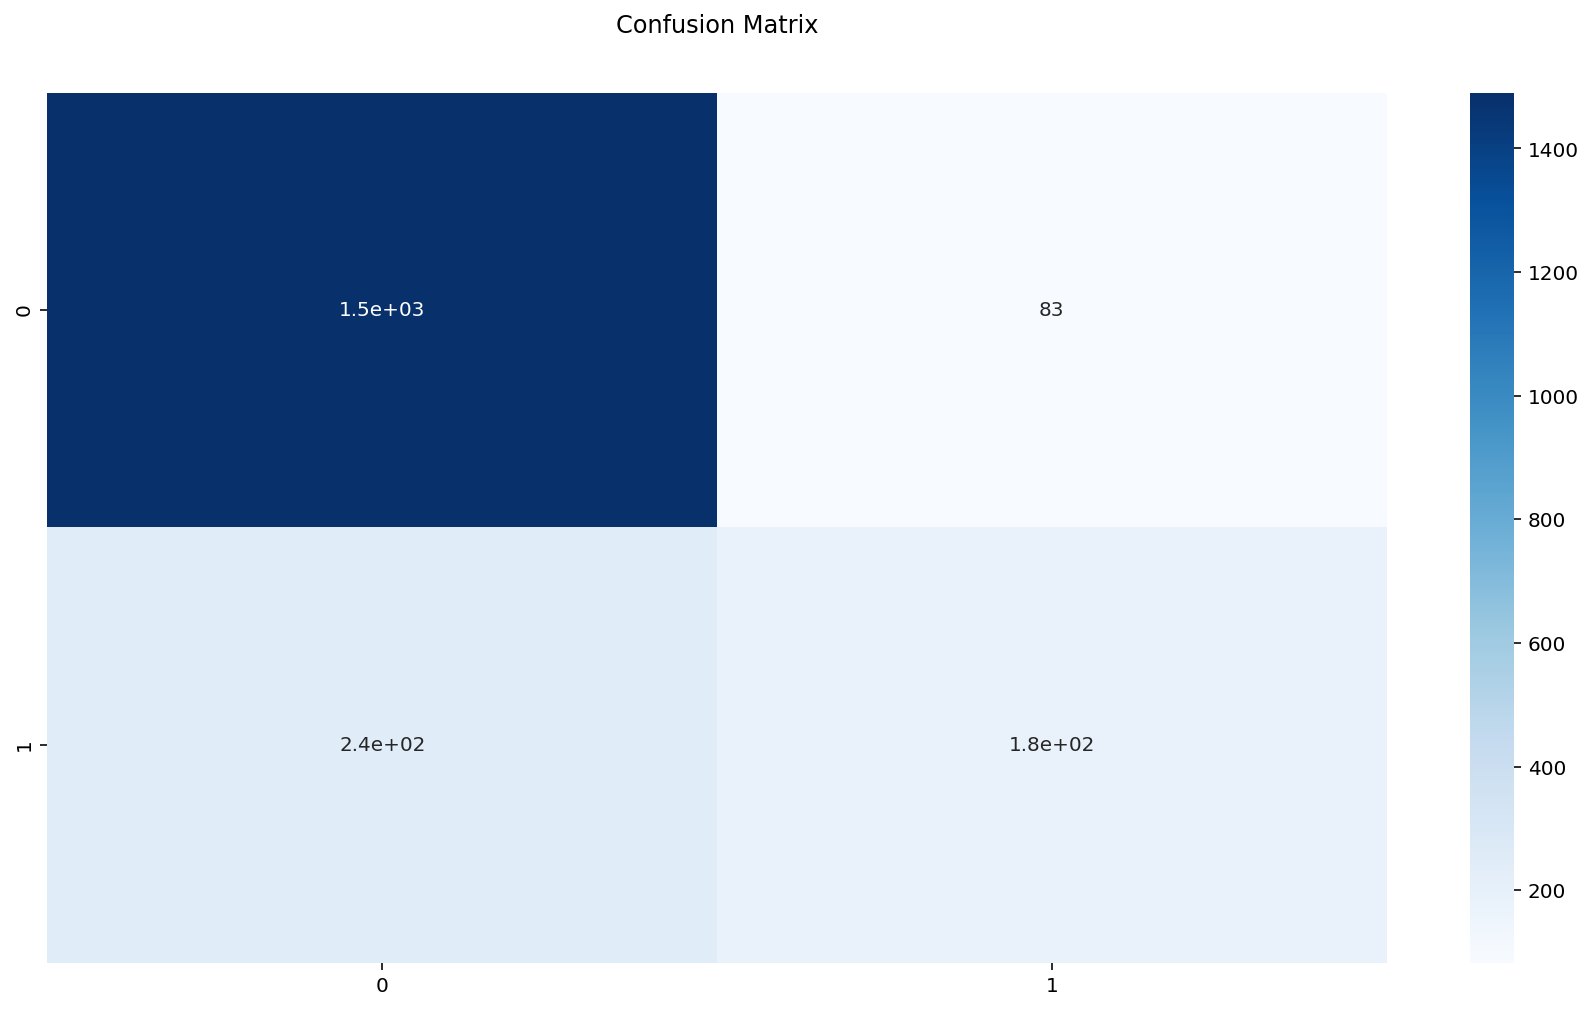

In [502]:
conf_matrix(y_test, prediction4)

Plotting different metrics scores for the CART Classifier for evaluation.

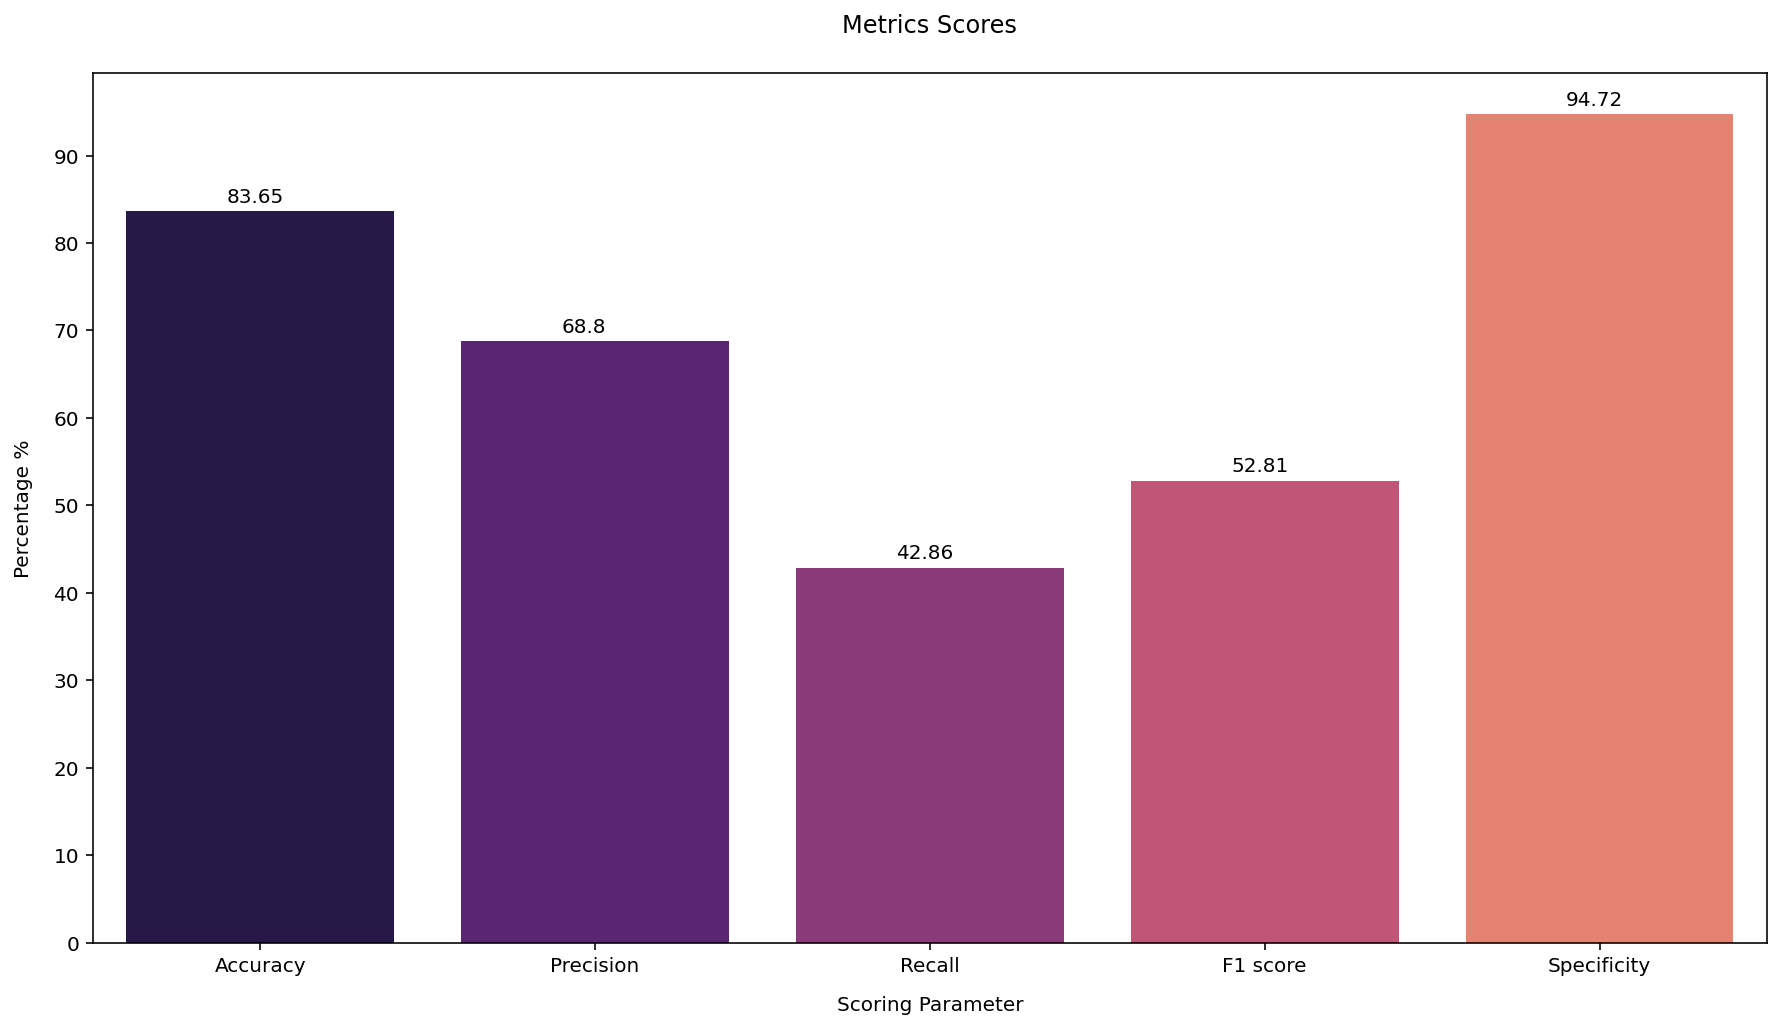

In [503]:
metrics_score(cm1)

* Plotting the average of different metrics scores for further evaluation.

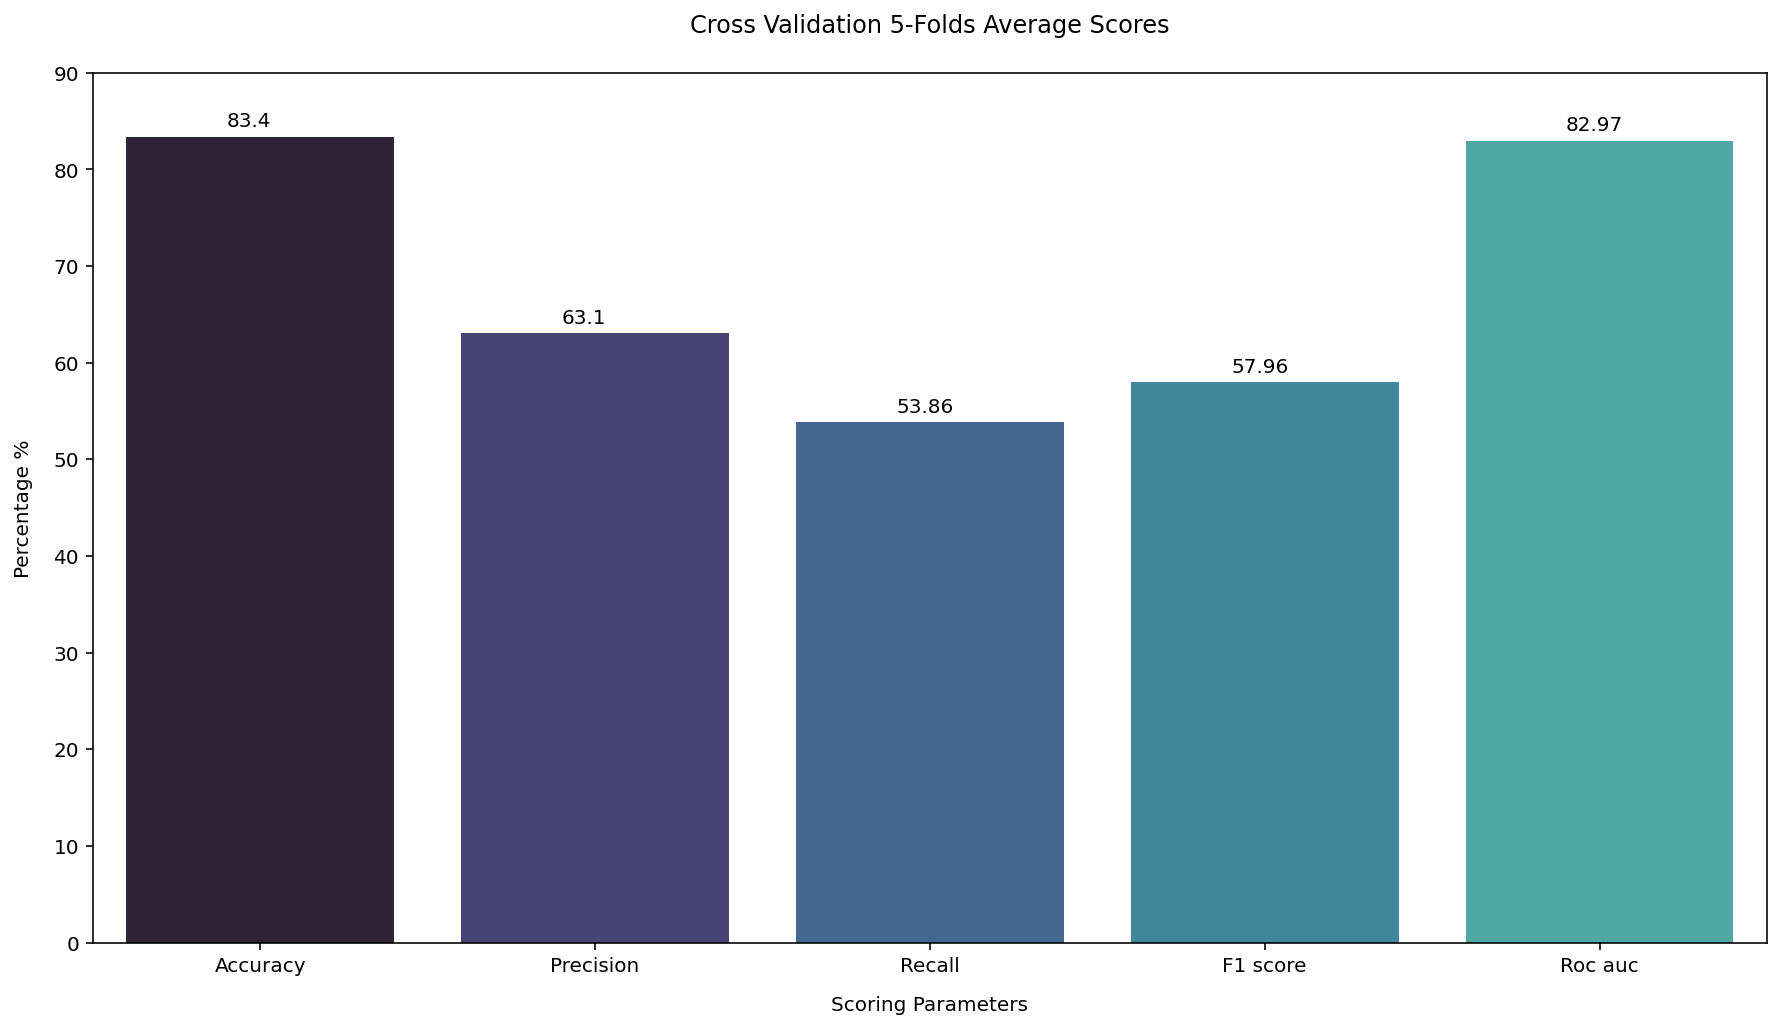

In [504]:
cv_score('Classification and Regression Tree', CART_model, 5)

Plotting Receiver Operating Characteristic (ROC) Curve, to illustrate the diagnostic ability of CART Classifier as its discrimination threshold is varied and showing the Area under the ROC Curve (AUC) value which will tell us how much our model is capable of distinguishing between churn und nonchurn customers.

Area under the ROC Curve (AUC): 0.83


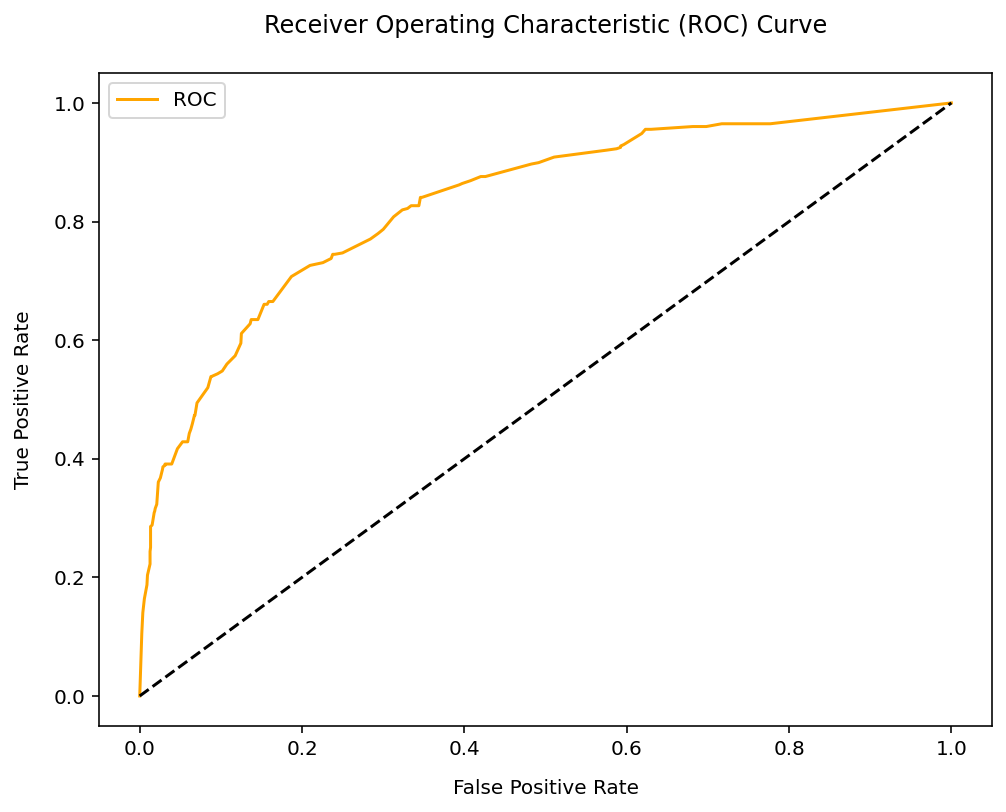

In [505]:
probs = CART_model.predict_proba(X_test)
probs = probs[:, 1]
auc4 = roc_auc_score(y_test, probs)
roc_auc['Desicion Tree Classifier']=np.round(auc4, 2)
print('Area under the ROC Curve (AUC): %.2f' % auc4)
fpr4, tpr4, _ = roc_curve(y_test, probs)
plot_roc_curve(fpr4, tpr4)

Plotting Precision-Recall Curve for different thresholds of precision and recall much like the ROC Curve and showing the Area under the Precision-Recall Curve (AUCPR), it gives the number summary of the information in the Precision-Recall Curve.

Area under the PR Curve (AUCPR): 0.64


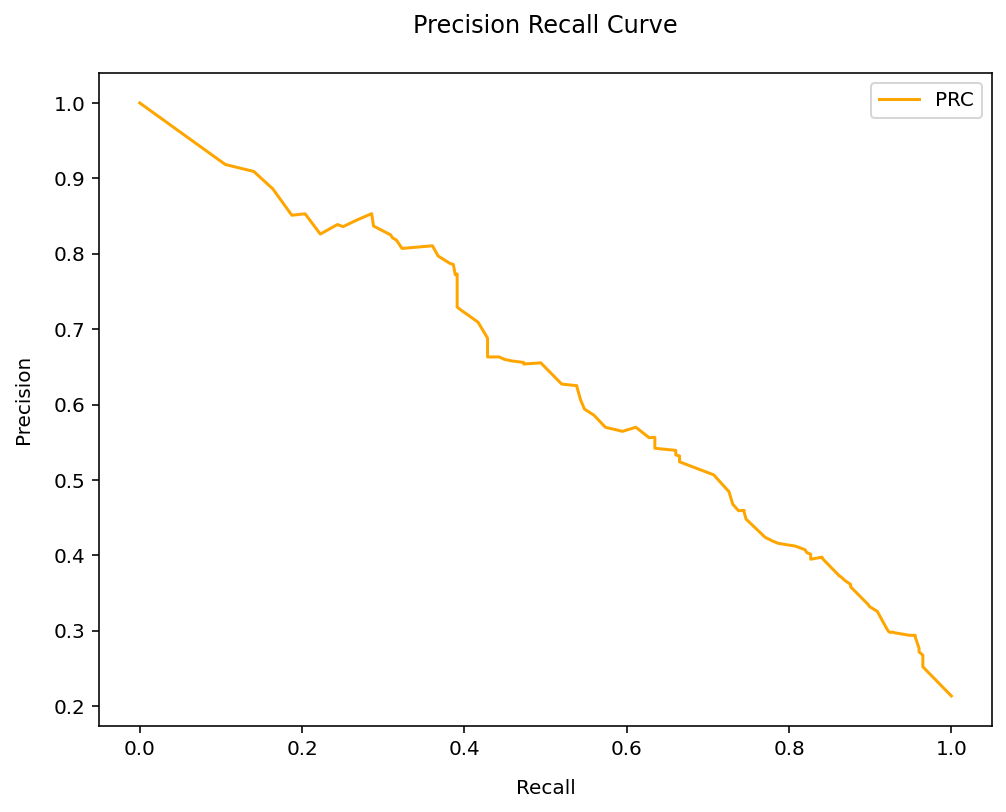

In [506]:
precision4, recall4, _ = precision_recall_curve(y_test, probs)
auc_score4 = auc(recall4, precision4)
pr_auc['Desicion Tree Classifier'] = np.round(auc_score4, 2)
print('Area under the PR Curve (AUCPR): %.2f' % auc_score4)
plot_precision_recall_curve(recall4, precision4)

## Random Forests


A Random Forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [507]:
y = df_1['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
rf_model = RandomForestClassifier(max_features = 3, min_samples_split = 10, n_estimators = 200)
rf_model.fit(X_train, y_train)
prediction5 = rf_model.predict(X_test)
accuracy5 = rf_model.score(X_test, y_test) 
print ('Model Accuracy:',accuracy5 * 100)

Model Accuracy: 86.05000000000001


In [508]:
#rf_params = {"n_estimators": [100, 200, 500, 1000], "max_features": [3, 5, 7, 8], "min_samples_split": [2, 5, 10, 20]}
#rf_cv_model = GridSearchCV(rf, rf_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train, y_train)
#rf_cv_model.best_params_

Storing model accuracy to plot for comparison with other Machine Learning models.

In [509]:
accuracies['Random Forests'] = np.round(accuracy5 * 100, 2)

1. Plotting Confusion Matrix to describe the performance of Random Forest Classifier on a set of test data.

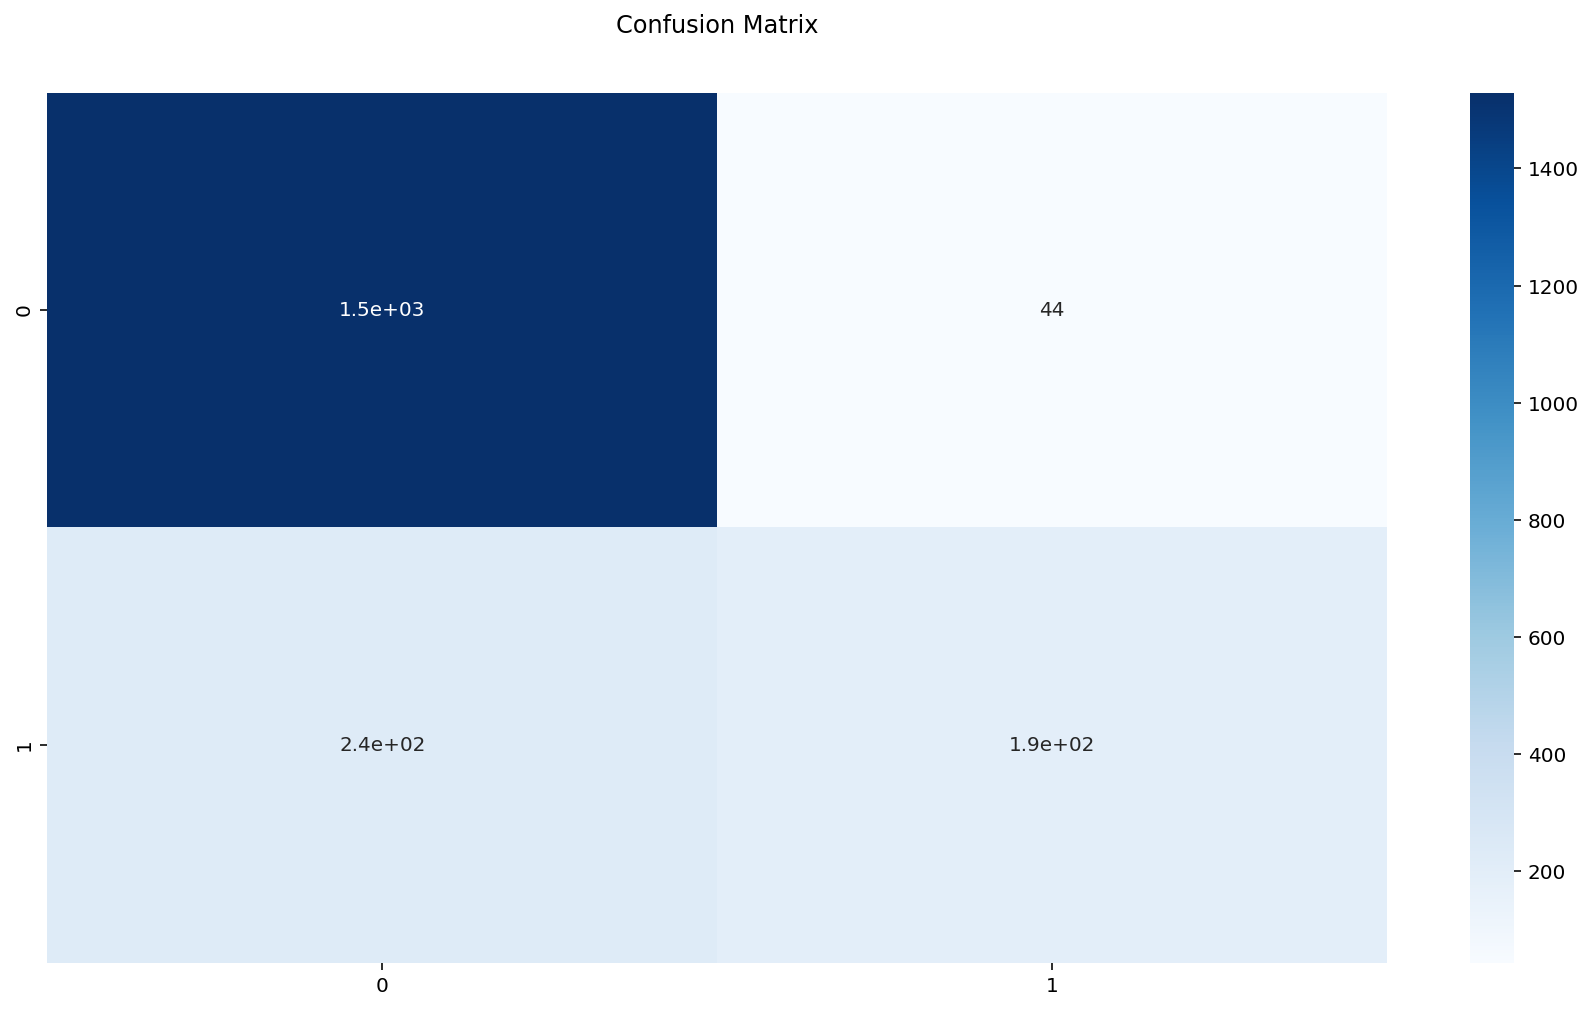

In [510]:
conf_matrix(y_test, prediction5)

Plotting different metrics scores for the Random Forest Classifier for evaluation.

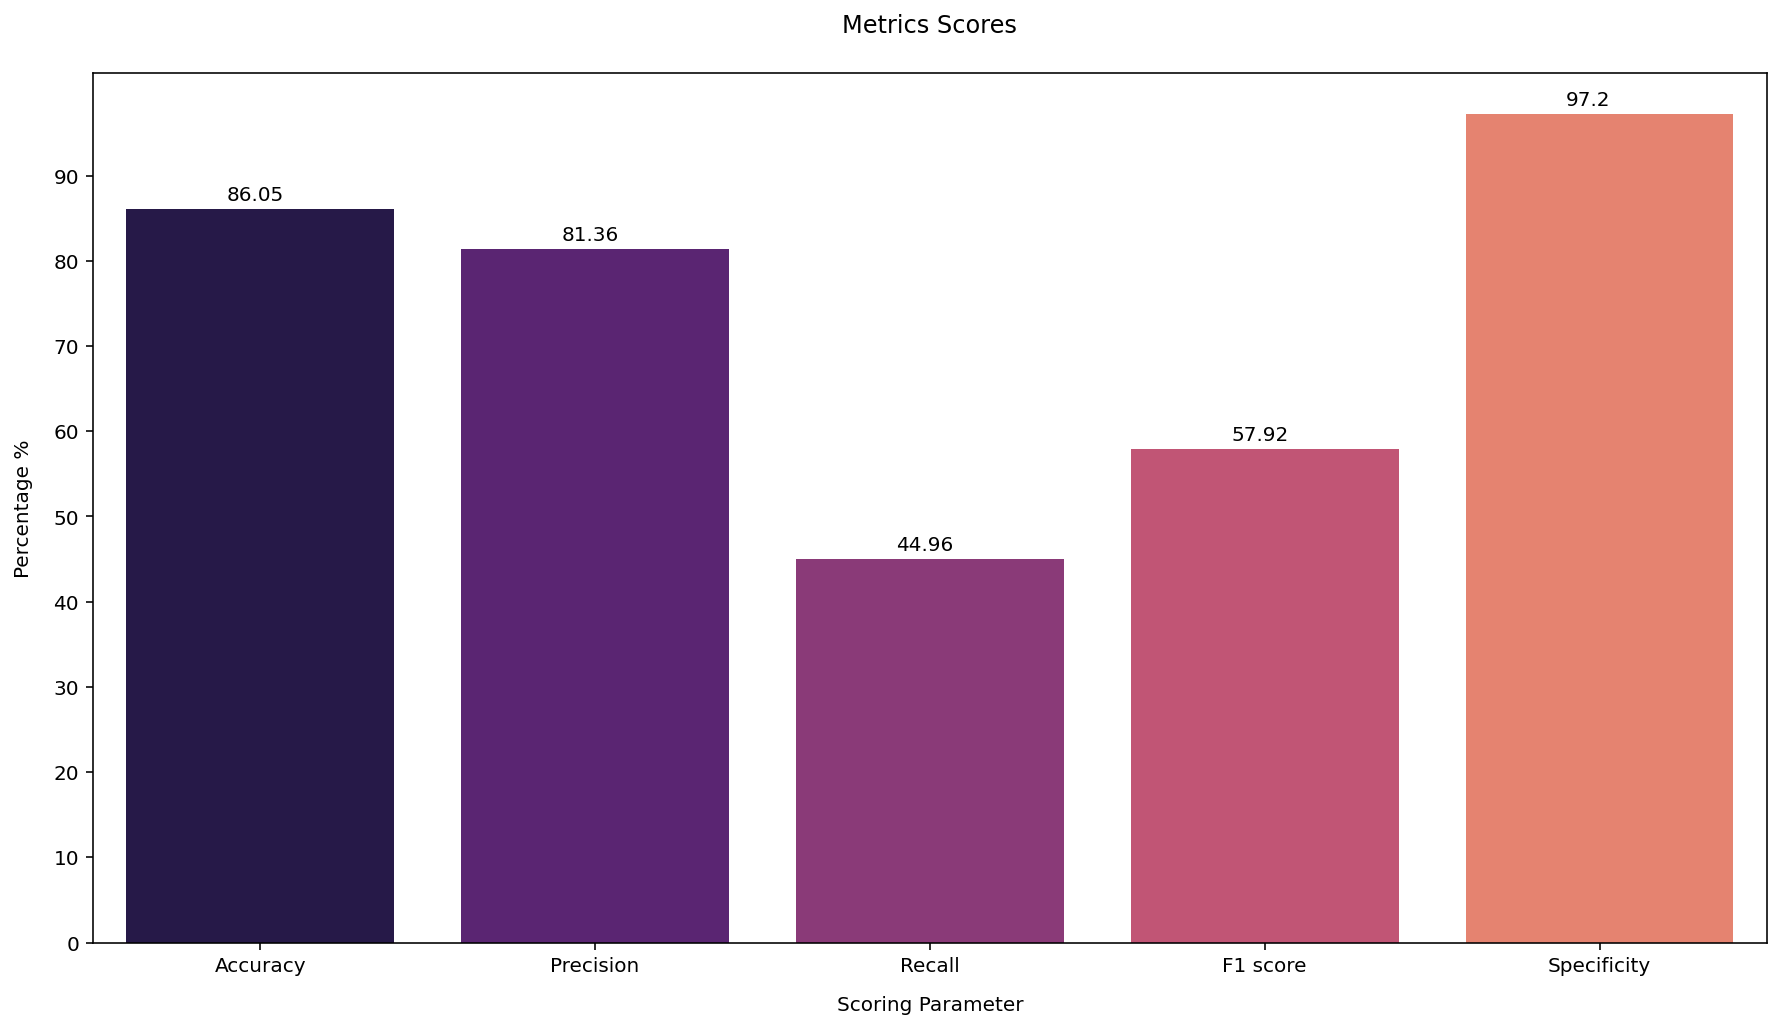

In [511]:
metrics_score(cm1)

* Plotting the average of different metrics scores for further evaluation.

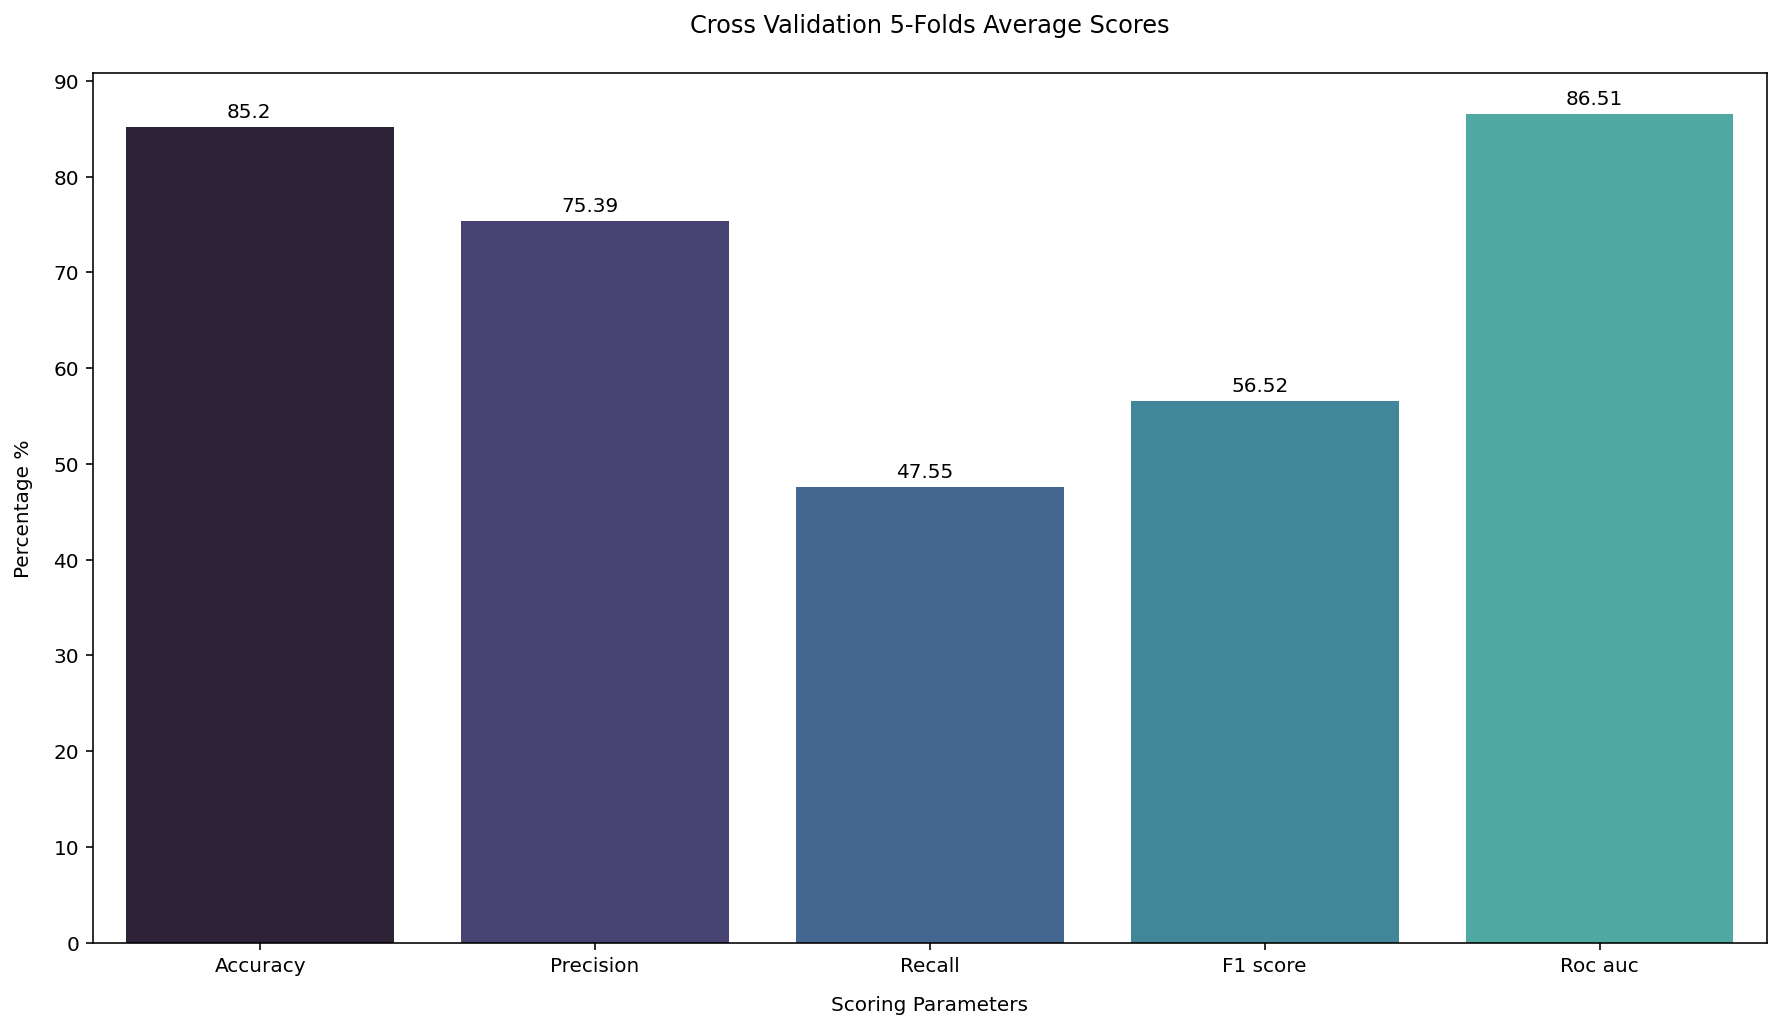

In [512]:
cv_score('Random Forests', rf_model, 5)

Plotting Receiver Operating Characteristic (ROC) Curve, to illustrate the diagnostic ability of Random Forest Classifier as its discrimination threshold is varied and showing the Area under the ROC Curve (AUC) value which will tell us how much our model is capable of distinguishing between churn und nonchurn customers.

Area under the ROC Curve (AUC): 0.87


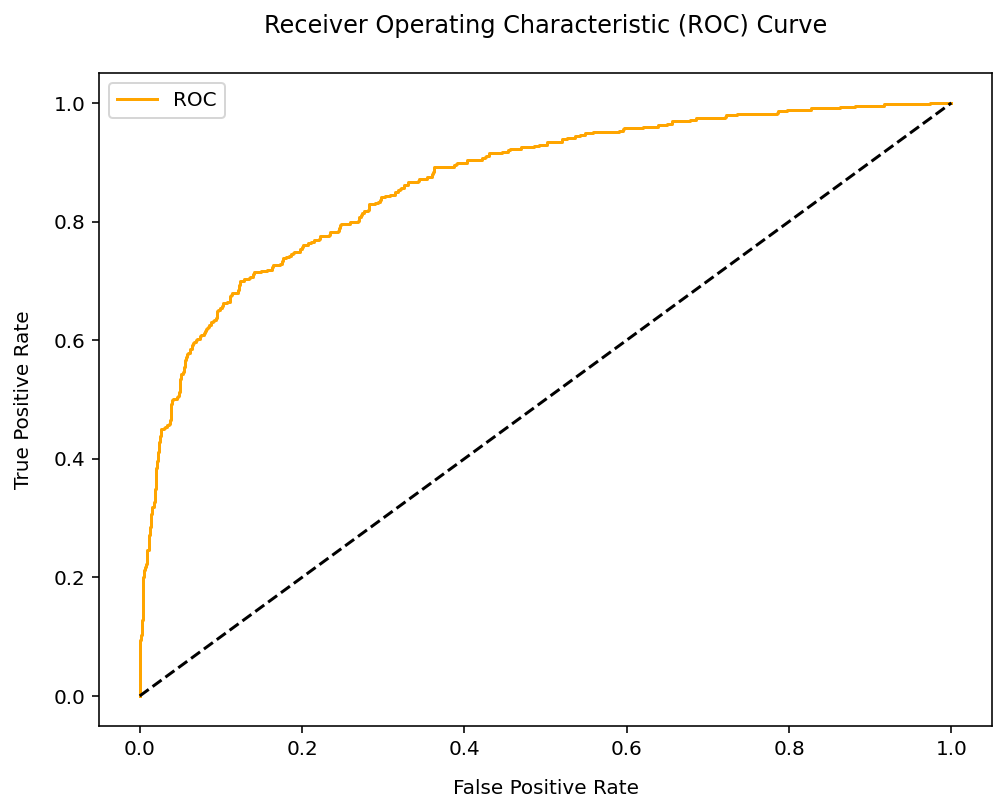

In [513]:
probs = rf_model.predict_proba(X_test)
probs = probs[:, 1]
auc5 = roc_auc_score(y_test, probs)
roc_auc['Random Forests Classifier']=np.round(auc5, 2)
print('Area under the ROC Curve (AUC): %.2f' % auc5)
fpr5, tpr5, _ = roc_curve(y_test, probs)
plot_roc_curve(fpr5, tpr5)

Plotting Precision-Recall Curve for different thresholds of precision and recall much like the ROC Curve and showing the Area under the Precision-Recall Curve (AUCPR), it gives the number summary of the information in the Precision-Recall Curve.

Area under the PR Curve (AUCPR): 0.70


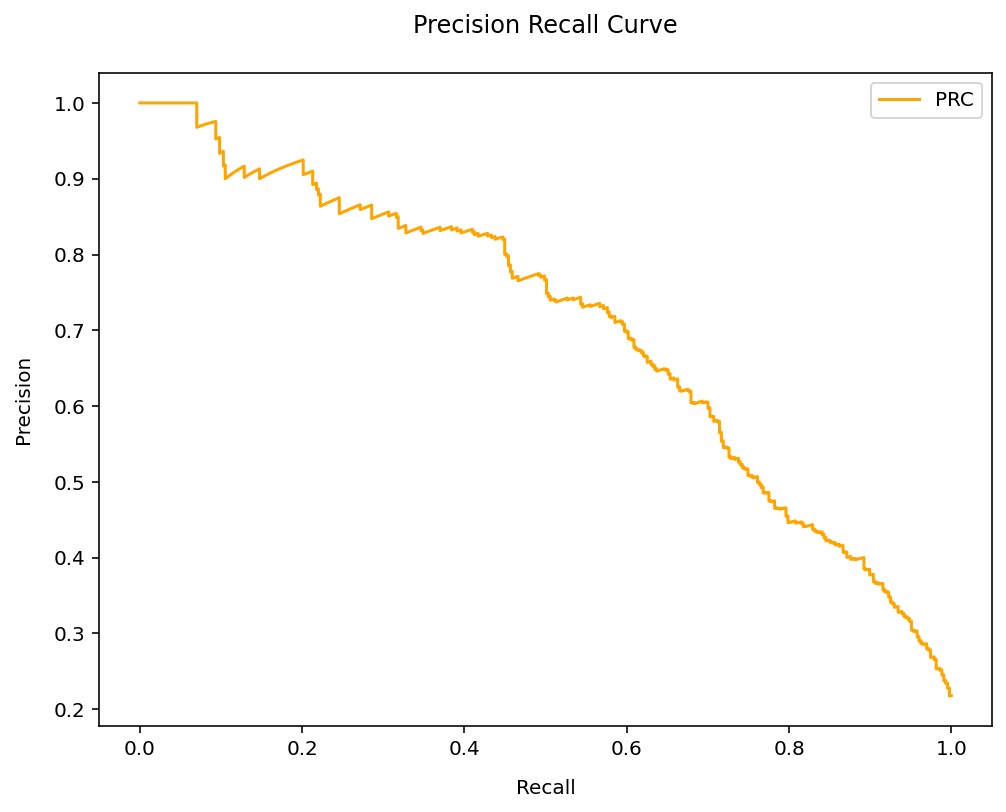

In [514]:
precision5, recall5, _ = precision_recall_curve(y_test, probs)
auc_score5 = auc(recall5, precision5)
pr_auc['Random Forests'] = np.round(auc_score5,3)
print('Area under the PR Curve (AUCPR): %.2f' % auc_score5)
plot_precision_recall_curve(recall5, precision5)

## Feature Importance

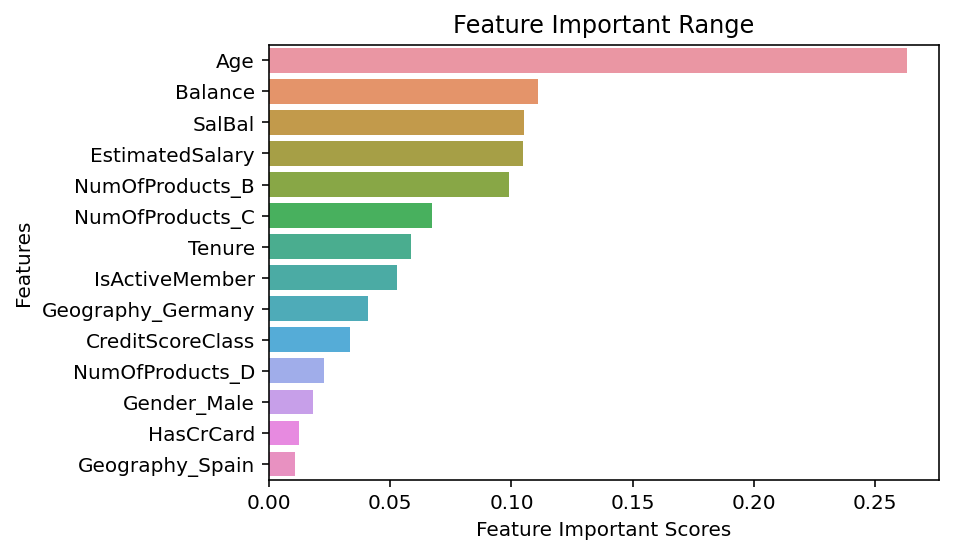

In [515]:
feature_imp = pd.Series(rf_model.feature_importances_,
                        index = X_train.columns).sort_values(ascending = False)

sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Feature Important Scores')
plt.ylabel('Features')
plt.title("Feature Important Range")
plt.show()

## Gradient Boosting Machines

In [516]:
y = df_1['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
gbm_model = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 5, n_estimators = 300)
gbm_model.fit(X_train, y_train)
prediction6 = gbm_model.predict(X_test)
accuracy6 = gbm_model.score(X_test, y_test) 
print ('Model Accuracy:',accuracy6 * 100)

Model Accuracy: 85.1


Storing model accuracy to plot for comparison with other Machine Learning models.

In [518]:
accuracies['Gradient Boosting Machines'] = np.round(accuracy6 * 100, 2)

1. Plotting Confusion Matrix to describe the performance of GBM Classifier on a set of test data.

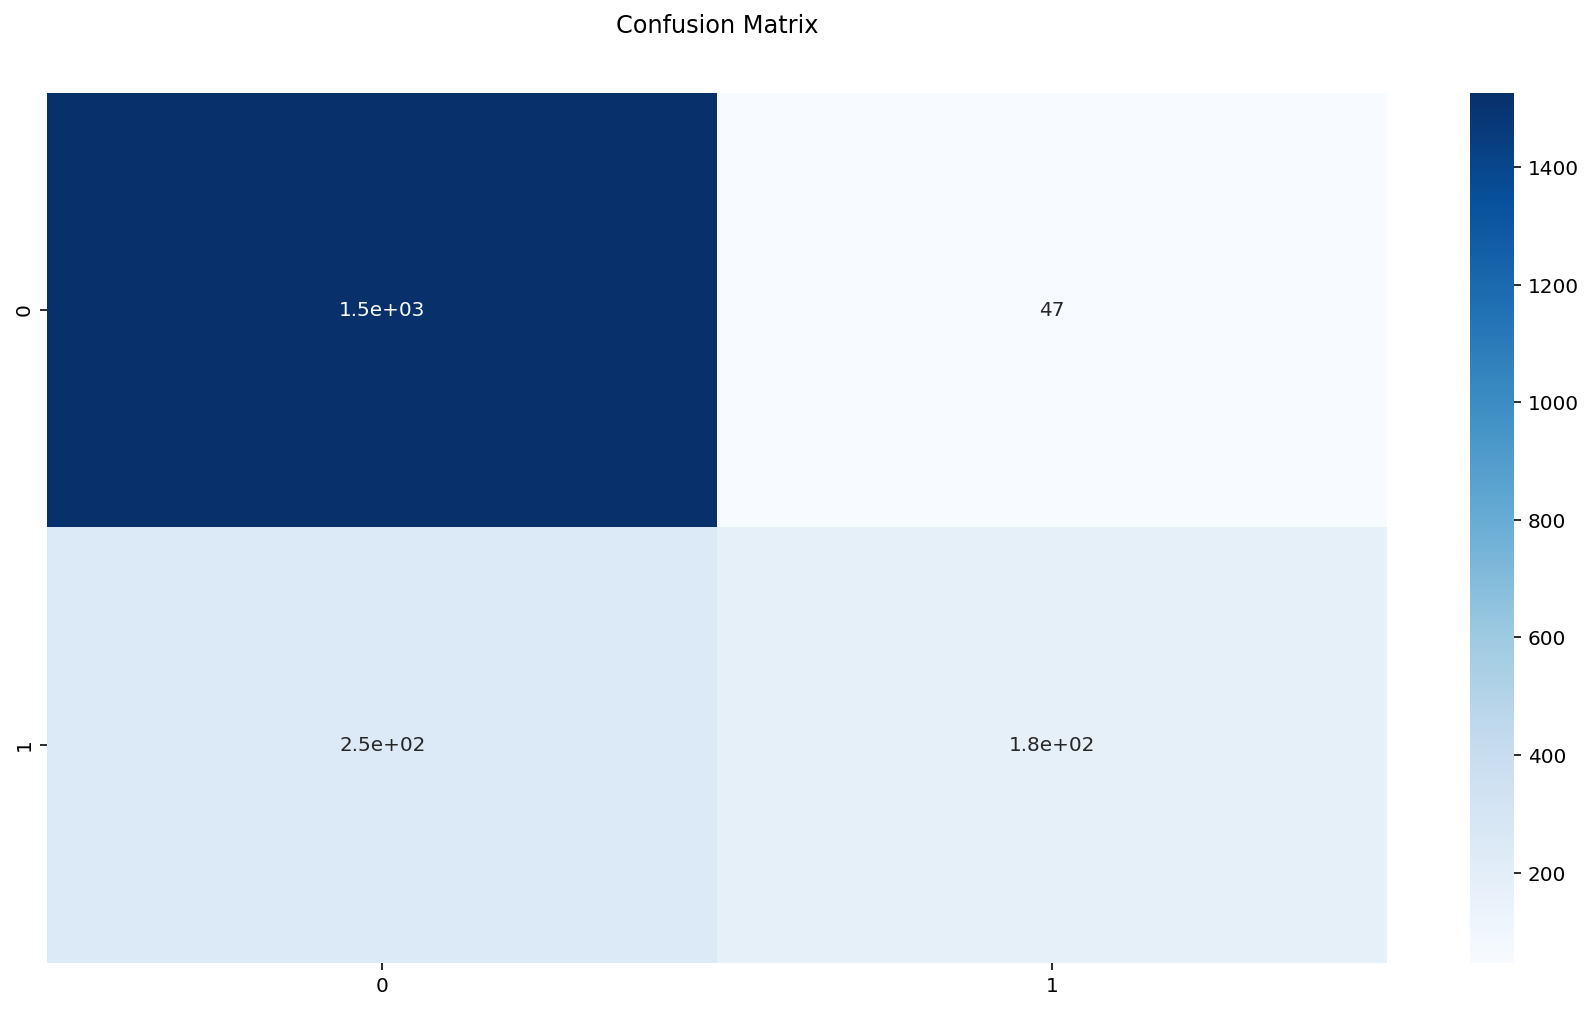

In [519]:
conf_matrix(y_test, prediction6)

Plotting different metrics scores for the GBM Classifier for evaluation.

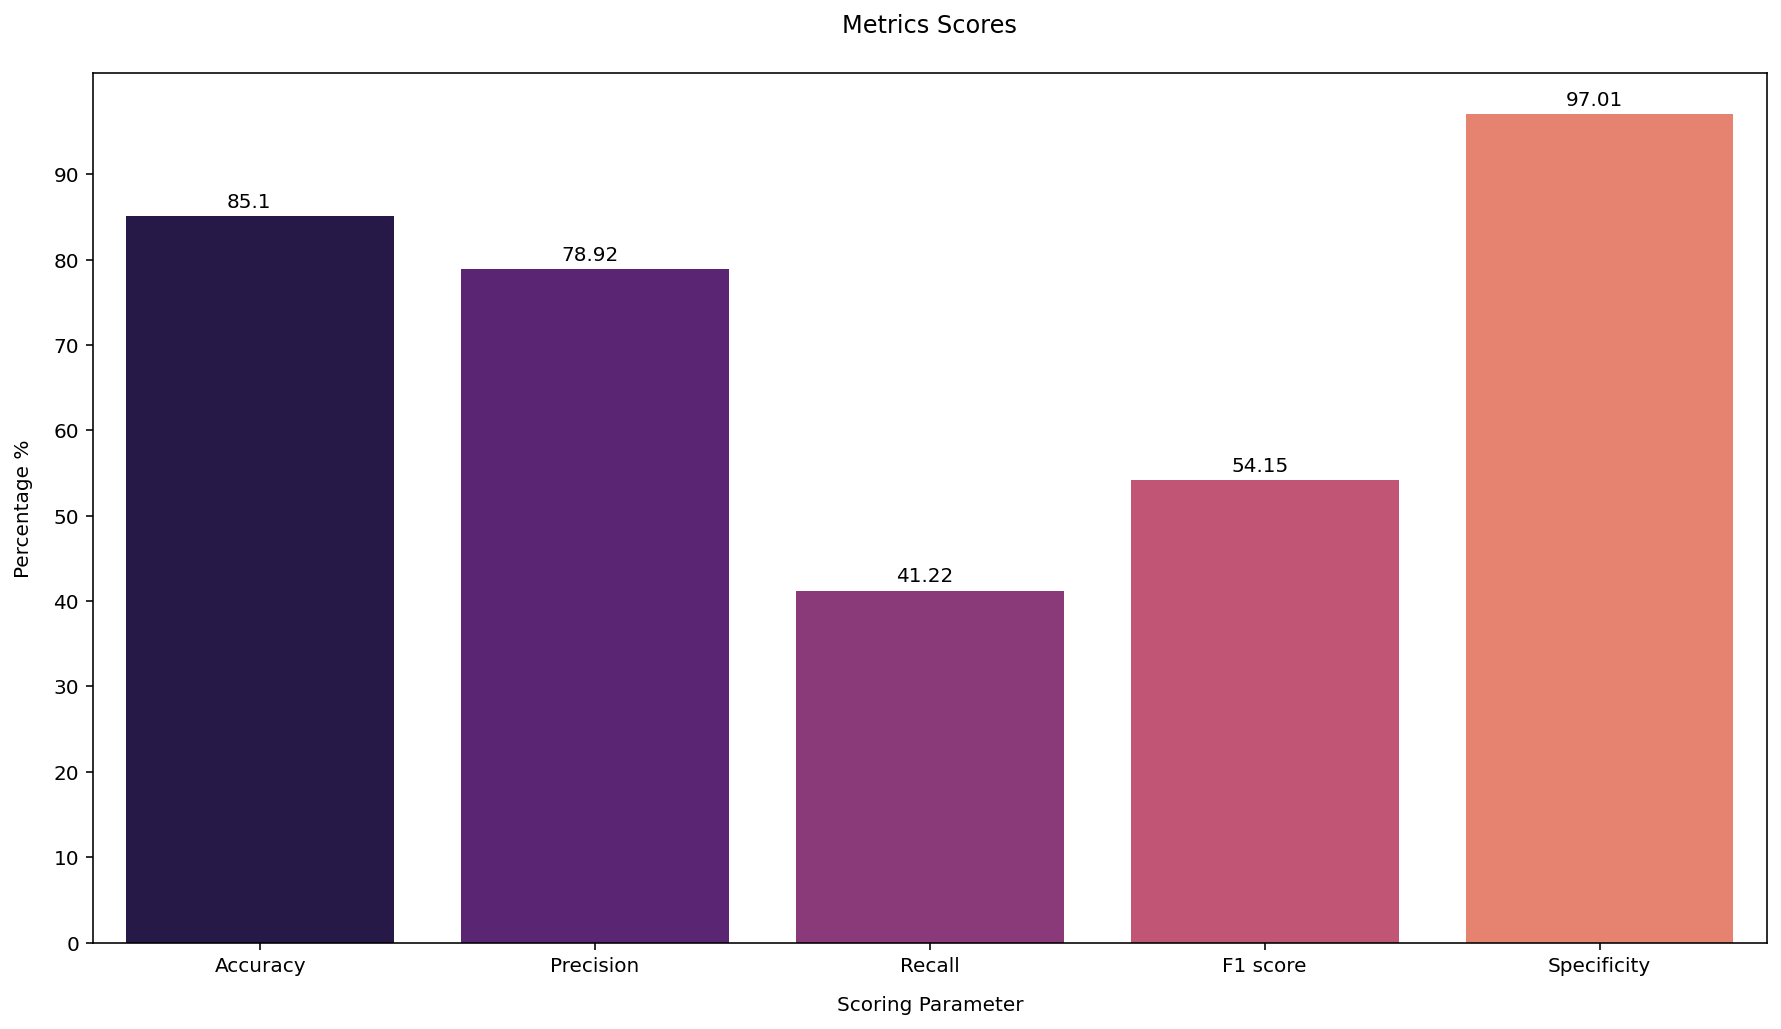

In [520]:
metrics_score(cm1)

* Plotting the average of different metrics scores for further evaluation.

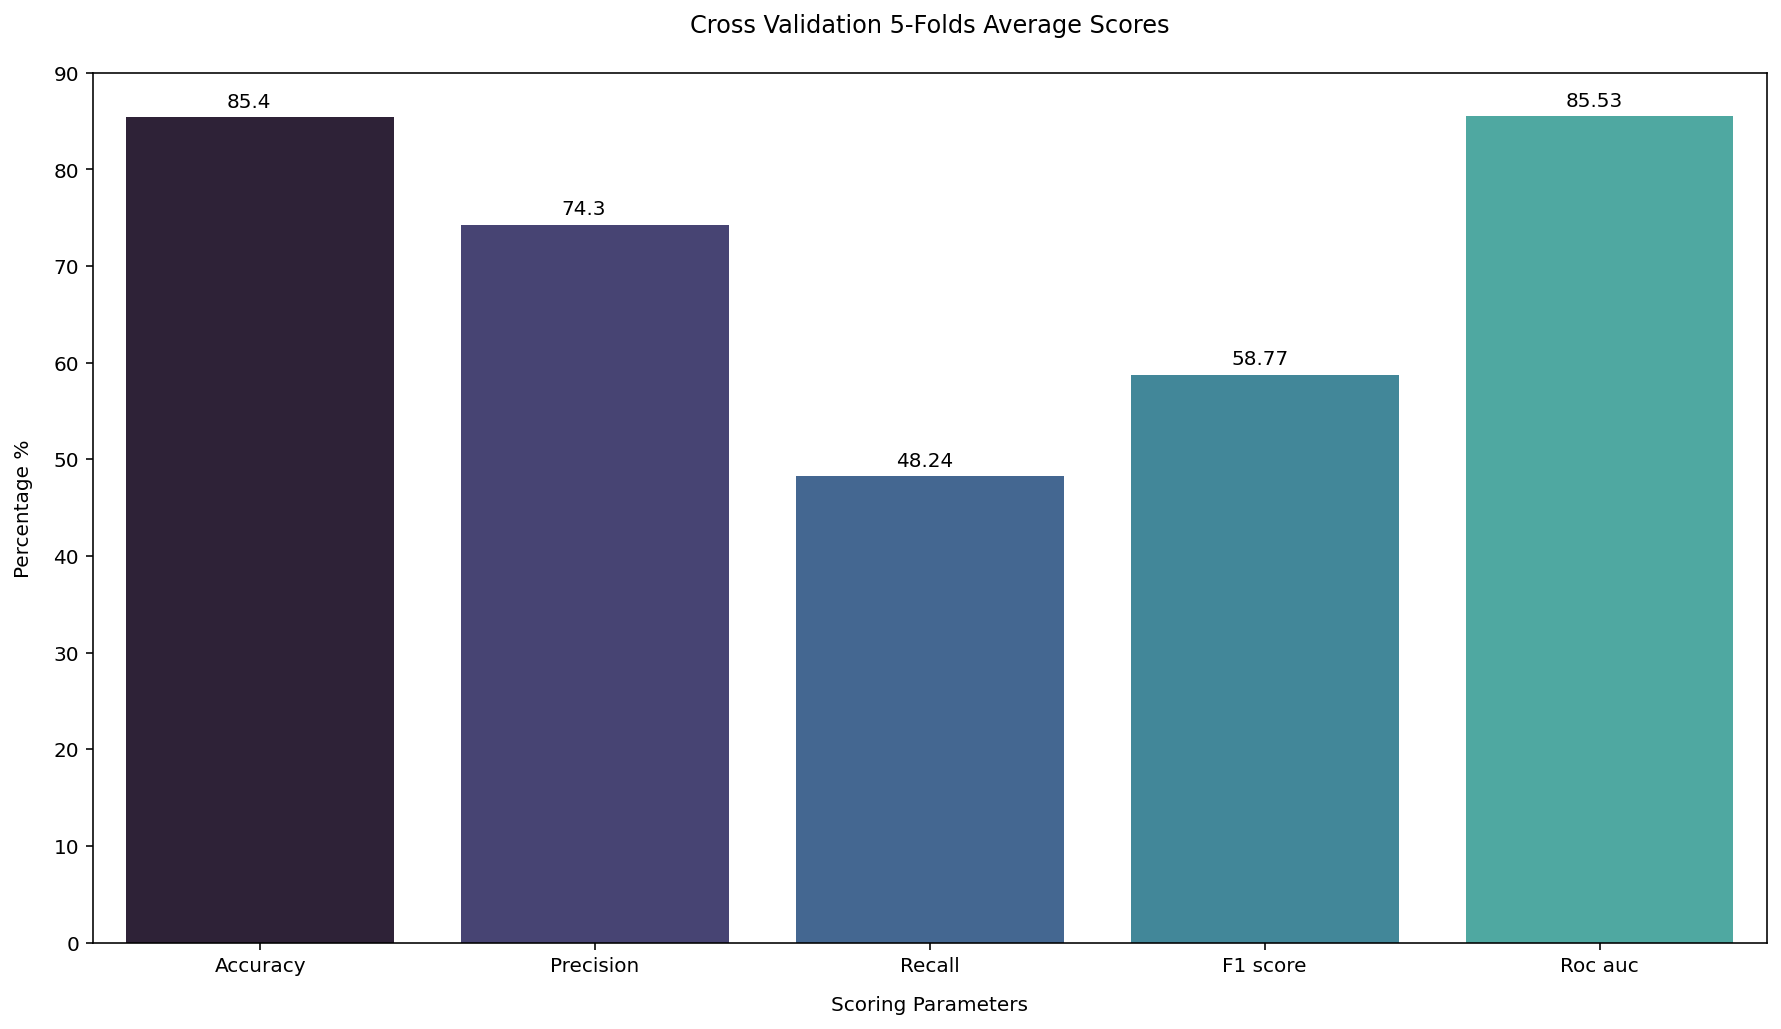

In [521]:
cv_score('Gradient Boosting Machines', gbm_model, 5)

Plotting Receiver Operating Characteristic (ROC) Curve, to illustrate the diagnostic ability of GBM Classifier as its discrimination threshold is varied and showing the Area under the ROC Curve (AUC) value which will tell us how much our model is capable of distinguishing between churn und nonchurn customers.

Area under the ROC Curve (AUC): 0.88


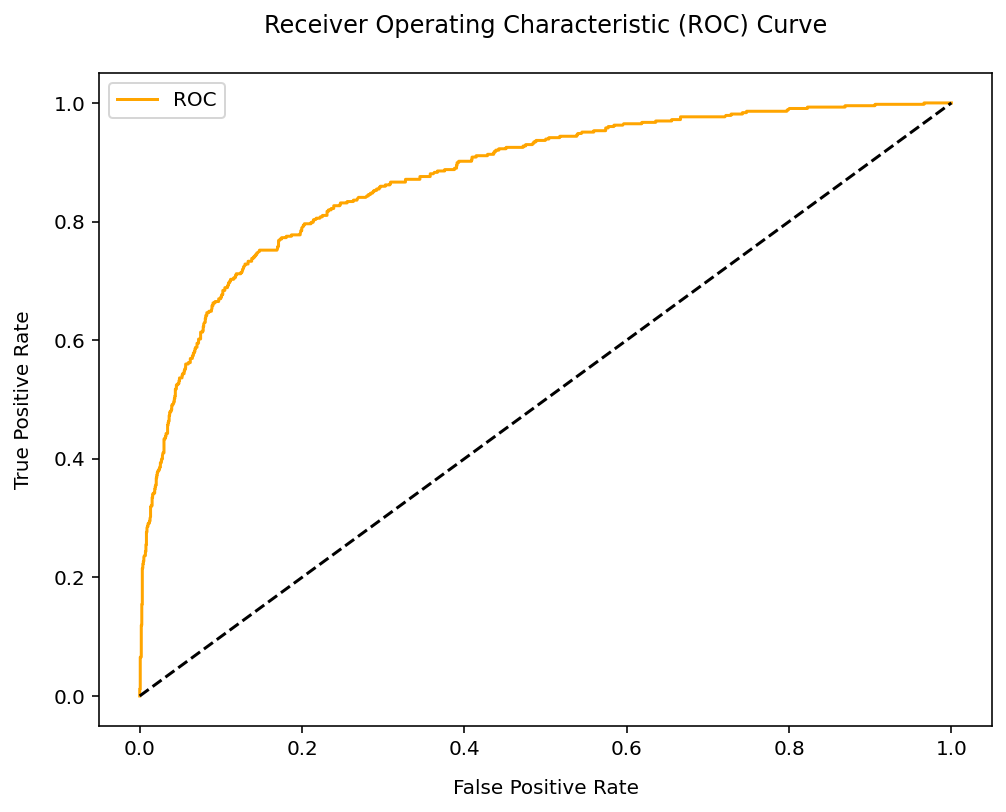

In [522]:
probs = gbm_model.predict_proba(X_test)
probs = probs[:, 1]
auc6 = roc_auc_score(y_test, probs)
roc_auc['Gradient Boosting Machine Classifier'] = np.round(auc6, 2)
print('Area under the ROC Curve (AUC): %.2f' % auc6)
fpr6, tpr6, _ = roc_curve(y_test, probs)
plot_roc_curve(fpr6, tpr6)

Plotting Precision-Recall Curve for different thresholds of precision and recall much like the ROC Curve and showing the Area under the Precision-Recall Curve (AUCPR), it gives the number summary of the information in the Precision-Recall Curve.

Area under the PR Curve (AUCPR): 0.71


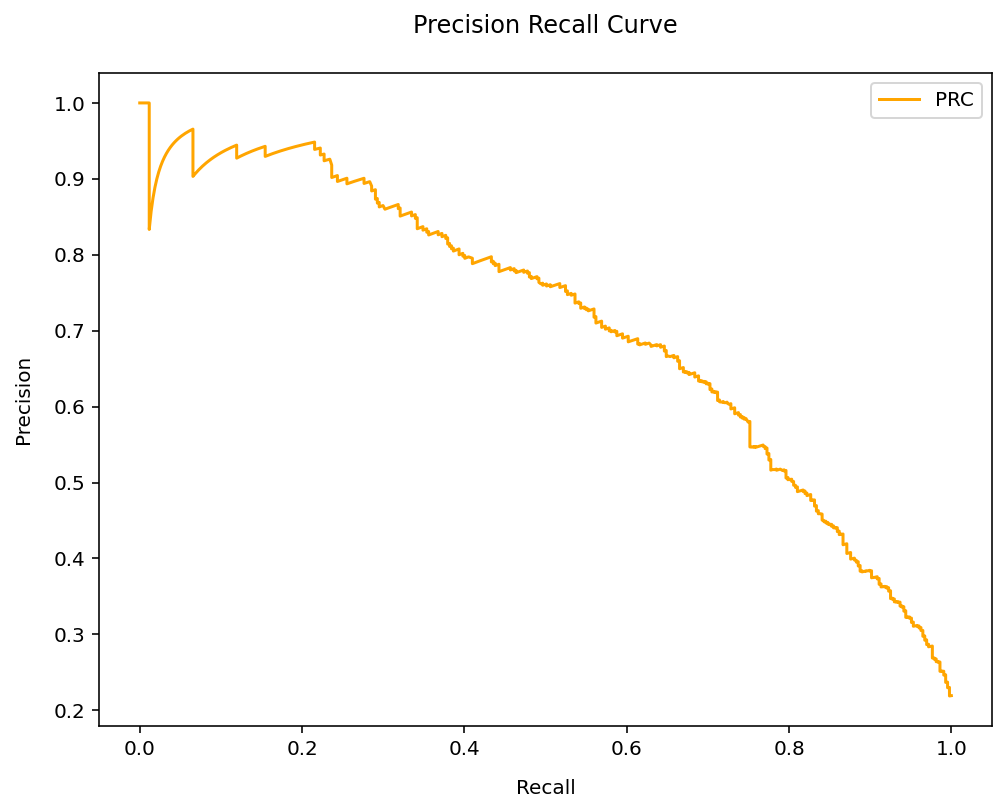

In [523]:
precision6, recall6, _ = precision_recall_curve(y_test, probs)
auc_score6 = auc(recall6, precision6)
pr_auc['Gradient Boosting Machine Classifier'] = np.round(auc_score6, 2)
print('Area under the PR Curve (AUCPR): %.2f' % auc_score6)
plot_precision_recall_curve(recall6, precision6)

## Feature Importance

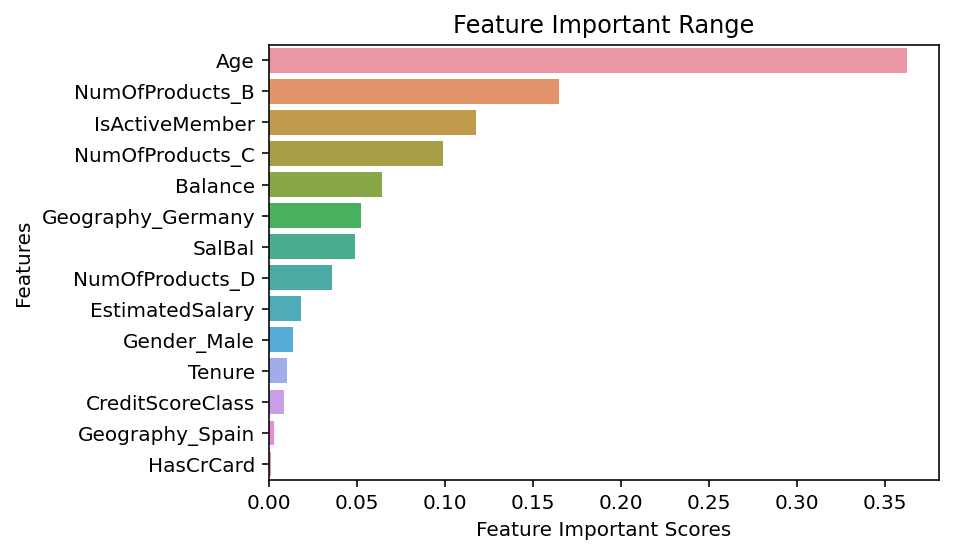

In [524]:
feature_imp = pd.Series(gbm_model.feature_importances_,
                        index = X_train.columns).sort_values(ascending = False)

sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Feature Important Scores')
plt.ylabel('Features')
plt.title("Feature Important Range")
plt.show()

## XGBoost

In [525]:
y = df_1['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
xgb_model = XGBClassifier(learning_rate = 0.01, max_depth = 5, n_estimators = 1000, subsample = 0.8)
xgb_model.fit(X_train, y_train)
prediction7 = xgb_model.predict(X_test)
accuracy7 = xgb_model.score(X_test, y_test) 
print ('Model Accuracy:',accuracy7 * 100)

Model Accuracy: 86.3


In [526]:
#xgb_params = {"n_estimators": [100, 500, 1000], "subsample":[0.5, 0.8 ,1], "max_depth":[3, 5, 7], "learning_rate":[0.1, 0.001, 0.01, 0.05]}
#xgb_cv_model = GridSearchCV(xgb_model, xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train, y_train)
#xgb_cv_model.best_params_

Storing model accuracy to plot for comparison with other Machine Learning models.

In [527]:
accuracies['XGBoost Classifier'] = np.round(accuracy7 * 100, 2)

1. Plotting Confusion Matrix to describe the performance of XGBM Classifier on a set of test data.

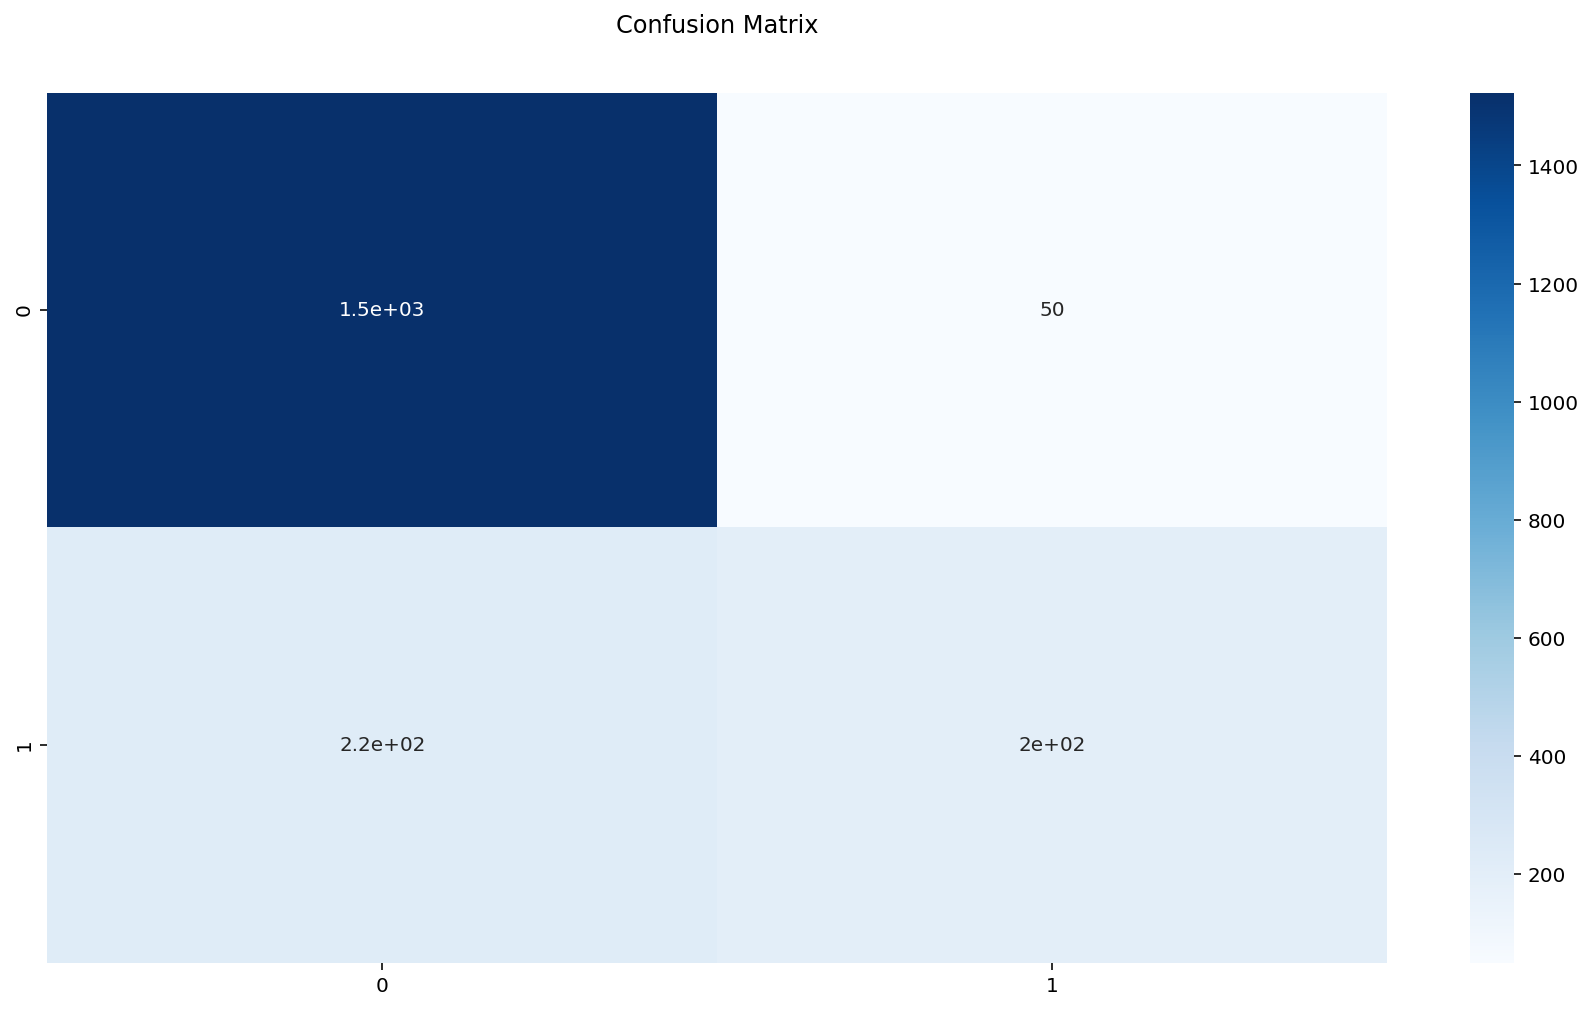

In [528]:
conf_matrix(y_test, prediction7)

Plotting different metrics scores for the XGBM Classifier for evaluation.

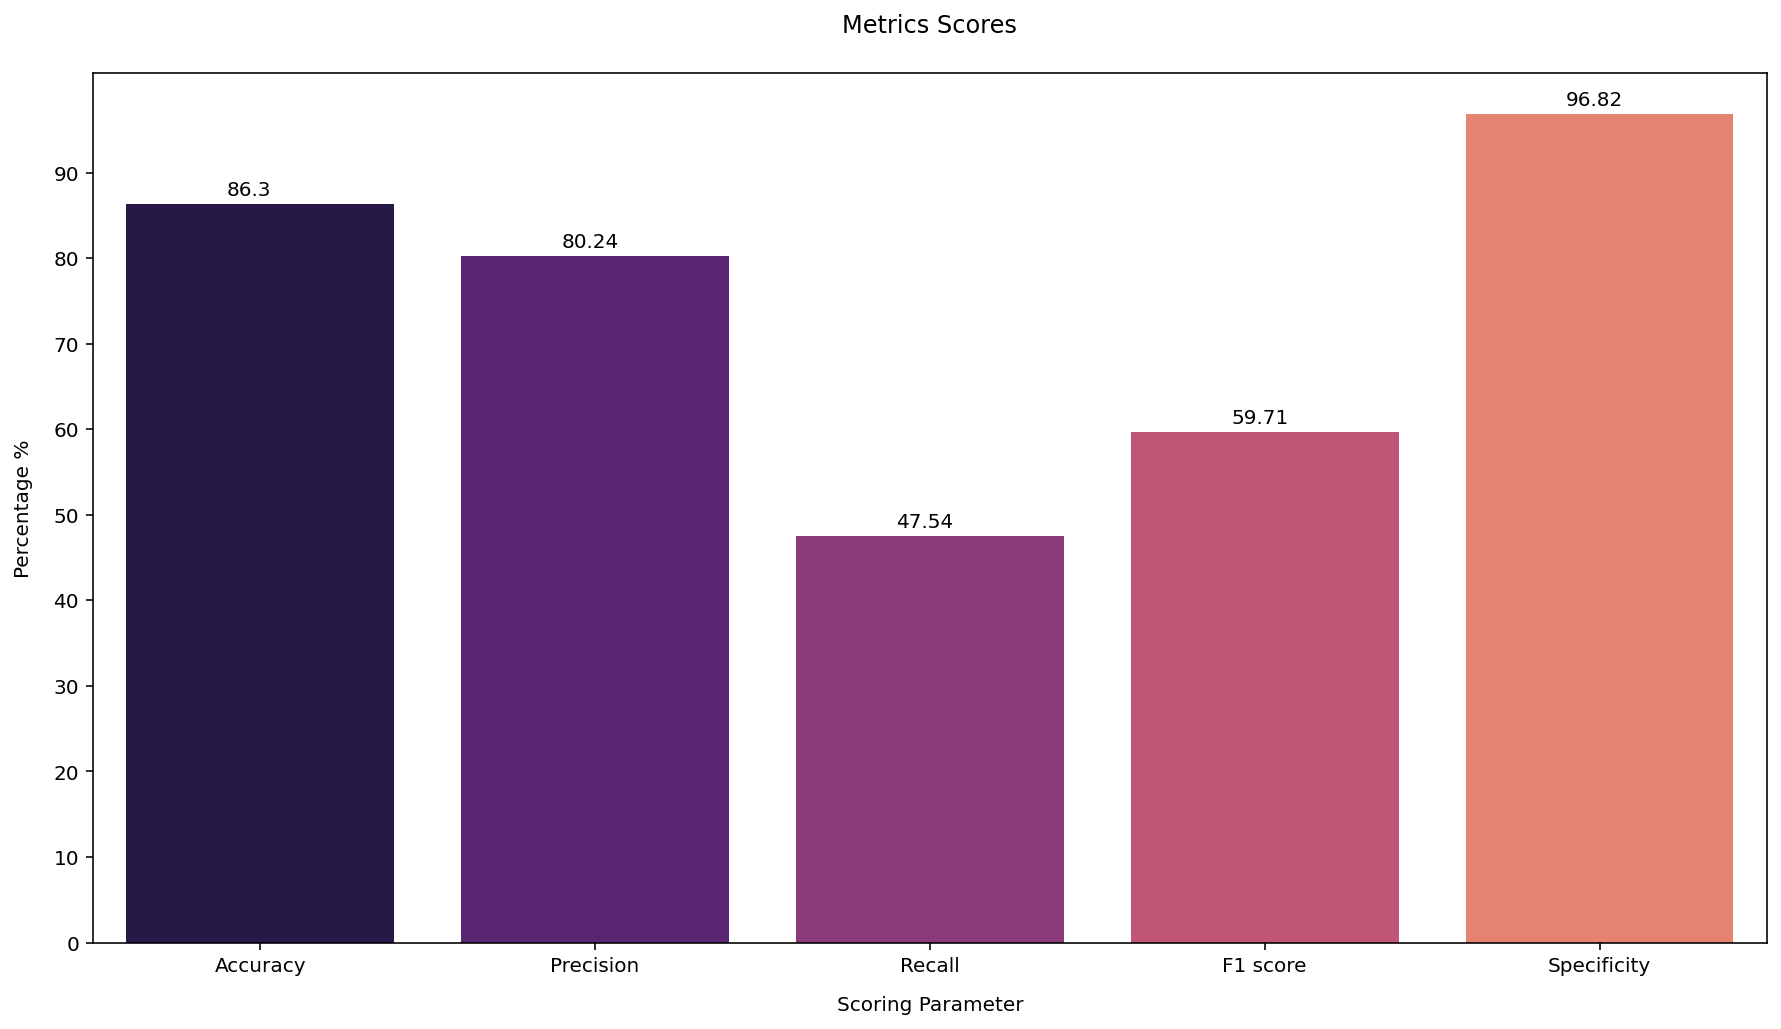

In [529]:
metrics_score(cm1)

* Plotting the average of different metrics scores for further evaluation.

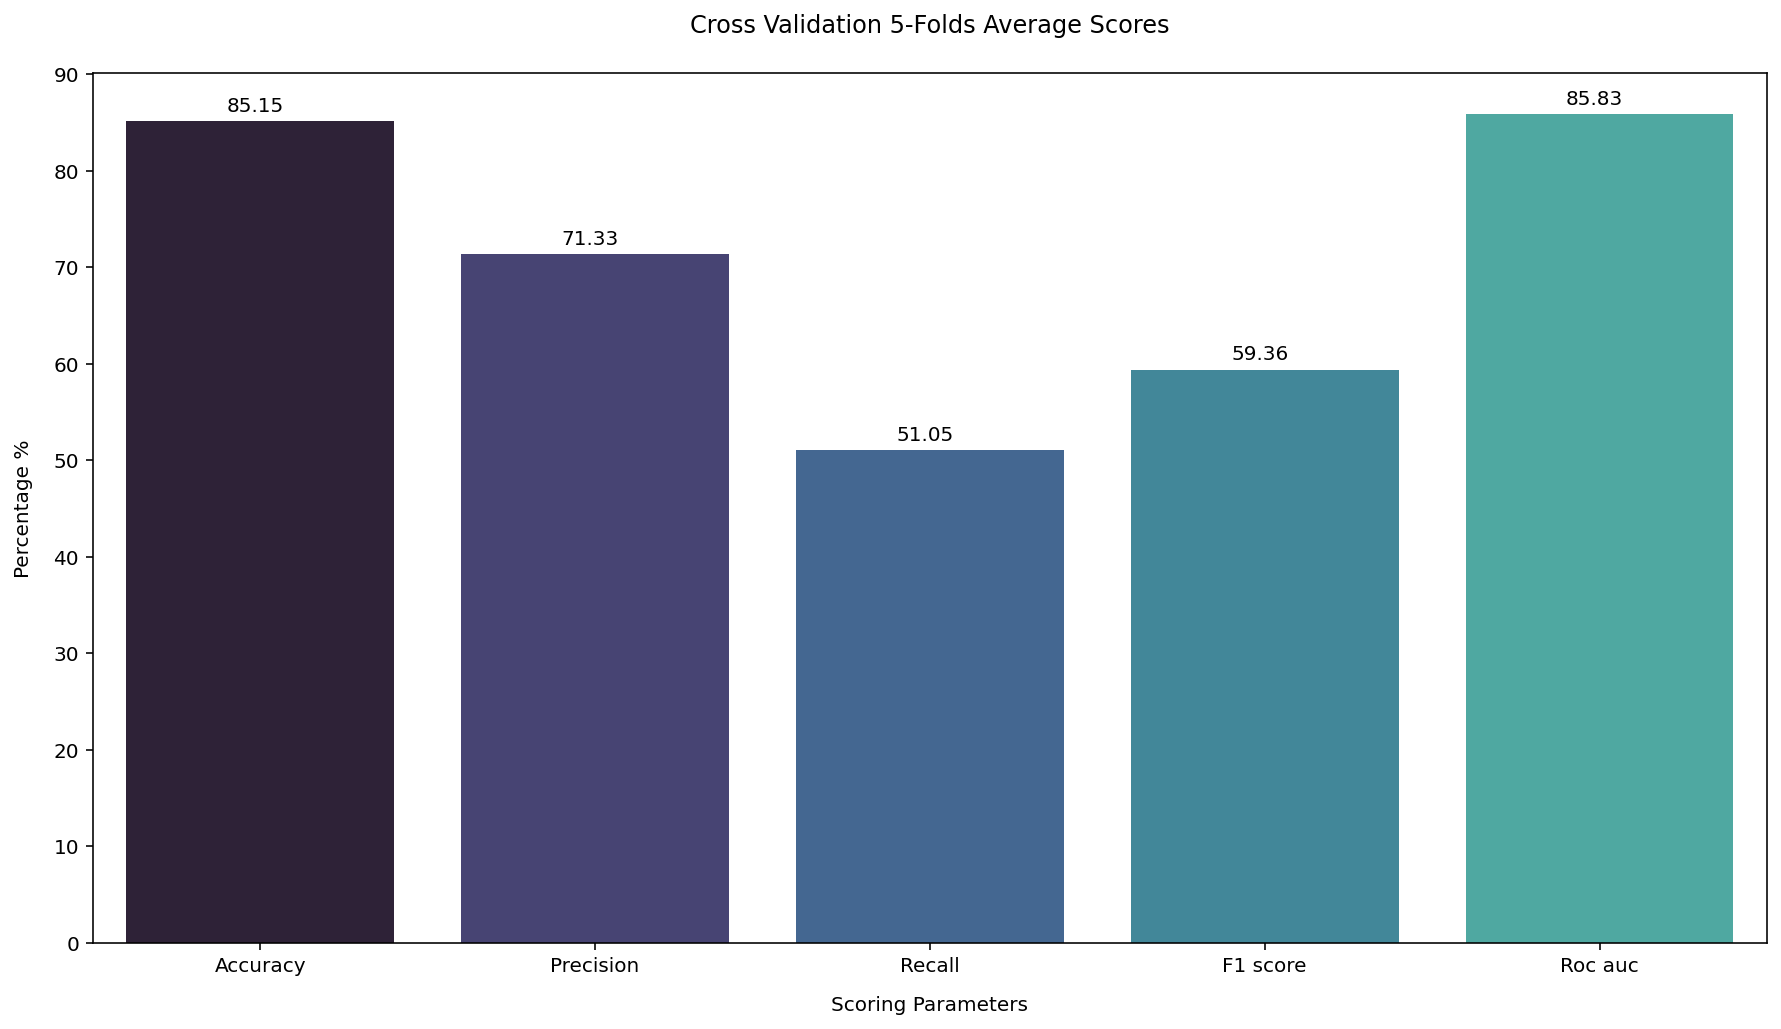

In [530]:
cv_score('XGBoost Classifier', xgb_model, 5)

Plotting Receiver Operating Characteristic (ROC) Curve, to illustrate the diagnostic ability of XGBM Classifier as its discrimination threshold is varied and showing the Area under the ROC Curve (AUC) value which will tell us how much our model is capable of distinguishing between churn und nonchurn customers.

Area under the ROC Curve (AUC): 0.88


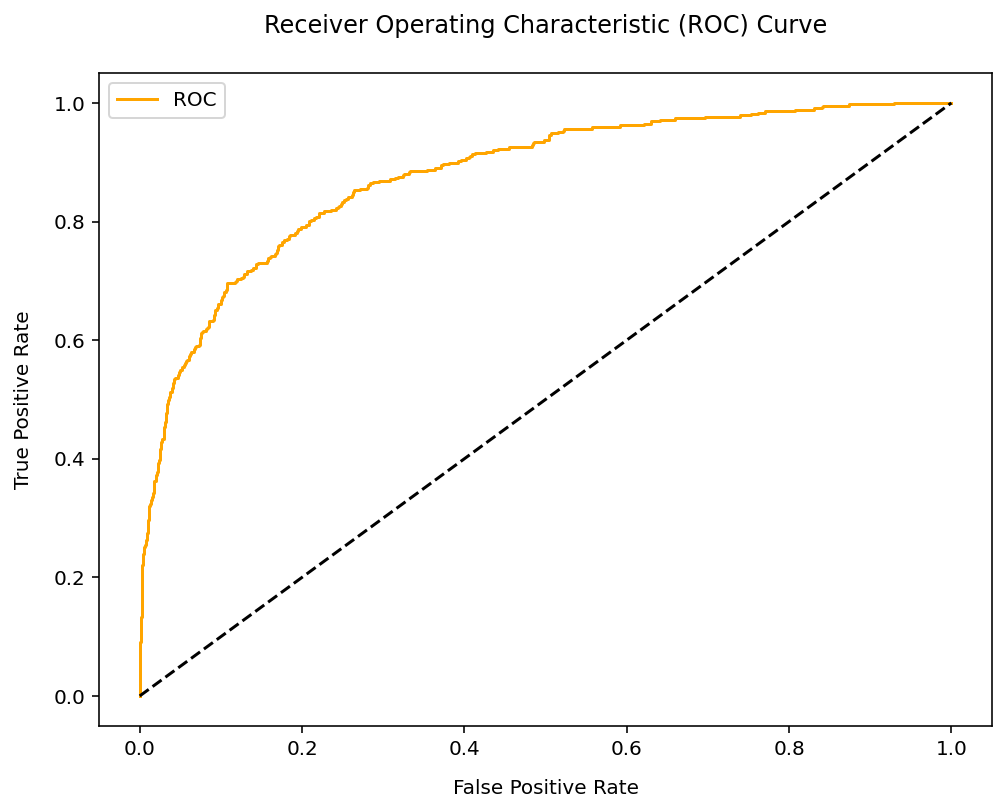

In [531]:
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]
auc7 = roc_auc_score(y_test, probs)
roc_auc['XGB Machine Classifier']=np.round(auc7, 2)
print('Area under the ROC Curve (AUC): %.2f' % auc7)
fpr7, tpr7, _ = roc_curve(y_test, probs)
plot_roc_curve(fpr7, tpr7)

Plotting Precision-Recall Curve for different thresholds of precision and recall much like the ROC Curve and showing the Area under the Precision-Recall Curve (AUCPR), it gives the number summary of the information in the Precision-Recall Curve.

Area under the PR Curve (AUCPR): 0.72


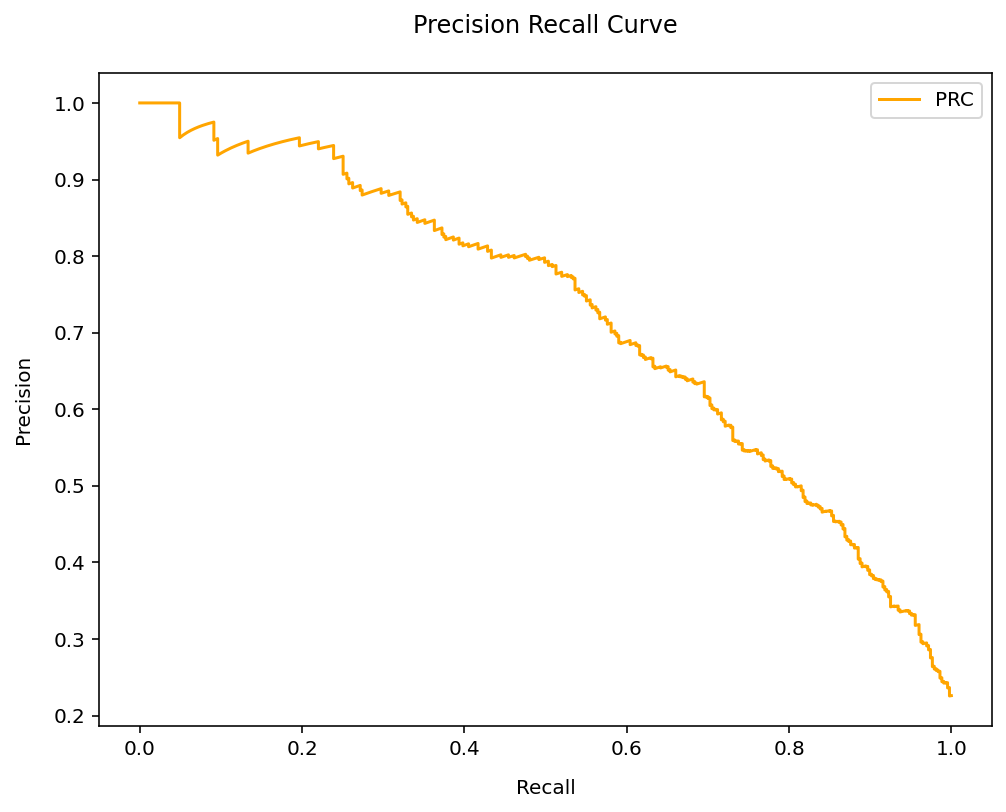

In [532]:
precision7, recall7, _ = precision_recall_curve(y_test, probs)
auc_score7 = auc(recall7, precision7)
pr_auc['XGB Machine Classifier'] = np.round(auc_score7, 2)
print('Area under the PR Curve (AUCPR): %.2f' % auc_score7)
plot_precision_recall_curve(recall7, precision7)

## Feature Importance

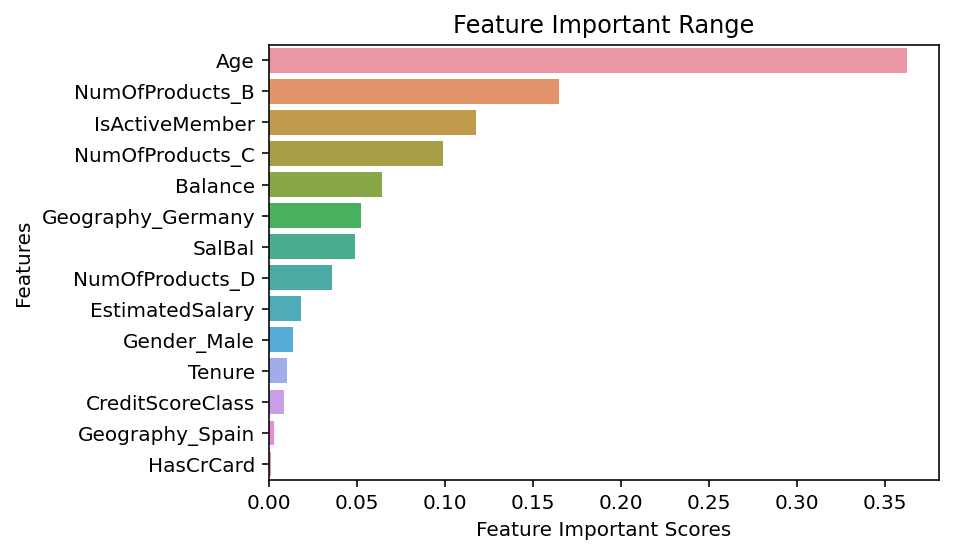

In [533]:
feature_imp = pd.Series(gbm_model.feature_importances_,
                        index = X_train.columns).sort_values(ascending = False)

sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Feature Important Scores')
plt.ylabel('Features')
plt.title("Feature Important Range")
plt.show()

## Light GBM

In [534]:
y = df_1['Exited']
X = df_2.drop('Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345)
lgbm_model = LGBMClassifier(learning_rate = 0.1, max_depth = 2, n_estimators = 500)
lgbm_model.fit(X_train, y_train)
prediction8 = lgbm_model.predict(X_test)
accuracy8 = lgbm_model.score(X_test, y_test) 
print ('Model Accuracy:',accuracy8 * 100)

Model Accuracy: 85.8


Storing model accuracy to plot for comparison with other Machine Learning models.

In [536]:
accuracies['LightGBM Classifier'] = np.round(accuracy8 * 100, 2)

1. Plotting Confusion Matrix to describe the performance of LGBM Classifier on a set of test data.

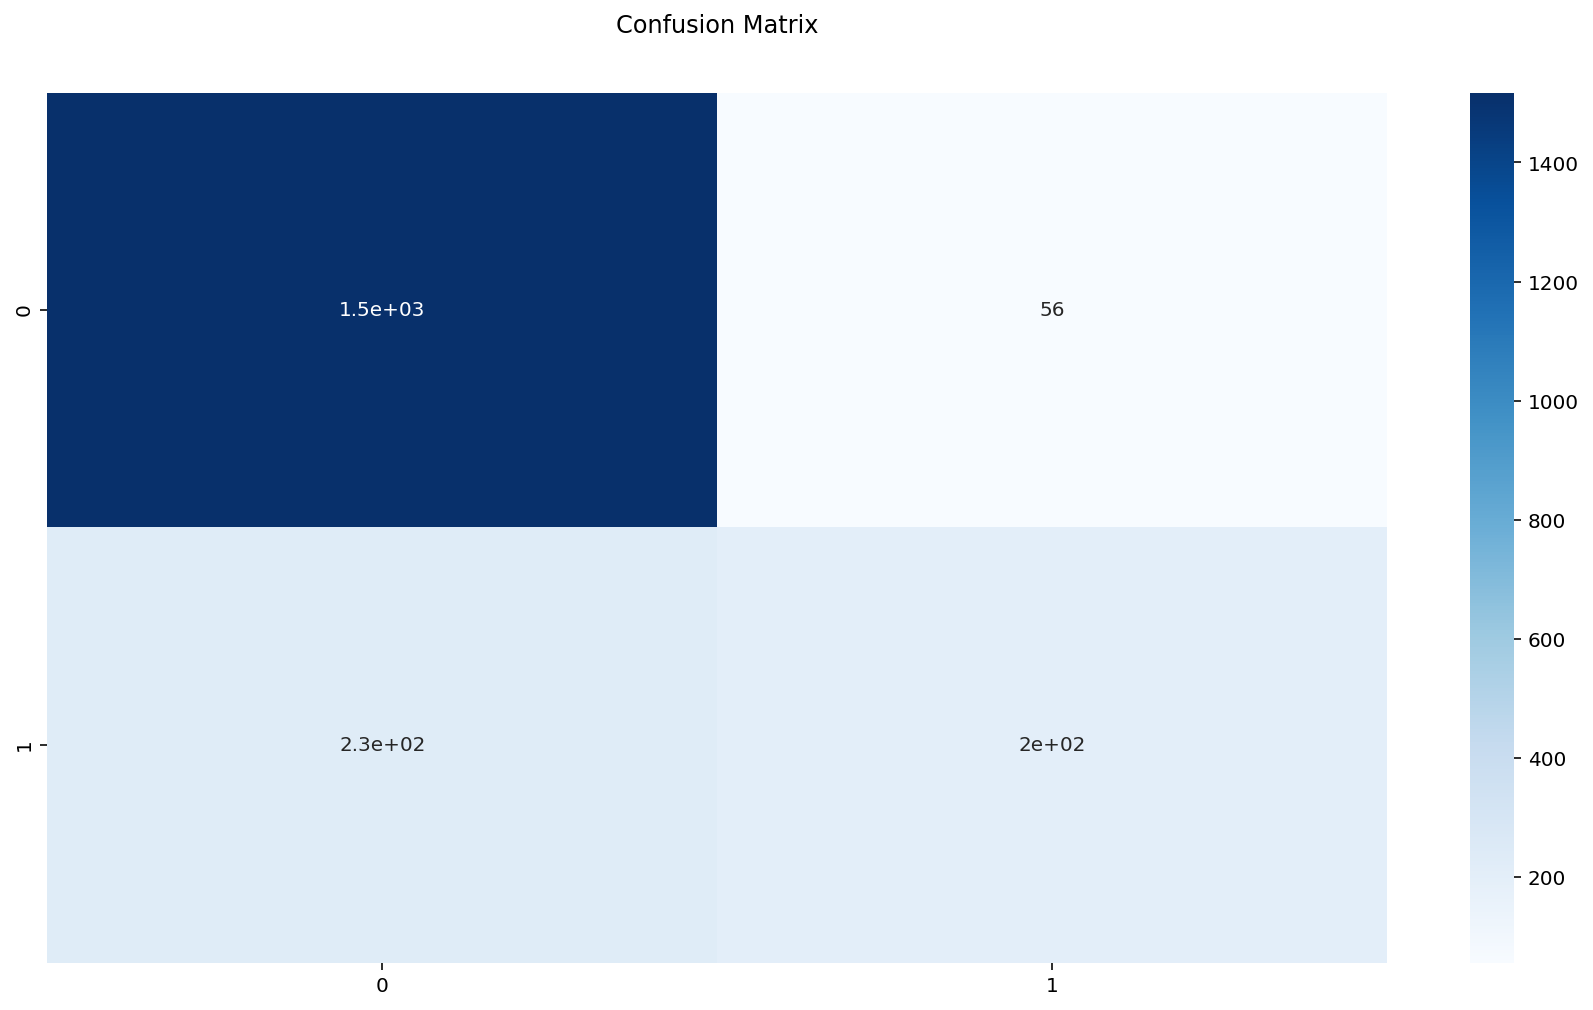

In [537]:
conf_matrix(y_test, prediction8)

Plotting different metrics scores for the LGBM Classifier for evaluation.

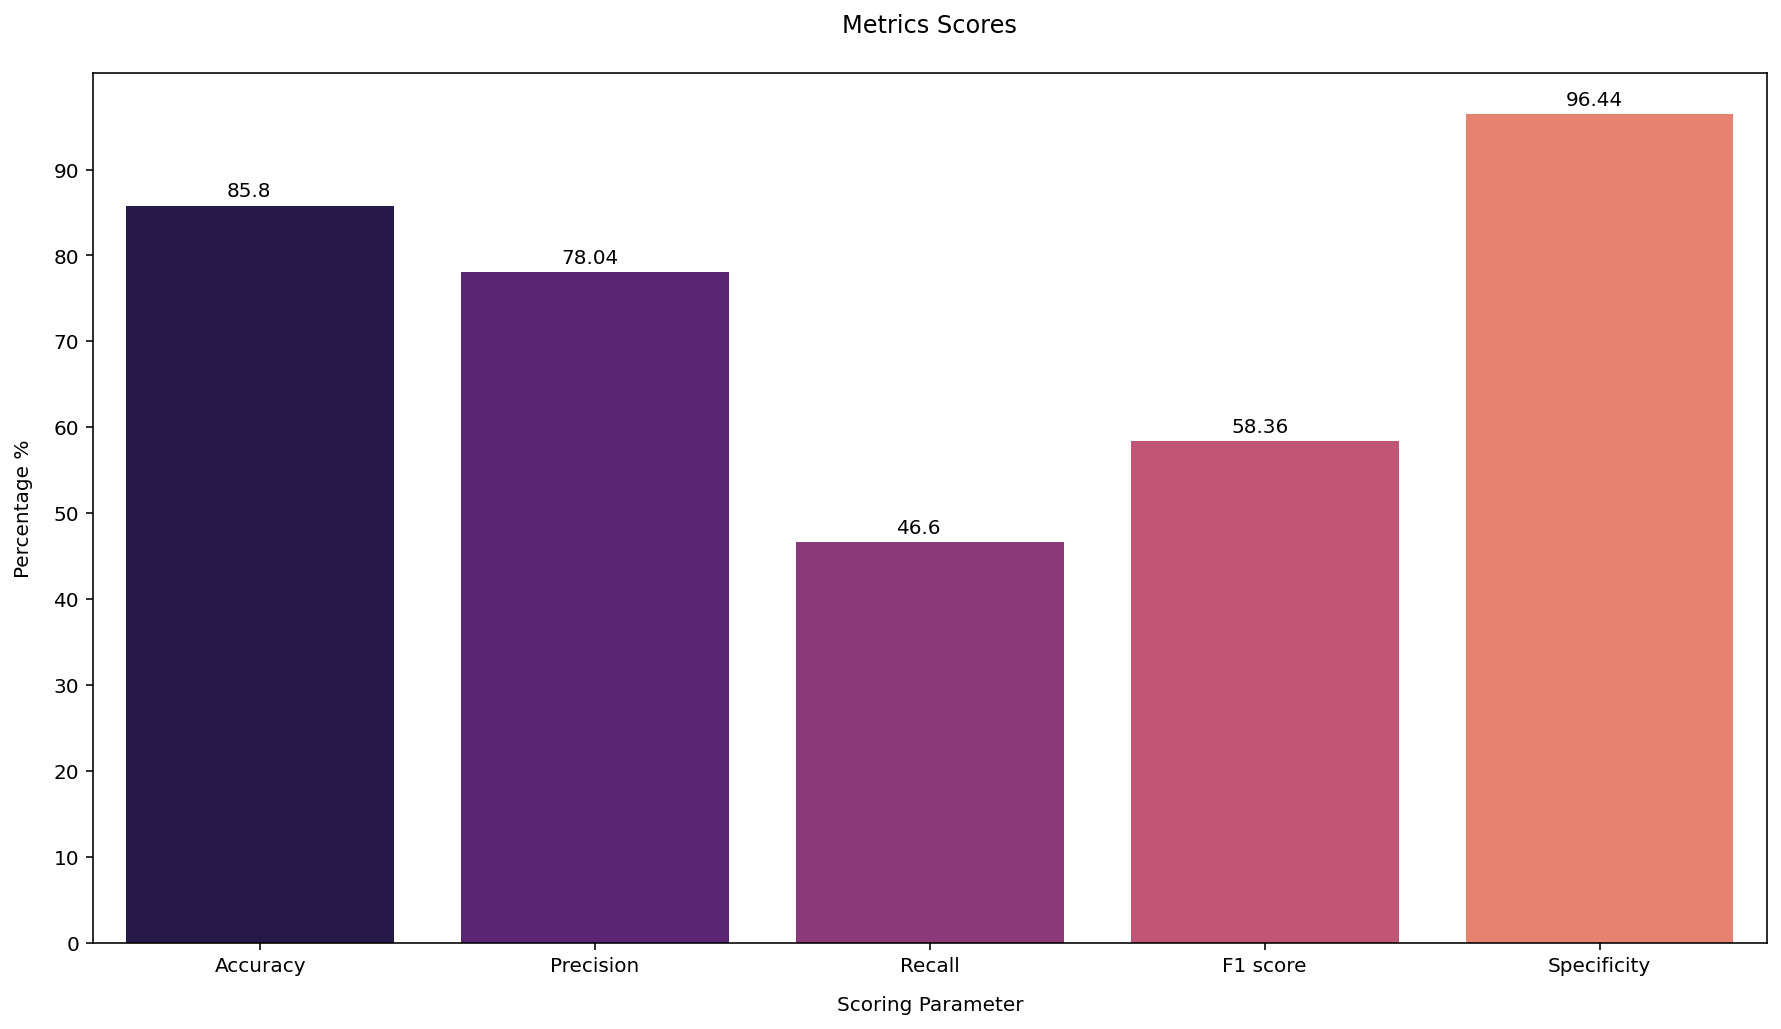

In [538]:
metrics_score(cm1)

* Plotting the average of different metrics scores for further evaluation.

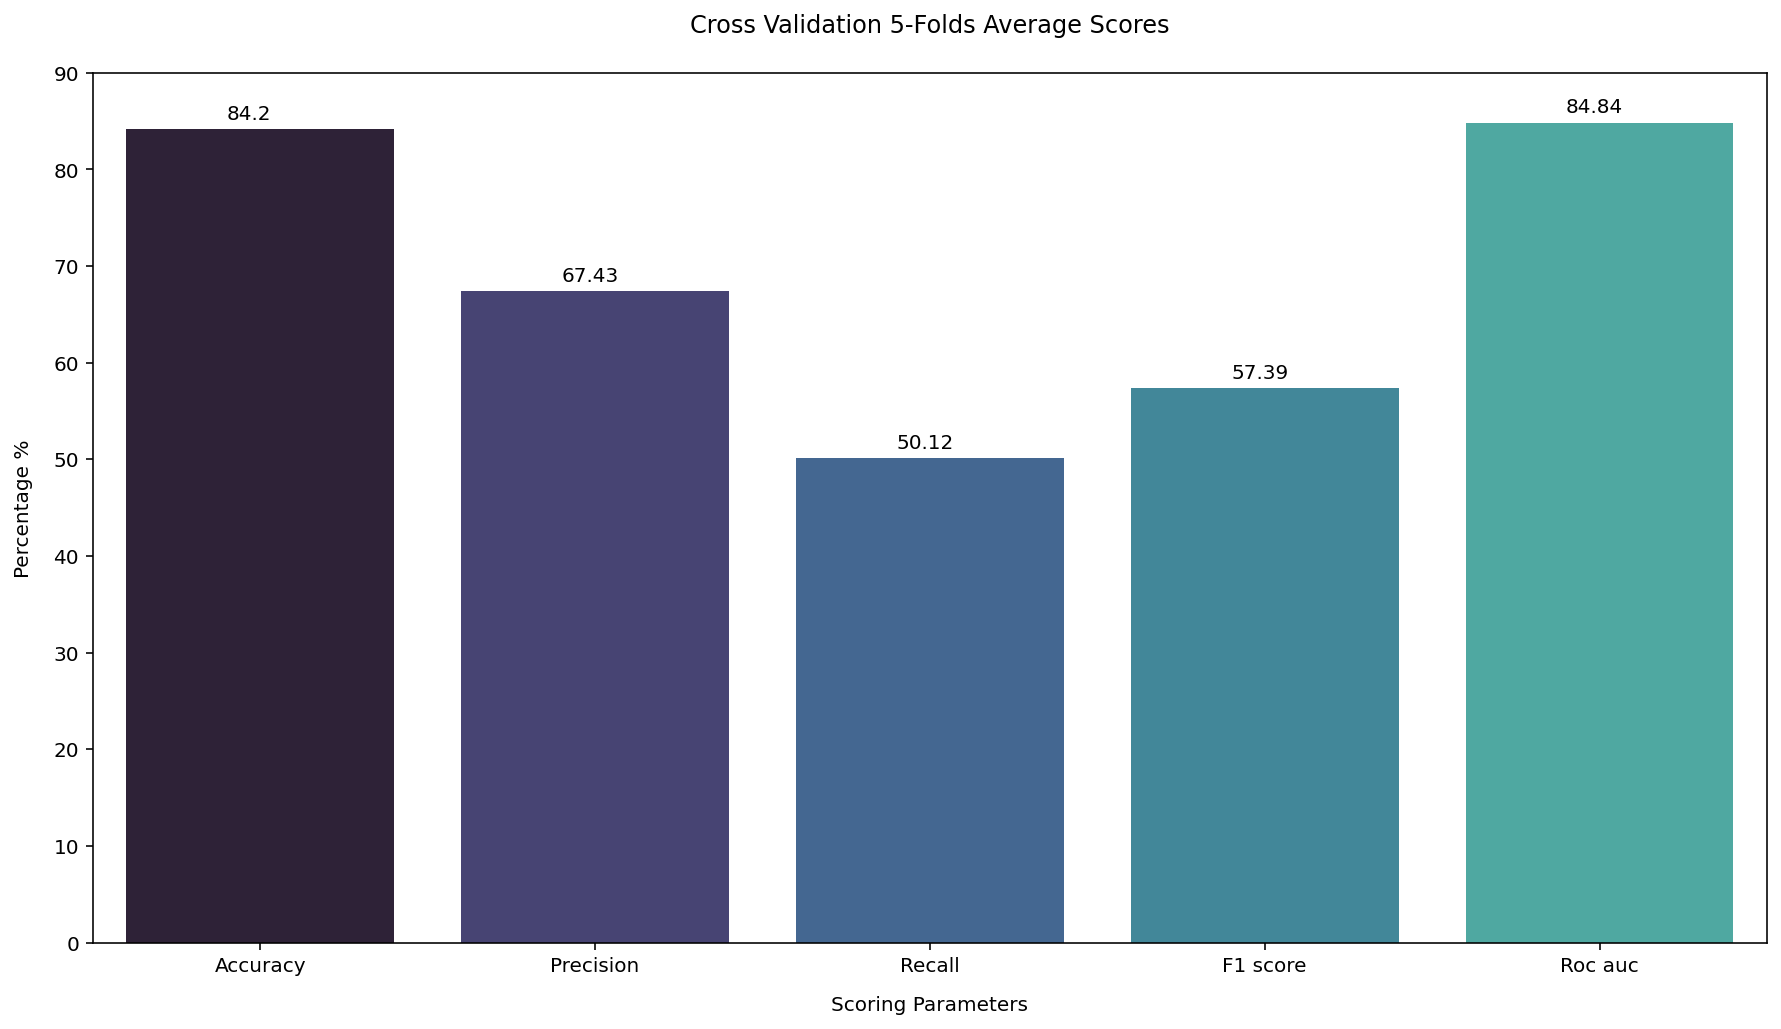

In [539]:
cv_score('LightGBM Classifier', lgbm_model, 5)

Plotting Receiver Operating Characteristic (ROC) Curve, to illustrate the diagnostic ability of LGBM Classifier as its discrimination threshold is varied and showing the Area under the ROC Curve (AUC) value which will tell us how much our model is capable of distinguishing between churn und nonchurn customers.

Area under the ROC Curve (AUC): 0.88


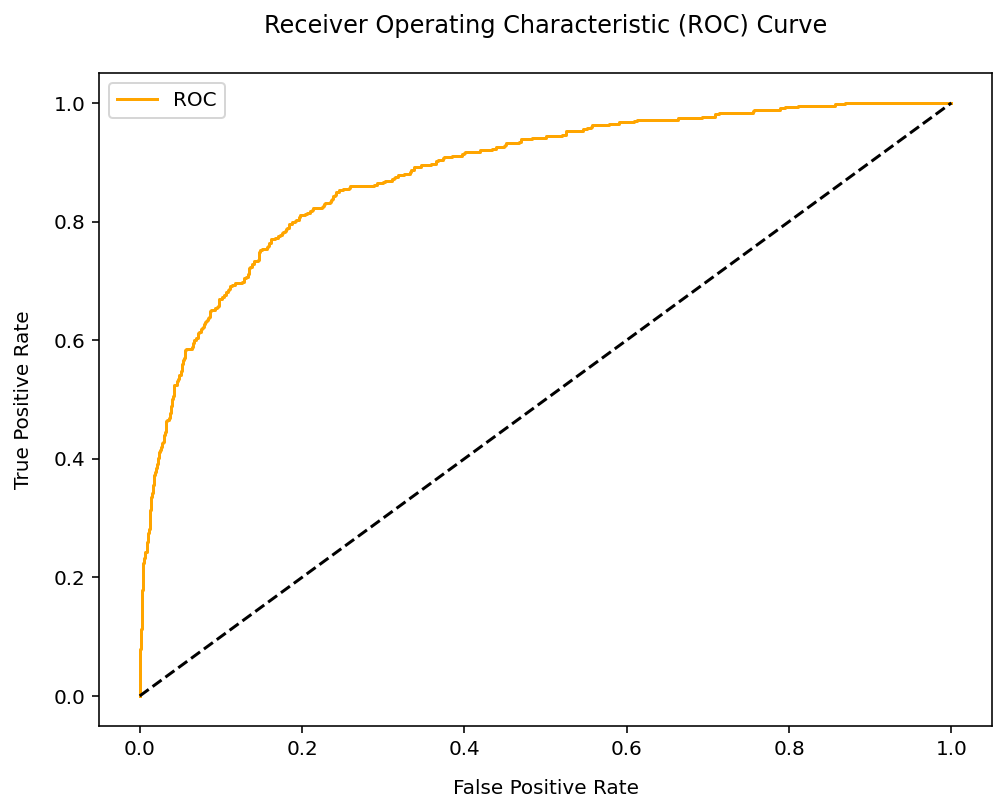

In [540]:
probs = lgbm_model.predict_proba(X_test)
probs = probs[:, 1]
auc8 = roc_auc_score(y_test, probs)
roc_auc['LightGBM Classifier'] = np.round(auc8, 2)
print('Area under the ROC Curve (AUC): %.2f' % auc8)
fpr8, tpr8, _ = roc_curve(y_test, probs)
plot_roc_curve(fpr8, tpr8)

Plotting Precision-Recall Curve for different thresholds of precision and recall much like the ROC Curve and showing the Area under the Precision-Recall Curve (AUCPR), it gives the number summary of the information in the Precision-Recall Curve.

Area under the PR Curve (AUCPR): 0.72


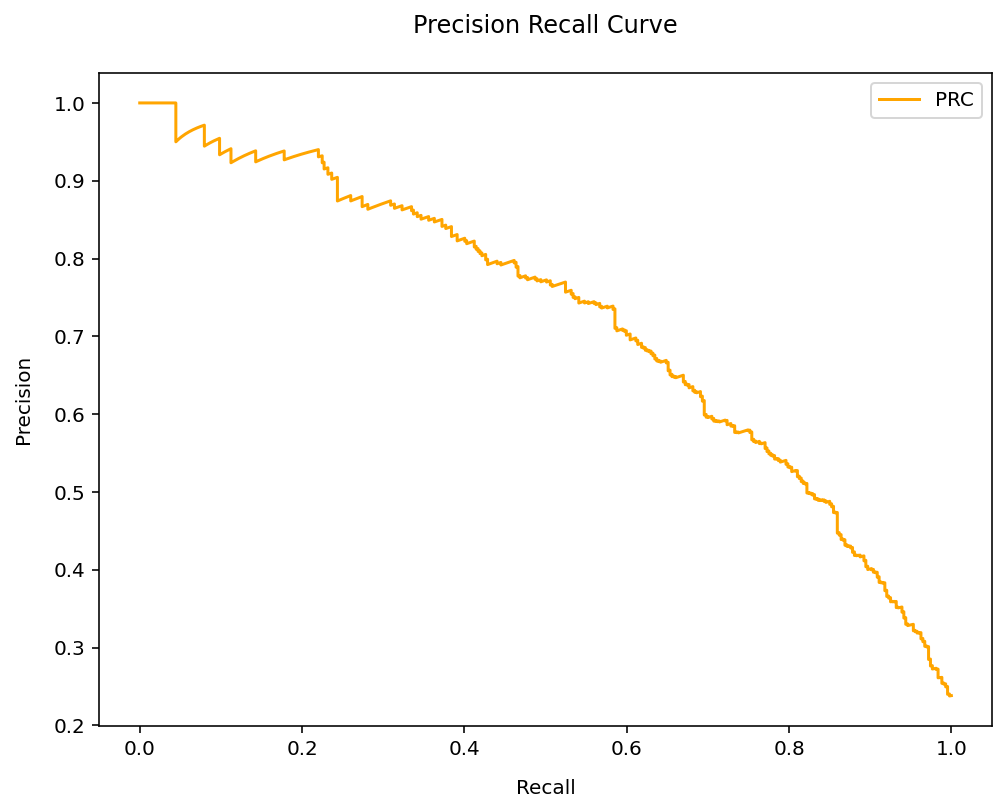

In [541]:
precision8, recall8, _ = precision_recall_curve(y_test, probs)
auc_score8 = auc(recall8, precision8)
pr_auc['LightGBM Classifier'] = np.round(auc_score8, 2)
print('Area under the PR Curve (AUCPR): %.2f' % auc_score8)
plot_precision_recall_curve(recall8, precision8)

## Feature Importance

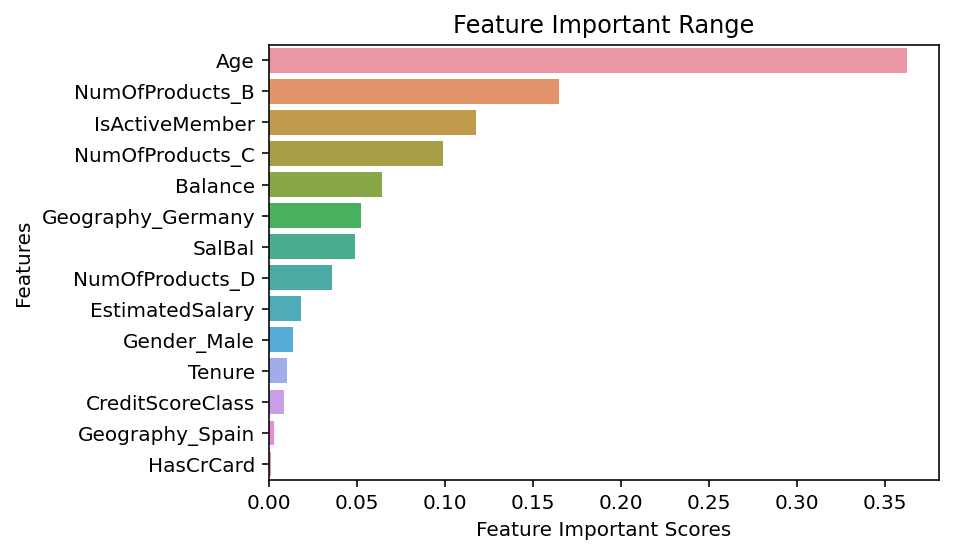

In [542]:
feature_imp = pd.Series(gbm_model.feature_importances_,
                        index = X_train.columns).sort_values(ascending = False)

sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Feature Important Scores')
plt.ylabel('Features')
plt.title("Feature Important Range")
plt.show()

## Performance Comparison

Plotting the accuracy metric score of the machine learning models for comparison.

In [543]:

models_tuned = [
    log_model,
    KNN_model,
    SVC_model,
    CART_model,
    rf_model,
    gbm_model,
    lgbm_model,
    xgb_model]

result = []
results = pd.DataFrame(columns = ["Models","Accuracy"])

for model in models_tuned:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores = cross_val_score(model, X_test, y_test, cv = 10, scoring = 'accuracy')
    result = pd.DataFrame([[names, acc * 100, 
                            np.mean(scores) * 100]], 
                          columns = ["Models", "Accuracy", "Avg_Accuracy"])
    results = results.append(result)
results

,Models,Accuracy,Avg_Accuracy
0,LogisticRegression,82.80,82.55
0,KNeighborsClassifier,82.05,80.80
0,SVC,78.65,78.65
0,DecisionTreeClassifier,83.65,84.20
0,RandomForestClassifier,86.05,85.40
0,GradientBoostingClassifier,85.10,86.10
0,LGBMClassifier,85.80,84.35
0,XGBClassifier,86.30,85.50


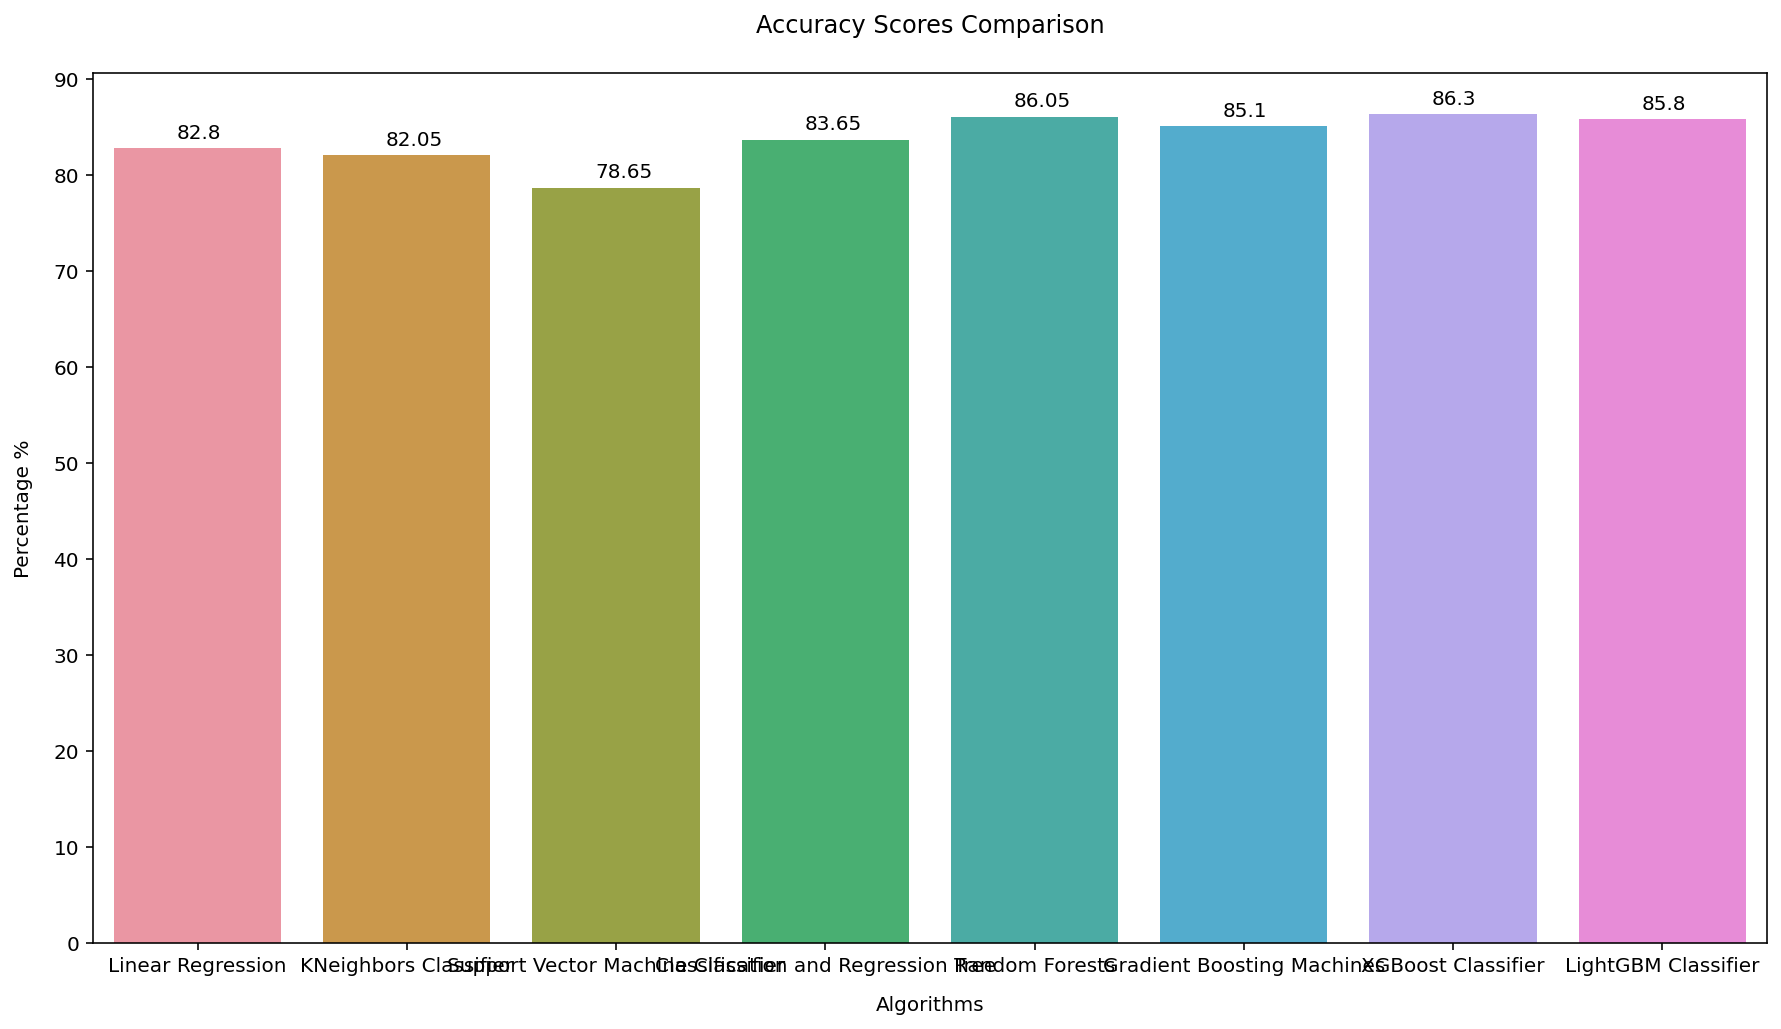

In [544]:
plt.figure(figsize = (15, 8))
sns.set_palette('cividis')
ax = sns.barplot(x = list(accuracies.keys()), y = list(accuracies.values()))
plt.yticks(np.arange(0, 100, 10))
plt.ylabel('Percentage %', labelpad = 10)
plt.xlabel('Algorithms', labelpad = 10)
plt.title('Accuracy Scores Comparison', pad = 20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()), xytext = (p.get_x() + 0.3, p.get_height() + 1.02))
plt.show()


Plotting the average accuracy metric score of the machine learning models for comparison.

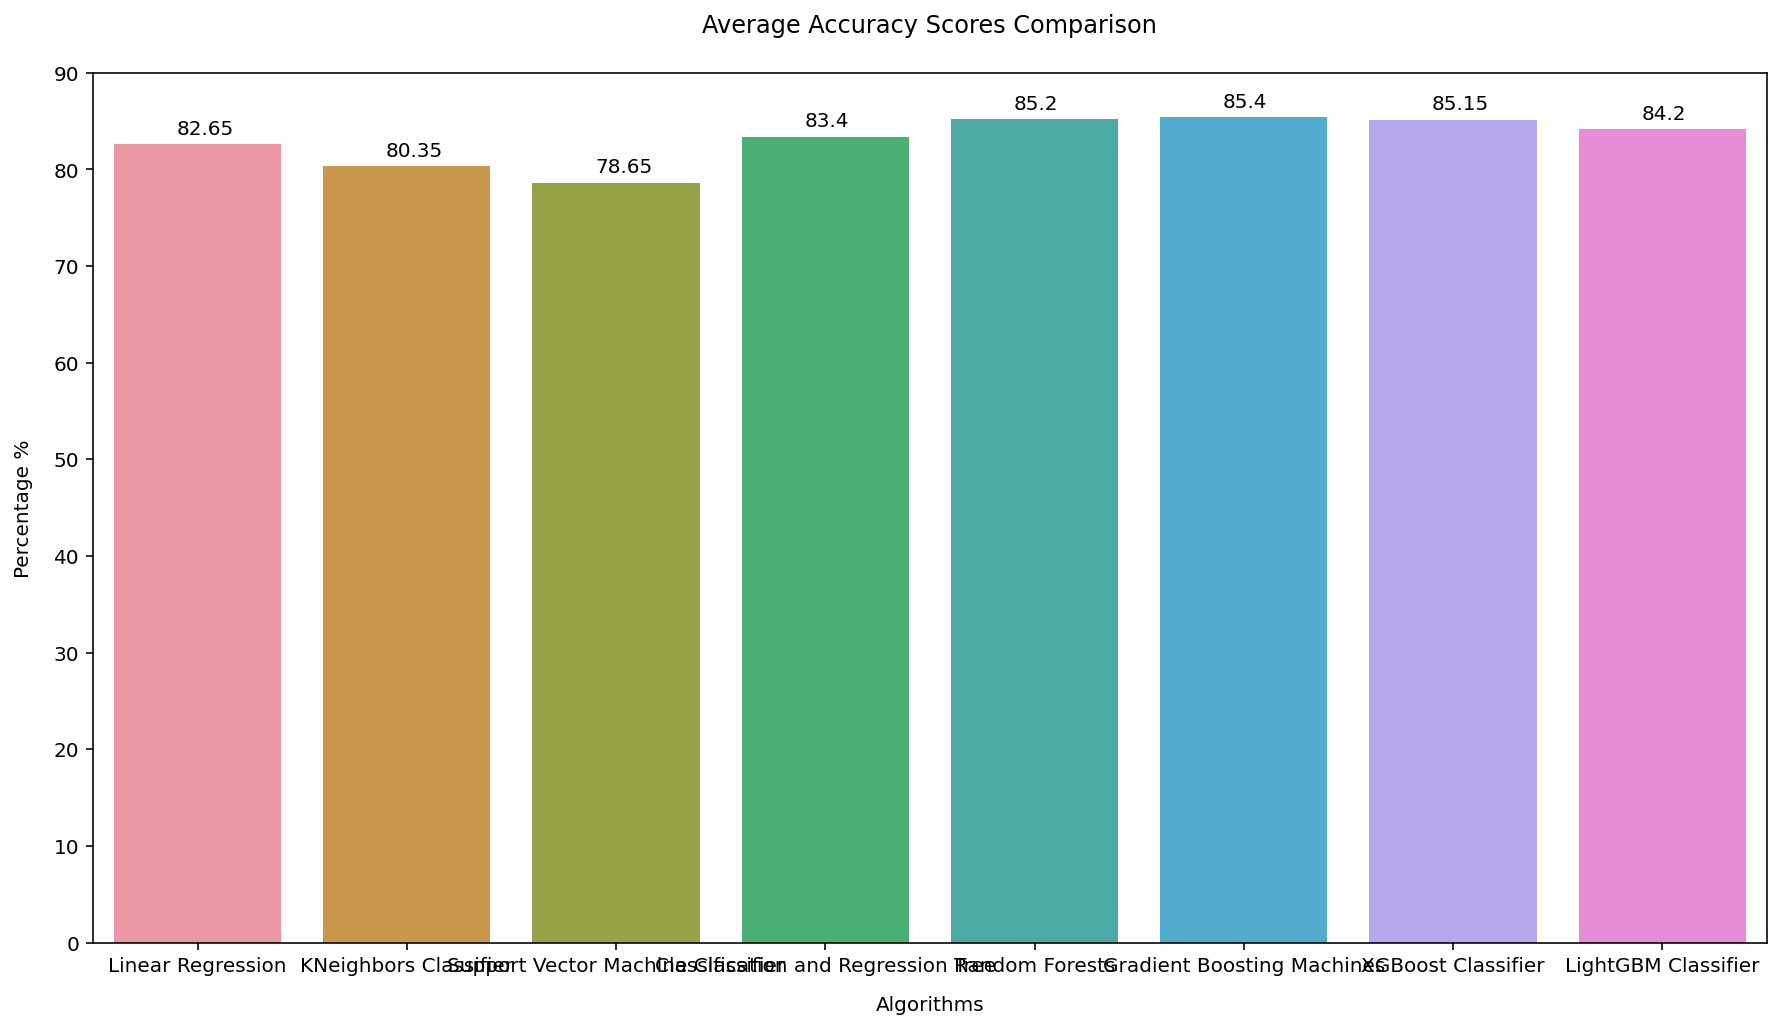

In [545]:
plt.figure(figsize = (15, 8))
sns.set_palette('viridis')
ax=sns.barplot(x = list(avg_accuracies.keys()), y = list(avg_accuracies.values()))
plt.yticks(np.arange(0, 100, 10))
plt.ylabel('Percentage %', labelpad = 10)
plt.xlabel('Algorithms', labelpad = 10)
plt.title('Average Accuracy Scores Comparison', pad = 20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()),xytext=(p.get_x() + 0.3, p.get_height() + 1.02))
plt.show()


Plotting the ROC Curve of the machine learning models for comparison.

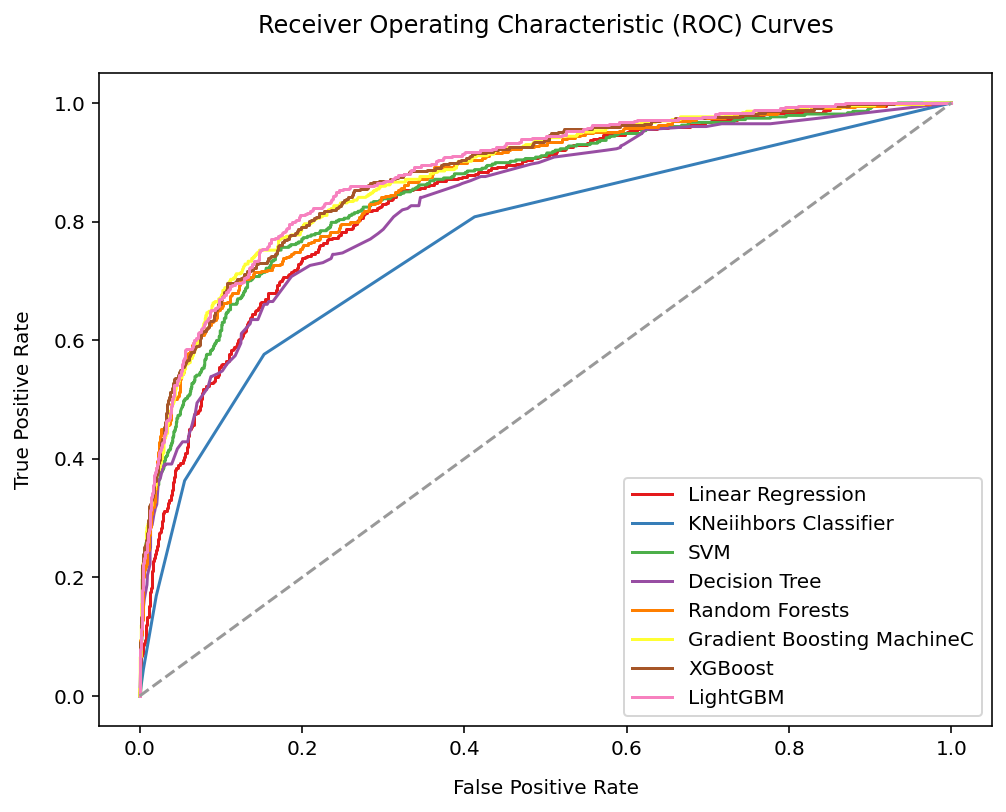

In [546]:
plt.figure(figsize = (8, 6))
sns.set_palette('Set1')
plt.plot(fpr1, tpr1, label = 'Linear Regression')
plt.plot(fpr2, tpr2, label = 'KNeighbors Classifier')
plt.plot(fpr3, tpr3, label = 'SVM')
plt.plot(fpr4, tpr4, label = 'Decision Tree')
plt.plot(fpr5, tpr5, label = 'Random Forests')
plt.plot(fpr6, tpr6, label = 'Gradient Boosting MachineC')
plt.plot(fpr7, tpr7, label = 'XGBoost')
plt.plot(fpr8, tpr8, label = 'LightGBM')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.ylabel('True Positive Rate', labelpad = 10)
plt.xlabel('False Positive Rate', labelpad = 10)
plt.title('Receiver Operating Characteristic (ROC) Curves', pad = 20)
plt.legend()
plt.show()

Plotting the AUC values of ROC Curve of the machine learning models for comparison.

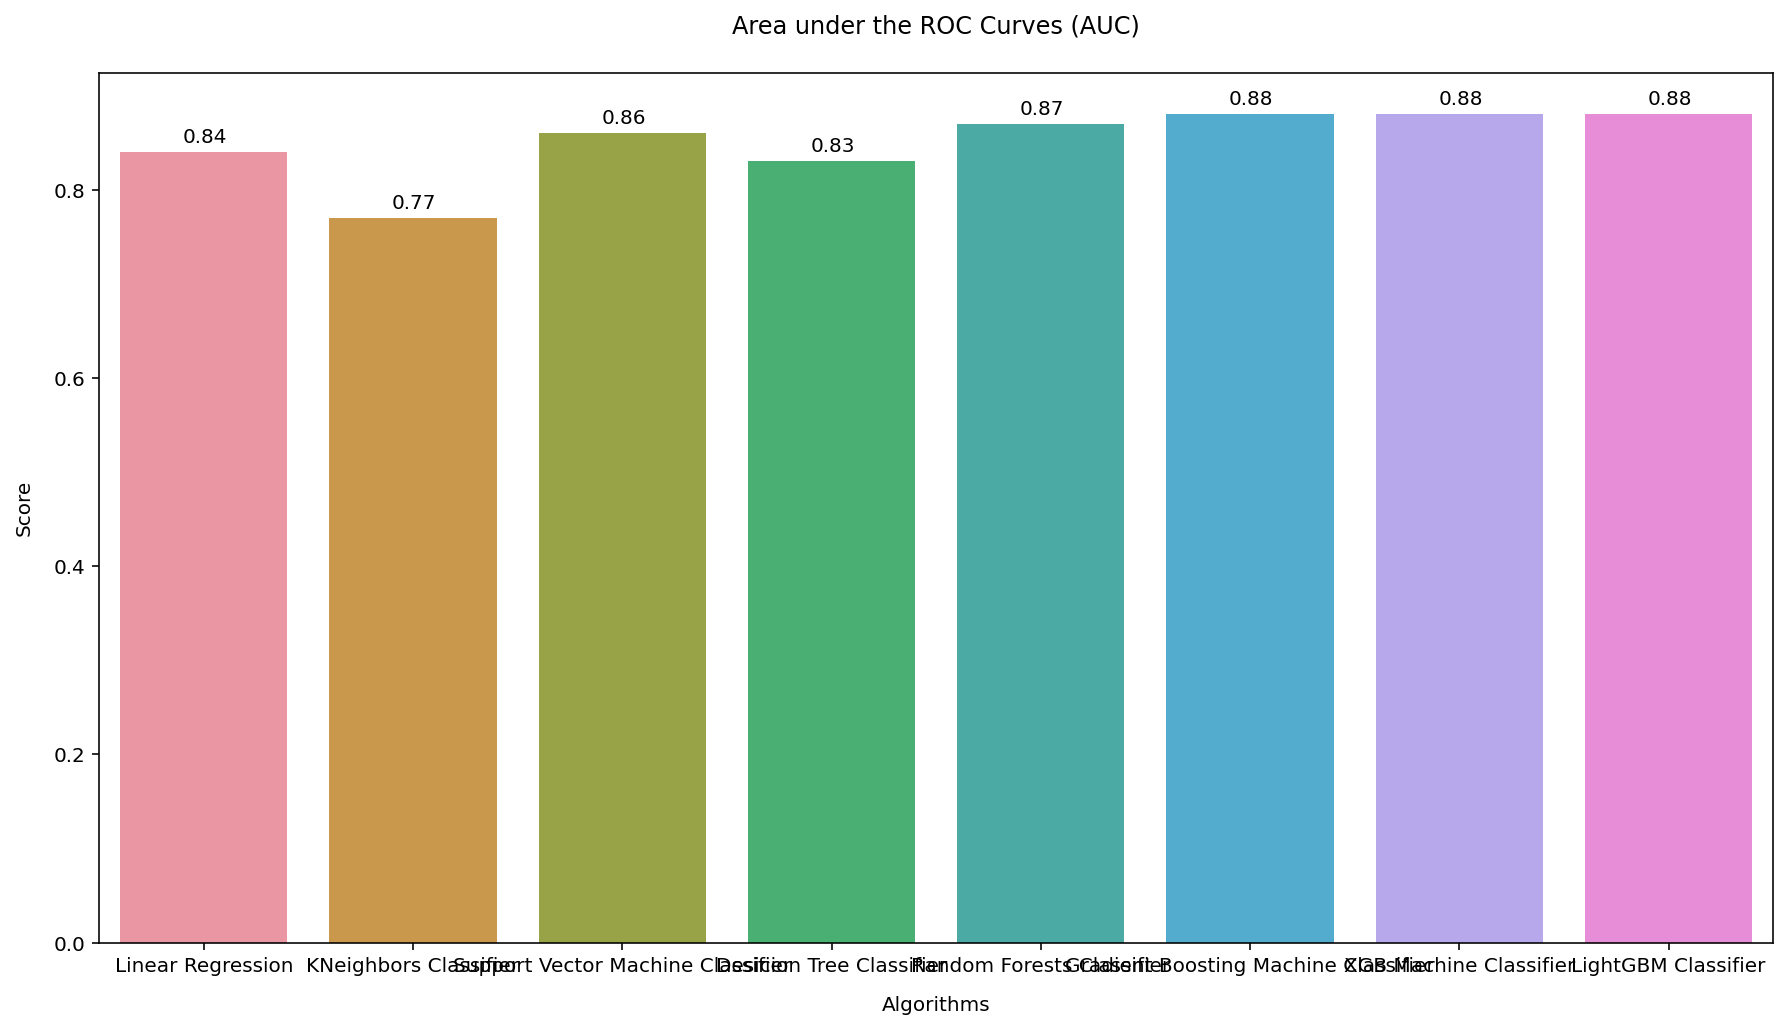

In [547]:
plt.figure(figsize = (15, 8))
sns.set_palette('magma')
ax = sns.barplot(x = list(roc_auc.keys()), y = list(roc_auc.values()))
#plt.yticks(np.arange(0,100,10))
plt.ylabel('Score', labelpad = 10)
plt.xlabel('Algorithms', labelpad = 10)
plt.title('Area under the ROC Curves (AUC)', pad = 20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()), xytext = (p.get_x() + 0.3, p.get_height() + 0.01))
plt.show()


Plotting the PR Curve of the machine learning models for comparison.

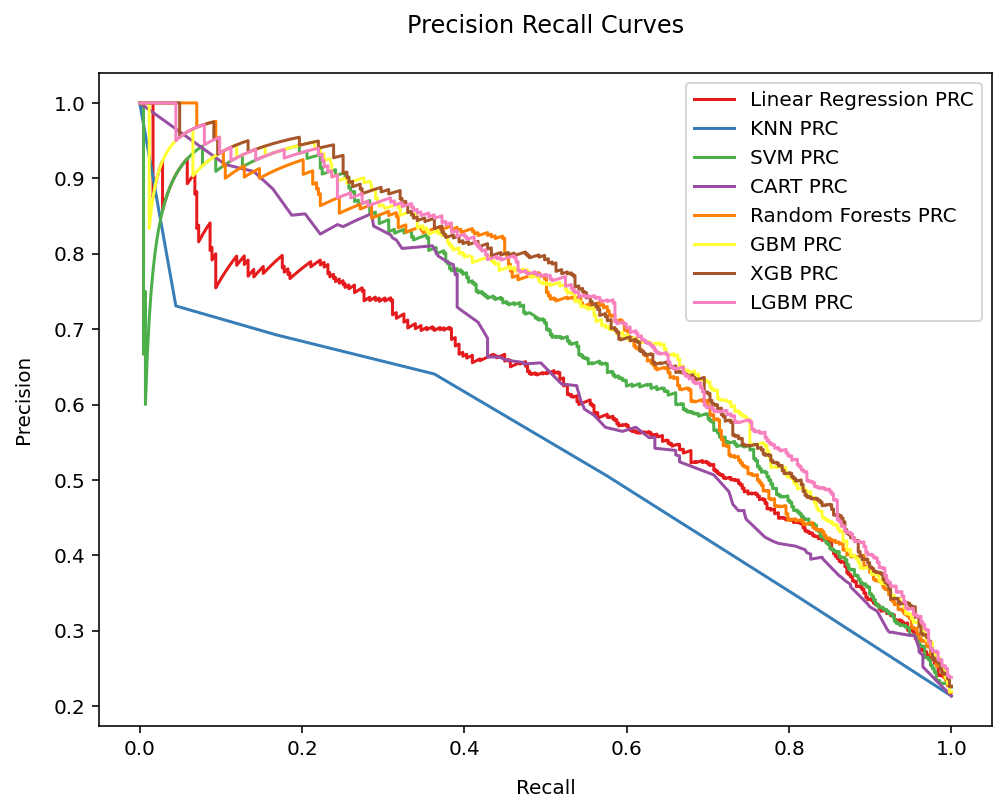

In [548]:
plt.figure(figsize = (8, 6))
sns.set_palette('Set1')
plt.plot(recall1, precision1, label = 'Linear Regression PRC')
plt.plot(recall2, precision2, label = 'KNN PRC')
plt.plot(recall3, precision3, label = 'SVM PRC')
plt.plot(recall4, precision4, label = 'CART PRC')
plt.plot(recall5, precision5, label = 'Random Forests PRC')
plt.plot(recall6, precision6, label = 'GBM PRC')
plt.plot(recall7, precision7, label = 'XGB PRC')
plt.plot(recall8, precision8, label = 'LGBM PRC')
plt.ylabel('Precision', labelpad = 10)
plt.xlabel('Recall', labelpad = 10)
plt.title('Precision Recall Curves', pad = 20)
plt.legend()
plt.show()

Plotting the AUC values of PR Curve of the machine learning models for comparison.

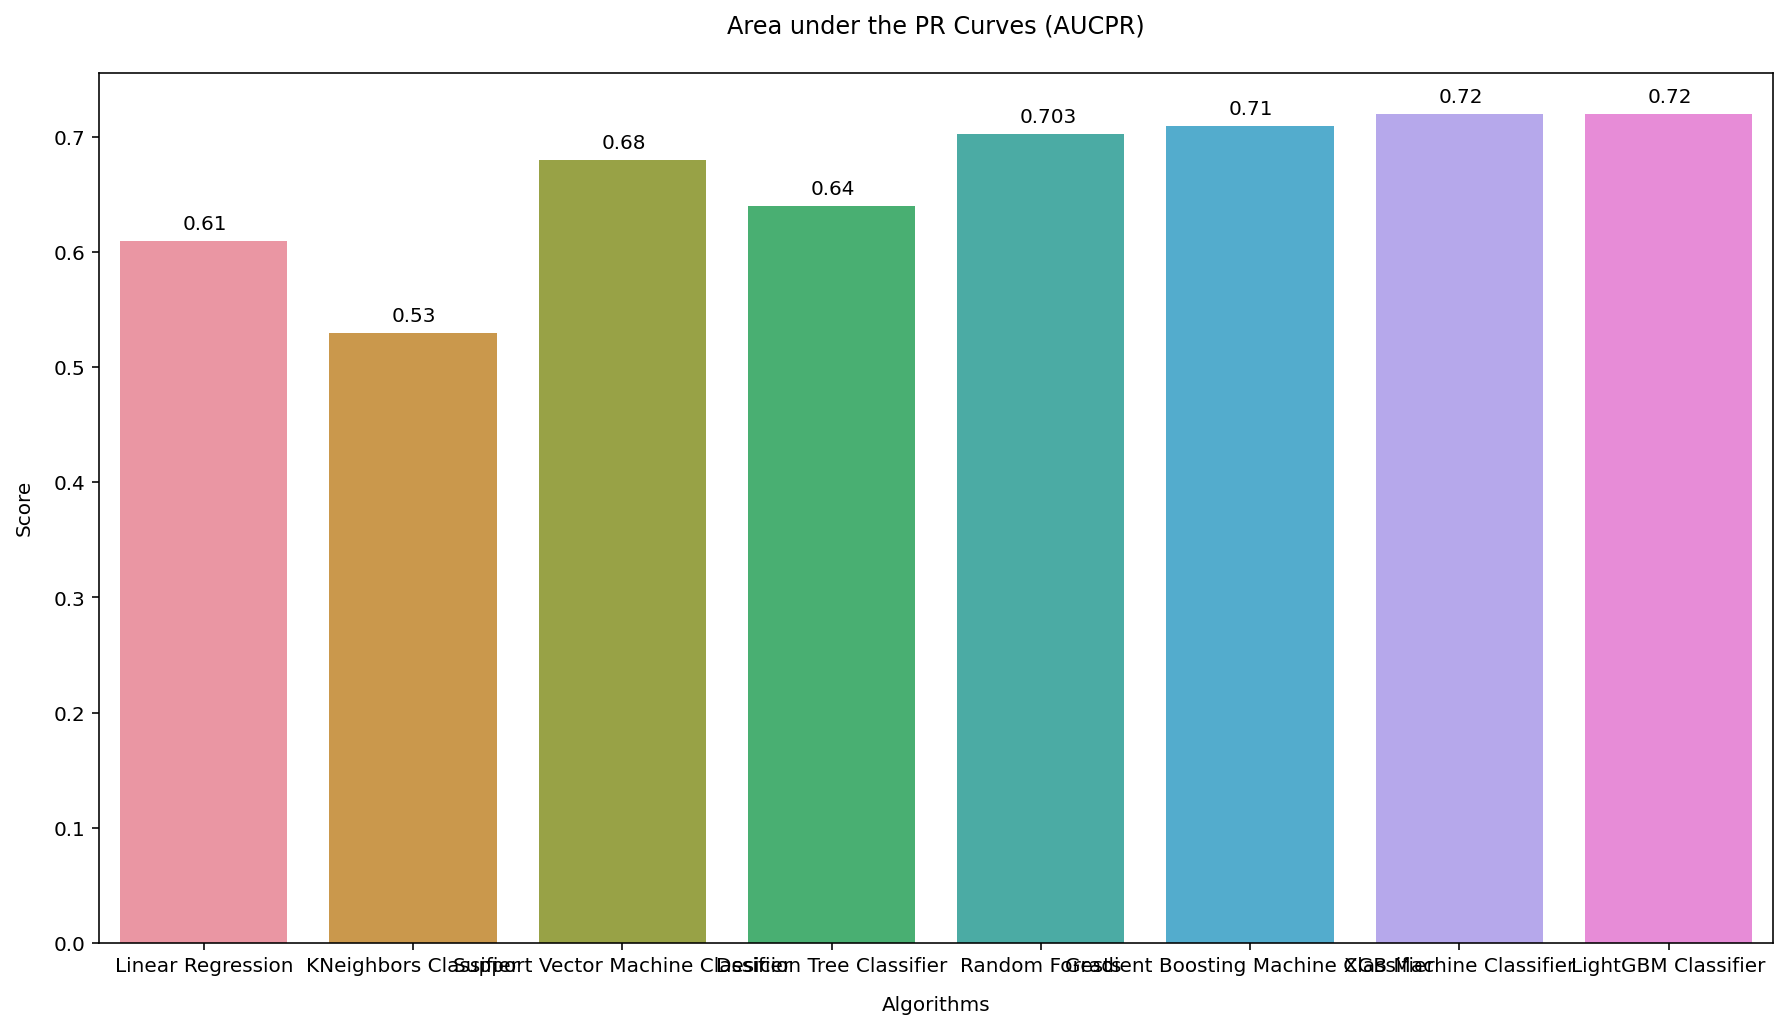

In [549]:
plt.figure(figsize = (15, 8))
sns.set_palette('mako')
ax = sns.barplot(x = list(pr_auc.keys()), y = list(pr_auc.values()))
plt.ylabel('Score', labelpad = 10)
plt.xlabel('Algorithms', labelpad = 10)
plt.title('Area under the PR Curves (AUCPR)', pad = 20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()), xytext = (p.get_x() + 0.3, p.get_height() + 0.01))
plt.show()

Conclusions:

* Most customers who using products 3 and 4 stopped working with the bank. A
* All customers using product number 4 were gone.
* Customers between the ages of 40 and 65 were more likely to quit the bank.
* Those who had a credit score below 450 had high abandonment rates.

So, the deciding factors are:
* Product choice of users
* Age of customer
* Credit Score

From the above deciding factors, credit score seems to have more influence and is chosen as key factor. 
